In [1]:
pip install biopython

  Using cached biopython-1.84-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
Using cached biopython-1.84-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pygraphviz

  Using cached pygraphviz-1.13-cp311-cp311-linux_x86_64.whl
Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import Align
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import re
import os
import copy
import pickle
import seaborn as sns
import gzip
import math
import networkx as nx
import matplotlib.pyplot as plt
import pygraphviz
import datetime
from itertools import combinations
date = datetime.datetime.now().strftime("%Y-%m-%d")
#from colorspacious import cspace_converter
#for statistics
import statistics
from scipy.stats import ttest_ind
from scipy.stats import chisquare
from scipy.stats import binomtest
from scipy.stats import ttest_rel
from scipy.stats import chi2_contingency, ttest_ind, levene, f, kruskal, chi2, linregress

In [4]:
def pickle_load(file):
    with gzip.open(file, 'rb') as f:
        print(f'file {file} loaded')
        gRNA_dict=pickle.load(f)
    return gRNA_dict    
#
#
def pickle_out(gRNA_dict,outfile):
    with gzip.open(outfile, 'wb') as f:
        pickle.dump(gRNA_dict, f)
    f.close()
#
#
def rename_strain(df):
    new=[]
    taxon_dict={'T.b. gambiense type I':'TbgI','T.b. gambiense type II':'TbgII',
                              'T.b. brucei':'Tbb','T.b. rhodesiense':'Tbr',
                             'T.b.':'Tb','T. brucei':'Tb'}
    for i,j in zip(df.index,df['taxon']):
        if j in taxon_dict:
            new.append(f'{taxon_dict[j]}_{i}')
        else:
            new.append(f'Tb_{i}')
    return(new)
#
def strain_mini(combined):
    strain_mini_sets={strain: [idx for idx in combined.loc[strain][~(combined.loc[strain].isna())].index if 'Tb_mO' in idx] for strain in combined.index}
    return(strain_mini_sets)
#
#assign mini families to each strain
def strain_mini_fam(strain_mini_sets,mini_family):
    def by_intersection(mfs1,mfs2,mini_family): 
        similarity1,similarity2={},{}
        for mf1 in mfs1:
            try:
                gfs1=set([g for g in mini_family[mf1]['cassettes'].split(';') if g != 'n'])
                s=max([len(gfs1.intersection(set([g for g in mini_family[mf2]['cassettes'].split(';') if g != 'n'])))/len(gfs1) for mf2 in mfs2 if mf2!='non_cannonical'])
                similarity1[mf1]=round(s,3)
                s=max([len(gfs1.intersection(set([g for g in mini_family[mf2]['cassettes'].split(';') if g != 'n']))) for mf2 in mfs2 if mf2 in mini_family if mf2!='non_cannonical'])
                similarity2[mf1]=s
            except:
                print([len(gfs1.intersection(set([g for g in mini_family[mf2]['cassettes'].split(';') if g != 'n'])))/len(gfs1) for mf2 in mfs2 if mf2!='non_cannonical'])
        return(similarity1,similarity2)
    def by_cassette_position(mfs1,mfs2,mini_family): #must be present at the same cassette position
        similarity1,similarity2={},{}
        for mf1 in [mf1 for mf1 in mfs1 if mf1 !='non_cannonical']: #mf1: all Tb mfs
            s=max([sum([1 for i,j in zip(mini_family[mf1]['cassettes'].split(';'),mini_family[mf2]['cassettes'].split(';')) if i==j and i!='n'])
                   /len([i for i in mini_family[mf1]['cassettes'].split(';') if i!='n']) #divided by the number of cannonical gRNAs in mf1
                   for mf2 in mfs2 if mf2 != 'non_cannonical']) #mf2: mf contained in a certain strain
            similarity1[mf1]=round(s,3)
        return(similarity1,similarity2)
    #
    class_family_dict={mini:fam for fam in mini_family for mini in mini_family[fam]['class']}
    mini_fam_sets={s:list(set([class_family_dict.get(mini,'non_cannonical') for mini in strain_mini_sets[s]])) for s in strain_mini_sets}
    mini_fam_sets={k: v for k, v in sorted(mini_fam_sets.items(), key=lambda item: item[0])}
    #sort mini by presence
    mf_presence,mf_similarity1,mf_similarity2={},{},{}
    for mf in mini_family:
        a=[1 for s in mini_fam_sets if mf in mini_fam_sets[s]]
        presence=sum(a)/len(mini_fam_sets)
        mf_presence[mf]=presence
    mf_presence={k: v for k, v in sorted(mf_presence.items(), key=lambda item: item[1],reverse = True)}
    #reorder mini families
    mini_family={k:mini_family[k] for k in mf_presence}
    #similarity
    for strain in mini_fam_sets:
        #similarity1,similarity2=by_intersection(mini_family,mini_fam_sets[strain],mini_family)
        similarity1,similarity2=by_cassette_position(mini_family,mini_fam_sets[strain],mini_family)
        mf_similarity1[strain]=similarity1
        mf_similarity2[strain]=similarity2
    return (mini_fam_sets,mf_presence,mini_family,mf_similarity1,mf_similarity2)

#remove those unique to SitaBip1: #something I checked on the server
def SitaBip1_remove(mf_presence,renamed_mini_family):
    print(f"Total minicircle family before remove those unique to SitaBip1:{len(renamed_mini_family)}")
    renamed_mini_family2={k:renamed_mini_family[k] for k in renamed_mini_family if mf_presence[k]!=0}
    print(f"Total minicircle family after remove those unique to SitaBip1: {len(renamed_mini_family2)}")
    return(renamed_mini_family2)

#
def plot_mfam_presence(mini_fam_sets,mini_family,out,figw=50,figh=100): #color by number of cannonical cassettes
    colors={5:'red',2:'cornflowerblue',3:'green',4:'orange',1:'black'}
    fig,ax = plt.subplots(1,1,figsize=(figw,figh))
    y=0
    for s in mini_fam_sets:
        presence=[i  for i,mf in enumerate(mini_family) if mf in mini_fam_sets[s]]
        cs=[colors[len([gf for gf in mini_family[mf]['cassettes'].split(';') if gf != 'n'])] for mf in mini_family if mf in mini_fam_sets[s]]
        ax.scatter(presence,[y]*len(presence),color=cs,marker='|')
        ax.text(-70,y,f"{s}")
        y+=1
    ax.set_xlim(-80,len(mini_family)+1)
    plt.savefig(out)
    plt.show()
#
#
def plot_mfam_similarity(mf_similarity1,mini_family,mini_fam_sets,out=False,figw=50,figh=100):
    colors={'TbgI':'red','TbgII':'cornflowerblue','Tbb':'green','Tbr':'orange','Tb':'black'}
    fig,ax = plt.subplots(1,1,figsize=(figw,figh))
    y=0
    for s in mf_similarity1:
        similarity=[mf_similarity1[s][k]**2 for k in mf_similarity1[s]]
        ax.scatter(range(len(similarity)),[y]*len(similarity),color='dimgray',marker='|',alpha=similarity)
        presence=[i  for i,mf in enumerate(mini_family) if mf in mini_fam_sets[s]]
        ax.scatter(presence,[y]*len(presence),color=colors[s.split('_')[0]],marker='|')
        ax.text(-70,y,f"{s}",color=colors[s.split('_')[0]])
        y+=1
    ax.set_xlim(-80,len(mini_family)+1)
    plt.savefig(out)
    plt.show()
#
#
def plot_mfam_number_of_gfam(mini_family,mf_presence,out=False,figw=20,figh=5):
    fig,ax = plt.subplots(1,1,figsize=(figw,figh))
    y=0
    cs=[len([gf for gf in mini_family[mf]['cassettes'].split(';') if gf != 'n']) for mf in mini_family]
    alphas=[mf_presence[mf] for mf in mini_family]
    ax.scatter(range(len(cs)),cs,color='blue',alpha=alphas)
    ax.plot(range(len(cs)),cs,color='grey',alpha=0.3)
    ax.set_xlim(-80,len(mini_family)+1)
    ax.set_ylabel('number of cassettes')
    #plt.savefig(out)
    plt.show()
#
#
def cumulation_plot_mf(mini_fam_sets,figw=20,figh=10):
    colors={'TbgI':'red','TbgII':'cornflowerblue','Tbb':'green','Tbr':'orange','Tb':'black'}
    pres=['TbgI_','Tbr_','Tbb_','TbgII_','Tb_']
    cumulate,sets,mf_counts,cs={k:{'set':[],'count':[],'colors':[]} for k in pres},[],[],[]
    for prefix in pres:#order by subspecies
        for strain in mini_fam_sets:
            if prefix in strain:
                cumulate[prefix]['set']+=mini_fam_sets[strain]
                sets+=mini_fam_sets[strain]
                cumulate[prefix]['set']=list(set(cumulate[prefix]['set']))
                sets=list(set(sets))
                cumulate[prefix]['count'].append(len(cumulate[prefix]['set']))
                mf_counts.append(len(sets))
                cumulate[prefix]['colors'].append(colors[prefix.replace('_','')])
                cs.append(colors[prefix.replace('_','')])
                
    #plot
    fig,axs = plt.subplots(2,1,figsize=(figw,figh))
    ax=axs[0]
    for k in cumulate:
        ax.scatter(range(len(cumulate[k]['count'])),cumulate[k]['count'],color=colors[k.replace('_','')],label=k.replace('_',''))
        ax.plot(range(len(cumulate[k]['count'])),cumulate[k]['count'],color=colors[k.replace('_','')])
    ax.set_ylabel('accumulative counts of total unique minicircle families')
    ax.set_xlabel('number of strains')
    ax.legend()
    ax=axs[1]
    ax.scatter(range(len(mf_counts)),mf_counts,color=cs)
    #plt.savefig(out)
    plt.show()
    #print(mf_count,cs)
    
#heatmap and dendrogram
def draw_heatmap_dendrogram(df,heatmapout,dendro_out):
    def similarity(s1,s2,df):
        l=max(len(df.loc[s1][df.loc[s1]==1]),len(df.loc[s2][df.loc[s2]==1])) #use the one with more cassettes as denominator
        a=round(sum((1-abs(np.array(df.loc[s1])-np.array(df.loc[s2]))).tolist())/l,3)
        return(a)
    diff_dict={s1:{s2:similarity(s1,s2,df) for s2 in df.index} for s1 in df.index}
    diff_mtx=pd.DataFrame.from_dict(diff_dict,orient='index')
    #heatmap
    fig, ax = plt.subplots(figsize=(150,150))
    ax=sns.heatmap(diff_mtx,square=True,ax=ax)
    plt.savefig(heatmapout)
    #dendrogram
    Z = linkage(diff_mtx, method='ward', metric='euclidean')
    fig = plt.figure(figsize=(25, 20))
    dn = dendrogram(Z,labels=diff_mtx.index)
    plt.savefig(dendro_out)
#
#
#change minicircle names
def rename_minicircles(mini_family,clean_mini_log):
    match_dict={list(filter(None,l.strip('\n').split(' ')))[0]:list(filter(None,l.strip('\n').split(' ')))[1] for l in open(clean_mini_log)}
    match_dict['Maxicircle']='Maxicircle'
    for mf in mini_family:
        mini_family[mf]['class']=[match_dict[m] for m in mini_family[mf]['class']]
    return(mini_family)
#
#
def make_fake_sequence(metadf,mini_fam_sets,mf_similarity1,outfile): #only need to include metadf, so combined is actually better, as the name has changed accordingly already
    surfix={'Central Africa':'CA','East Africa':'EA','na':'na','North Africa':'NA','Southern Africa':'SA','West Africa':'WA'}
    #metadf=metadf.apply(lambda x:, axis=1)
    seqs={s:''.join(['P' if mf in mini_fam_sets[s] else 'R' if mf_similarity1[s][mf]>=0.6 else '0' 
       for mf in mf_similarity1[s]]) 
       for s in mf_similarity1}
    #add continent as surfix for coloring
    records=[SeqRecord(Seq(seqs[s]),
            id=f"{s}_{surfix[metadf.loc[s,'continent']]}_{metadf.loc[s,'country'].replace(' ','_')}_{metadf.loc[s,'Year of isolation']}",
            description=s,name=s) for s in seqs]
    SeqIO.write(records,outfile,'fasta')
    return(records)
#
#modify the first step for data input
def process_df(csv,meta2):
    df=pd.read_csv(csv,index_col=0)#.rename(columns=df.iloc[0]).drop(df.index[0])
    df=df.drop(['MSUS-CI-78-TSW390','GUIWI-BOBO80-MURAZ18','SN54-TREU96']) #remove the known contaminated samples and Tbeq
    #clean up metadata
    metadf2=pd.read_csv(meta2,index_col=0,encoding='cp1252') #not utf8 encoding
    try:
        metadf2=metadf2.drop(['MSUS-CI-78-TSW390','GUIWI-BOBO80-MURAZ18','SitaBip1','SN54-TREU96','ABBA_b'])
    except:
        print('already removed')
    metadf2['taxon']=metadf2['taxon'].fillna('T. brucei').replace('T.b.','T. brucei')
    metadf2.rename(columns={'Year of isolation ': 'Year of isolation'}, inplace=True)
    metadf2['continent']=metadf2['continent'].fillna('na').replace('Southern Africa\xa0','Southern Africa')
    metadf2['country']=metadf2['country'].fillna('na')
    metadf2['Year of isolation']=metadf2['Year of isolation'].fillna('na')
    for s in ['MHOM-CI-78-DALOA72-cloneA','MHOM-CI-79-DALOA74','MHOM-CI-91-SIQUE1623','MHOM-ZR-71-C126','MSUS-CI-82-TSW125-KP1-cloneB']:
        metadf2.loc[s,'taxon']='T.b. gambiense type I'
    for s in ['MSUS-CI-78-TSW168']:
        metadf2.loc[s,'taxon']='T.b. gambiense type II'
    for s in ['MSUS-CI-78-TSW178','MSUS-CI-78-TSW38-021','MSUS-CI-78-TSW382-bis']:
        metadf2.loc[s,'taxon']='T.b. brucei'
    #Zambia is assigned to EA and SA --> assign all Zambia to SA
    for s in metadf2[metadf2.apply(lambda x:x['country']=='Zambia' and x['continent']=='East Africa', axis=1)].index:
        metadf2.loc[s,'continent']='Southern Africa'
    #ignore Tbeq Tbev data for now
    metadf2=metadf2.loc[metadf2.index.intersection(df.index)]
    #combine
    combined=pd.concat([df,metadf2], axis=1) #append won't change the order of columns (no auto sorting)
    renames=rename_strain(combined)
    combined['renamed']=renames
    combined=combined.set_index('renamed')
    return(metadf2,combined)

#in how many strains is each gf present
def gf_presence_func(gfam,gRNA_dict,combined):
    gf_presence={}
    for s in set(combined['taxon']):
        gf_presence[s]={}
        df=combined[combined['taxon']==s]
        for gf in gfam:
            total=[]
            for g in gfam[gf]['gRNA']:
                mini=gRNA_dict[g]['mO_name']
                try:
                    total+=list(df[df[mini].notnull()].index)
                except:
                    continue
            gf_presence[s][gf]=round(len(set(total))/len(df),6) #the ratio is used to color the patches for each gf
    return gf_presence
#deletion
def read_deletion_sites(deletion):
    deletion=SeqIO.to_dict(SeqIO.parse(deletion,'fasta'))
    delets={}
    for k in deletion:
        sites=[0 if b!='-' else 1 for b in deletion[k].seq] #0 for deletion sites
        delets[k]=sites
    return(delets)
# insertions
def read_editing_sites(small_u):
    smallu=SeqIO.to_dict(SeqIO.parse(small_u,'fasta'))
    edits={}
    for k in smallu:
        sites=[1 if b=='u' else 0 for b in smallu[k].seq] #1 for insertions
        edits[k]=sites
    return(edits)
#adjusted to alignment result of small u file
def adjust_deletions(small_u,deletion,outfile):
    insertions=SeqIO.to_dict(SeqIO.parse(small_u,'fasta'))
    dels=SeqIO.to_dict(SeqIO.parse(deletion,'fasta'))
    for k,v in insertions.items():
        add=0
        for i,b in enumerate(v.seq):
            if b=='-':
                position=len(v.seq[:i].replace('-',''))
                dels[k].seq=dels[k].seq[:position+add]+'-'+dels[k].seq[position+add:] #change '-' to 'a' for viewing adjustments
                add+=1
    records=[SeqRecord(v.seq,id=v.id,name=v.name,description=v.description) for k,v in dels.items()]
    SeqIO.write(records,outfile,'fasta')

In [5]:
#check copy number of a gene (gRNA family)
def gfam_copy_number(strain,strain_mini_sets,gRNA_by_mini,gfam,combined):
    gfam_copy={}
    canonical=[i for i in strain_mini_sets[strain] if i in gRNA_by_mini]
    for mini in canonical:
        tmpgf={v['gRNA_family'][0]:{v['gRNA']:combined.loc[strain,mini]} for v in gRNA_by_mini[mini]}
        for gf in tmpgf:
            if gf in gfam_copy:
                gfam_copy[gf].update(tmpgf[gf])
            else:
                gfam_copy[gf]=tmpgf[gf]
    size=sum([combined.loc[strain,i] for i in strain_mini_sets[strain]])
    #fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), sharey=True)
    #axs.hist(gfam_copy.values(),bins=range(0,round(max(gfam_copy.values())),8))
    #axs.set_xlabel(f"{strain}: {round(size)}, #gf: {len(gfam_copy)}")
    #plt.show()
    return (gfam_copy)
def gfam_copy_iter(strain_mini_sets,mini_dict2,gfam,combined):
    strain_gfam={}
    for strain in strain_mini_sets:
        strain_gfam[strain]=gfam_copy_number(strain,strain_mini_sets,mini_dict2,gfam,combined)
    return strain_gfam
#visualize gfam analysis
def t_test(col,subject,combined,value):
    for t in [i for i in set(combined[col]) if i != subject]:
        subj=combined[combined[col]==subject][value]
        query=combined[combined[col]==t][value]
        a=ttest_ind(subj, query)
        #if a.pvalue<0.05:
        print('pvalue',round(a.pvalue,4),f"{subject} mean: {round(sum(subj)/len(subj),2)} vs {t} mean {round(sum(query)/len(query),2)}")

In [6]:
#all_strain='/home/jovyan/Minicircle_gRNA_families/In_files/merged_gRNAs.pickle'
#Tb_gRNA=pickle_load(all_strain)
#csv='/home/jovyan/Minicircle_Population/Tb_normalized2maxi30_v3_mini_copy.csv' #Tb_mO_5750 to Tb_mO_6398 are SitaBip contigs, hence the df is shorter (5685) than total minicircle count 6398
csv='/home/jovyan/Minicircle_gRNA_families/In_files/Tb_copy_number_norm2_maxi30.20240209.csv'
meta='/home/jovyan/Minicircle_Population/Tb_metadata.csv'
#updated metadata, turns out is very much the same
#meta2='/home/jovyan/Minicircle_gRNA_families/In_files/updated_metadata_isolates 2022-01-09.csv'
#meta2='/home/jovyan/Minicircle_gRNA_families/In_files/all_annotated_metadata_isolates_20240410.csv' #annotate all strains
meta2='/home/jovyan/Minicircle_gRNA_families/In_files/all_annotated_metadata_isolates_2024-09-02.csv' #updated_metadata_isolates 2022-01-09.csv'
#Tb_pickle_old='/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb/Old_output_plots2023/all_Tb_updated_4_dicts.pickle'
#Tb_pickle_updated='/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb/all_Tb_updated_4_dicts.pickle'
Tb_pickle_updated='/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb/all_Tb_updated_4_dicts_0829.pickle'
merged_cassettes='/home/jovyan/Minicircle_gRNA_families/In_files/merged_cassettes_20240529.pickle'
#mRNA
#small_u=f'/home/jovyan/Minicircle_gRNA_families/In_files/EATRO1125_edited_mRNA_small_u.fasta'
#deletion=f'/home/jovyan/Minicircle_gRNA_families/In_files/EATRO1125_deletions_mRNA.txt'
small_u='/home/jovyan/Minicircle_gRNA_families/Compare_strains/Tbg1_small_u_aligned_with_Tb.fasta'
deletion='/home/jovyan/Minicircle_gRNA_families/Compare_strains/Mongo_deletions_mRNA_v1.txt'
aligned_del='/home/jovyan/Minicircle_gRNA_families/Compare_strains/Mongo_deletions_mRNA_v1_aligned_with_Tb.txt'
adjust_deletions(small_u,deletion,aligned_del)
#5 known Tbg1 strains in Tb are relabelled
metadf2,combined=process_df(csv,meta2)
#minor corrections of the taxon
taxon_correct={'T.b. gambiense type I':'T.b. gambiense type I','T.b. gambiense type II':'T.b. gambiense type II',
                              'T.b. brucei':'T.b. brucei','T.b. rhodesiense':'T.b. rhodesiense',
                             'T.b.':'T. brucei','T. brucei':'T. brucei'}
taxa=[taxon_correct.get(t,'T. brucei') for t in combined['taxon']]
combined['taxon']=taxa
#combined['minicircle_classes'] = combined.count(axis=1)-9
mini_class=[len([i for i in combined.loc[s].dropna().index if 'Tb_mO' in i]) for s in combined.index]
combined['minicircle_classes']=mini_class
strain_mini_sets=strain_mini(combined)
combined['Total MCN per network']=[sum([combined.loc[strain,i] for i in strain_mini_sets[strain]]) for strain in combined.index]
#

tmp=pickle_load(Tb_pickle_updated)
gRNA_dict,gRNA_families,mini_dict,renamed_mini_family=tmp[0],tmp[1],tmp[2],tmp[3]
gfam={gf:record for m,v in gRNA_families.items() for gf,record in v.items()}
for gf in gfam:
    rightmost=[int(gRNA_dict[g]['mRNA_end'])-6 for g in gfam[gf]['gRNA']]
    leftmost=[int(gRNA_dict[g]['mRNA_start']) for g in gfam[gf]['gRNA']]
cassettes=['I','II','III','IV','V','Orphan']
for gf in gfam:
    cs=[gRNA_dict[g]['cassette_label'] for g in gfam[gf]['gRNA']]
    gfam[gf]['cassettes']={c:cs.count(c) for c in cassettes} 
print(f"{len(gRNA_dict)} gRNAs and {len(mini_dict)} minicircles were extracted from pickled file")

already removed
file /home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb/all_Tb_updated_4_dicts_0829.pickle loaded
13700 gRNAs and 5510 minicircles were extracted from pickled file


In [7]:
#sort gRNAs into minicircles
gRNA_by_mini={}
for v in gRNA_dict.values():
    if v['mO_name'] not in gRNA_by_mini:
        gRNA_by_mini[v['mO_name']]=[v]
    else:
        gRNA_by_mini[v['mO_name']].append(v)

In [8]:
cassettes=pickle_load(merged_cassettes)
#update with Tbg1
tbg1cassettes='/home/jovyan/Minicircle_gRNA_families/In_files/TbgI_cassettes_20240529.pickle'
tbg1cassettes=pickle_load(tbg1cassettes)
tbg1cassettes={f"tbg1_cassette_{i}":v for i,v in enumerate(tbg1cassettes.values())}
tbg1mini=list(set([v['mO_name'] for v in tbg1cassettes.values()]))
#original number of cassettes
print(f"{len(cassettes)} cassettes were present including minicircles to be removed, not updated with TbgI cassettes yet")
includedmini=[i for i in combined.columns if 'Tb_' in i]
cassettes={f"cassette_{i}":v for i,v in enumerate(cassettes.values()) if v['mO_name'] in includedmini}
allmini=set([v['mO_name'] for v in cassettes.values()])
print(f"{len(cassettes)} cassettes are present in the {len(allmini)} minicircles")
#remove minicircles in TbgI
cassettes={f"cassette_{i}":v for i,v in enumerate(cassettes.values()) if v['mO_name'] not in tbg1mini}
allmini=set([v['mO_name'] for v in cassettes.values()])
print(f"{len(cassettes)} cassettes are present in the {len(allmini)} minicircles found not in Tbg1")

#add back TbgI minicircles using TbgI records: for finding canonical gRNAs
cassettes.update(tbg1cassettes)
allmini=set([v['mO_name'] for v in cassettes.values()])
print(f"{len(cassettes)} cassettes are present in the {len(allmini)} minicircles")
#
#if any minicircle without cassettes are encoding gRNA genes
mini_gRNA=set([v['mO_name'] for g,v in gRNA_dict.items()])
z=mini_gRNA.difference(allmini)
print(f"{z} is a list of minicircles with gRNA genes but no cassette structures")
#
print(f"{len([1 for v in cassettes.values() if v['type']=='canonical'])} are canonical")
print(f"{len([1 for v in cassettes.values() if v['type']=='non-canonical'])} are non_canonical")
#assign cassettes to minicircles
mini_cassettes={}
for v in cassettes.values():
    if v['mO_name'] not in mini_cassettes:
        mini_cassettes[v['mO_name']]={v['cassette_label']:v}
    else:
        mini_cassettes[v['mO_name']][v['cassette_label']]=v

#count canonical after removing double counts
print('\tremove double counts\t')
print(f"canonical:{len([1 for m in mini_cassettes for v in mini_cassettes[m].values() if v['type']=='canonical'])}")
print(f"non-canonical:{len([1 for m in mini_cassettes for v in mini_cassettes[m].values() if v['type']=='non-canonical'])}")

#correct some cassette assignments
for k,v in gRNA_by_mini.items():
    for grna in v:
        try:
            if grna['cassette_label'] in ['Maxi','Orphan' ]:
                continue
            elif mini_cassettes[k][grna['cassette_label']]['type']=='non-canonical':
                #print(k,grna['cassette_label'])
                mini_cassettes[k][grna['cassette_label']]['type']='canonical'
        except:
            print(grna)
#set canonical cassettes that no longer has a gRNA assigned to as non-canonical
canonicals={m:set([cassette['cassette_label'] for cassette in v]) for m,v in gRNA_by_mini.items()}
for m,v in mini_cassettes.items():
    for c,record in v.items():
        if record['type']=='canonical':
            if c not in canonicals.get(m,[]):
                record['type']='non-canonical'
#count canonical after correction
print('\tadd cassettes supposed to be canonical\t')
print(f"canonical:{len([1 for m in mini_cassettes for v in mini_cassettes[m].values() if v['type']=='canonical'])}")
print(f"non-canonical:{len([1 for m in mini_cassettes for v in mini_cassettes[m].values() if v['type']=='non-canonical'])}")


file /home/jovyan/Minicircle_gRNA_families/In_files/merged_cassettes_20240529.pickle loaded
file /home/jovyan/Minicircle_gRNA_families/In_files/TbgI_cassettes_20240529.pickle loaded
19722 cassettes were present including minicircles to be removed, not updated with TbgI cassettes yet
19195 cassettes are present in the 5633 minicircles
18612 cassettes are present in the 5461 minicircles found not in Tbg1
19273 cassettes are present in the 5655 minicircles
{'Maxicircle'} is a list of minicircles with gRNA genes but no cassette structures
13088 are canonical
6185 are non_canonical
	remove double counts	
canonical:13082
non-canonical:5726
	add cassettes supposed to be canonical	
canonical:13088
non-canonical:5720


5 43 3714 1890 3
18808


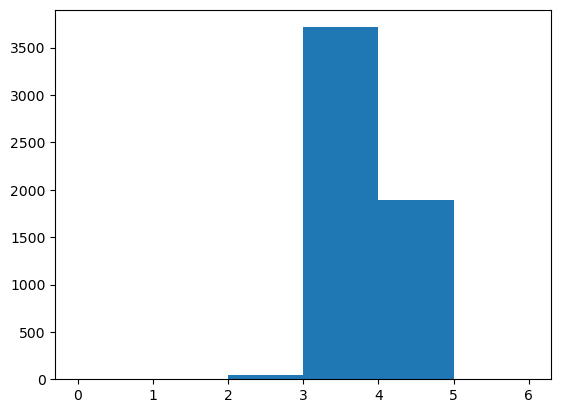

In [9]:
#cassettes per mini
data=[len(set([c['cassette_label'] for c in v.values()])) for v in mini_cassettes.values()]
print(data.count(1),data.count(2),data.count(3),data.count(4),data.count(5))
print(sum(data))
plt.hist(data,bins=[0,1,2,3,4,5,6])
plt.show()

total gRNA: 13700 13700
Orphan gRNA: 297
I gRNA: 3521
II gRNA: 3984
III gRNA: 205
IV gRNA: 4217
V gRNA: 1475
VI gRNA: 0
Maxi gRNA: 1
gRNAs on cassettes that encoded multiple gRNAs: 314
average: 2.3750680457267284
0:14
1:846
2:2070
3:2221
4:360


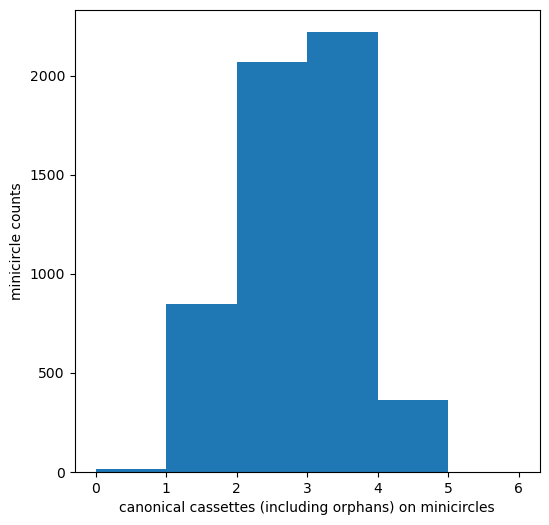

In [10]:
# gRNA summaries
print(f"total gRNA: {len(gRNA_dict)} {sum([len(v) for v in gRNA_by_mini.values()])}")
#how many cassettes actually contain gRNA

#count orphan gRNAs
for cass in ['Orphan','I','II','III','IV','V','VI','Maxi']:
    hits=[k for k,v in gRNA_dict.items() if v['cassette_label']==cass]
    print(f"{cass} gRNA: {len(hits)}")
#count cassettes with two gRNAs
multi=0
for m in gRNA_by_mini:
    cs=[v['cassette_label'] for v in gRNA_by_mini[m]]
    cs_counts=[cs.count(c) for c in set(cs) if c !='Orphan']
    multiple_gRNAs=[count for count in cs_counts if count >1]#multiple gRNAs
    record=[]
    if len(multiple_gRNAs)>0:
        multi+=sum(multiple_gRNAs)-len(multiple_gRNAs)
print(f"gRNAs on cassettes that encoded multiple gRNAs: {multi}")
#gRNA per minicircle
data=[len(set([g['cassette_label'] for g in v if g['cassette_label']!='Orphan'])) for v in gRNA_by_mini.values()]
print(f"average: {sum(data)/len(data)}")
for i in set(data):
    print(f"{i}:{data.count(i)}")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), sharey=False)
ax.hist(data,bins=[0,1,2,3,4,5,6])
ax.set_xlabel('canonical cassettes (including orphans) on minicircles')
ax.set_ylabel('minicircle counts')
plt.show()

In [11]:
insertions=read_editing_sites(small_u)
dels=read_deletion_sites(deletion)
mini_presence={mini: [idx for idx in combined[mini][~(combined[mini].isna())].index] for mini in combined.columns}

In [12]:
gf_presence=gf_presence_func(gfam,gRNA_dict,combined)

In [13]:
#only need to run once
strain_gfam=gfam_copy_iter(strain_mini_sets,gRNA_by_mini,gfam,combined)
combined['gRNA_family_count']=[len(strain_gfam[s]) for s in combined.index]
#gfam to dataframe
strain_gfam_sum={strain: {gf:sum([cp for cp in strain_gfam[strain][gf].values()]) for gf in strain_gfam[strain]} for strain in strain_gfam}
strain_gfam_df=pd.DataFrame.from_dict(strain_gfam_sum,orient='index')
strain_gfam_df['taxon']=[i.split('_')[0] for i in strain_gfam_df.index]

In [14]:
set([v['gRNA_family'][0] for v in gRNA_dict.values() if 'ND3' in v['gRNA_family'][0]])
len(strain_gfam_df)

224

In [15]:
print([i for i in gfam.keys() if 'ND3' in i])
[i for i in strain_gfam['TbgI_104AT'].keys() if 'ND3' in i]
gRNA_by_mini['Tb_mO_5535']
set([v['gRNA_family'][0] for m in gRNA_by_mini for v in gRNA_by_mini[m] if 'ND3' in v['gRNA_family'][0]])

['ND3-62_63', 'ND3-75_84', 'ND3-102_116', 'ND3-129_130', 'ND3-138_150', 'ND3-157_158', 'ND3-171_180', 'ND3-198_211', 'ND3-231_249', 'ND3-260_270', 'ND3-295_304', 'ND3-327_336', 'ND3-362_370', 'ND3-385_395', 'ND3-426_437']


{'ND3-102_116',
 'ND3-129_130',
 'ND3-138_150',
 'ND3-157_158',
 'ND3-171_180',
 'ND3-198_211',
 'ND3-231_249',
 'ND3-260_270',
 'ND3-295_304',
 'ND3-327_336',
 'ND3-362_370',
 'ND3-385_395',
 'ND3-426_437',
 'ND3-62_63',
 'ND3-75_84'}

In [16]:
#CR4 deletion
strains=['TbgI_13_97D','TbgI_14_97D','TbgI_15_97D','TbgI_A005','TbgI_BAT35','TbgI_BIP28','TbgI_BIP33','TbgI_C3359','TbgI_Demba','TbgI_Leontio','TbgI_Mibene','TbgI_Moyox2','TbgII_P8F','TbgI_R47']
with_deletion=[combined.loc[s]['minicircle_classes'] for s in strains]
other_Tbg1=[combined.loc[s]['minicircle_classes'] for s in combined[combined['taxon']=='T.b. gambiense type I'].index if s not in strains]
a=ttest_ind(with_deletion, other_Tbg1)
print(a,with_deletion)

TtestResult(statistic=0.8859240202185, pvalue=0.3775911193704429, df=110.0) [127, 109, 118, 108, 112, 101, 126, 127, 96, 128, 119, 99, 139, 98]


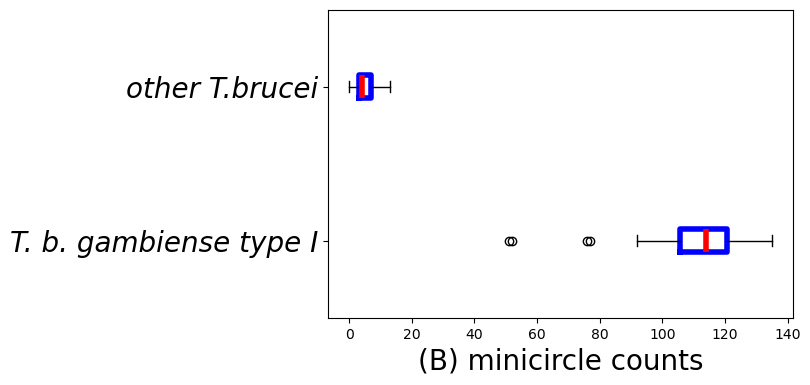

In [17]:
def Tbg1_presence(df):
    df.replace(0, np.nan, inplace=True)
    tbg1=df[df['taxon']=='T.b. gambiense type I']
    nbstrain=len(tbg1)
    a=tbg1.count(axis=0)
    intbg1={k:v for k,v in zip(a.index,a) if k.startswith('Tb_mO_') and v!=0}
    tbg1=tbg1[list(intbg1.keys())]
    #others
    other=df[df['taxon']!='T.b. gambiense type I']
    nbother=len(other)
    other=other[list(intbg1.keys())]
    a=other.count(axis=0)
    numberofmini=other.count(axis=1)
    inother={k:v for k,v in zip(a.index,a) if k.startswith('Tb_mO_')}
    #print(inother,len(inother))
    #plot
    data1=[v/nbstrain*100 for k,v in intbg1.items()]
    data3=[v for v in tbg1.count(axis=1)]
    data2=[v/nbother*100 for k,v in inother.items()]
    data4=[v for v in other.count(axis=1)]
    taxa=['T. b. gambiense type I','other T.brucei']
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), sharey=True)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    #ax.scatter(data2,data1)
    #ax.set_xlim(-10,100)
    #ax.set_ylim(0,100)
    #ax=axs[0]
    ax.boxplot([data3,data4],labels=taxa,vert=False,boxprops=boxprops,medianprops=medianprops)
    ax.set_yticklabels(taxa,fontsize=20,style='italic')
    ax.set_xlabel('(B) minicircle counts',fontsize=20)
    #ax.set_xlabel('(A) Percentage of presence',fontsize=20)
    #ax=axs[1]
    #ax.boxplot([data1,data2],labels=taxa,vert=False,boxprops=boxprops,medianprops=medianprops)
    #
    #ax.set_yticklabels(taxa,fontsize=20,style='italic')
    plt.show()
    
Tbg1_presence(combined)

In [18]:
def stats(d):
    mean=round(sum(d)/len(d),2)
    med=statistics.median(d)
    mod=statistics.mode(d)
    print(f"mean: {mean}, median: {med}, mode: {mod}, max: {max(d)}, min: {min(d)}")
def plot_minicircle_class_network_size(df,feature):
    taxa=['T.b. rhodesiense','T.b. brucei','T.b. gambiense type II','T.b. gambiense type I']
    data=[df[df['taxon']==t][feature] for t in taxa]
    labels=taxa
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4), sharey=False)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    ax.boxplot(data,labels=labels,vert=False,boxprops=boxprops,medianprops=medianprops)
    ax.tick_params(labelsize=20)
    ax.set_yticklabels(labels,style='italic')
    ax.set_xlabel(f'{feature}',fontsize=20)
    plt.show()
    #statistics
    print('levene test for equal variances')
    grouped = df.groupby(['taxon'])
    size_by_group = [g[feature].values for _, g in grouped]
    print(grouped[feature].std().round(1))
    statistic, pvalue = levene(*size_by_group, center='mean')
    #print(f'upper critical value of F_c=F_(0.05, {k-1}, {N-k}) = {f.ppf(1-0.05, k-1, N-k):.2f}')
    print(f'W = {statistic:.2f}, p = {pvalue:.2g}\n')
    for t in taxa:
        n=len(df[df['taxon']==t])
        mean=sum(df[df['taxon']==t][feature])/n
        st=round(statistics.stdev(df[df['taxon']==t][feature]),2)
        print(f"{t}: mean={round(mean,2)} st={st} sample size={n}")
        stats(df[df['taxon']==t][feature])
    pairs=combinations(taxa, 2)
    for p in pairs:
        query=df[df['taxon']==p[0]][feature]
        subject=df[df['taxon']==p[1]][feature]
        a=ttest_ind(subject, query)
        if a.pvalue<1:
            print(f"{p[0]} vs {p[1]}",a.pvalue)

def plot_kDNA_stats_violin(df,feature):
    taxa=['T.b. gambiense type I','T.b. gambiense type II','T.b. brucei','T.b. rhodesiense']
    data={t:df[df['taxon']==t][feature] for t in taxa}
    labels=taxa
    colors={'T.b. gambiense type I':'red','T.b. gambiense type II':'magenta','T.b. brucei':'blue','T.b. rhodesiense':'green'}
    #make violin plot with seaborn
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=False)
    ax = sns.violinplot([data for t,data in data.items()], inner=None,cut=0,palette=colors.values(),orient='h')
    ax=sns.stripplot(data, edgecolor='black', linewidth=1, palette=['white']*len(data) ,orient='h') 
    ax.tick_params(labelsize=20)
    ax.set_yticklabels(colors.keys(),style='italic')
    ax.set_xlabel(f'{feature}',fontsize=20)
    plt.show()
    

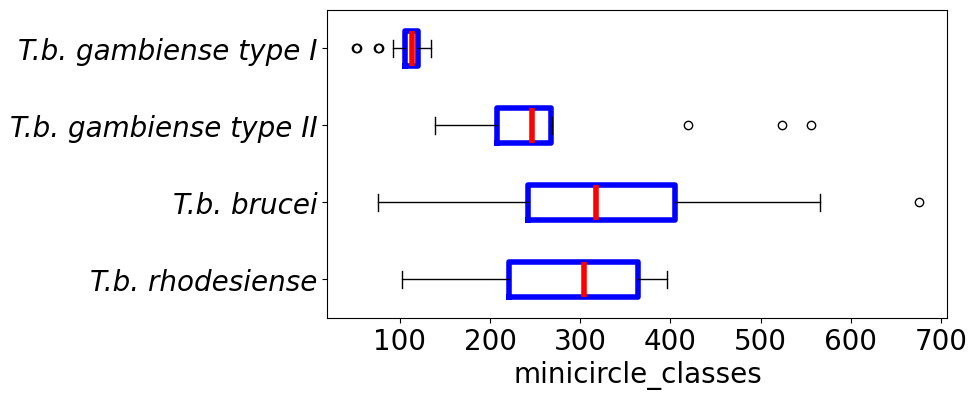

levene test for equal variances
taxon
T.b. brucei               118.2
T.b. gambiense type I      13.5
T.b. gambiense type II    125.8
T.b. rhodesiense           83.8
Name: minicircle_classes, dtype: float64
W = 53.51, p = 5.2e-26

T.b. rhodesiense: mean=287.13 st=83.81 sample size=23
mean: 287.13, median: 304, mode: 330, max: 396, min: 102
T.b. brucei: mean=325.36 st=118.24 sample size=76
mean: 325.36, median: 317.5, mode: 425, max: 676, min: 76
T.b. gambiense type II: mean=283.5 st=125.81 sample size=14
mean: 283.5, median: 246.5, mode: 269, max: 556, min: 139
T.b. gambiense type I: mean=111.51 st=13.46 sample size=111
mean: 111.51, median: 114, mode: 122, max: 135, min: 51
T.b. rhodesiense vs T.b. brucei 0.15246111937342502
T.b. rhodesiense vs T.b. gambiense type II 0.9165350214912081
T.b. rhodesiense vs T.b. gambiense type I 4.344400947916947e-44
T.b. brucei vs T.b. gambiense type II 0.23127959634897485
T.b. brucei vs T.b. gambiense type I 4.6088817703358117e-45
T.b. gambiense type 

/tmp/ipykernel_265/1415865640.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(colors.keys(),style='italic')


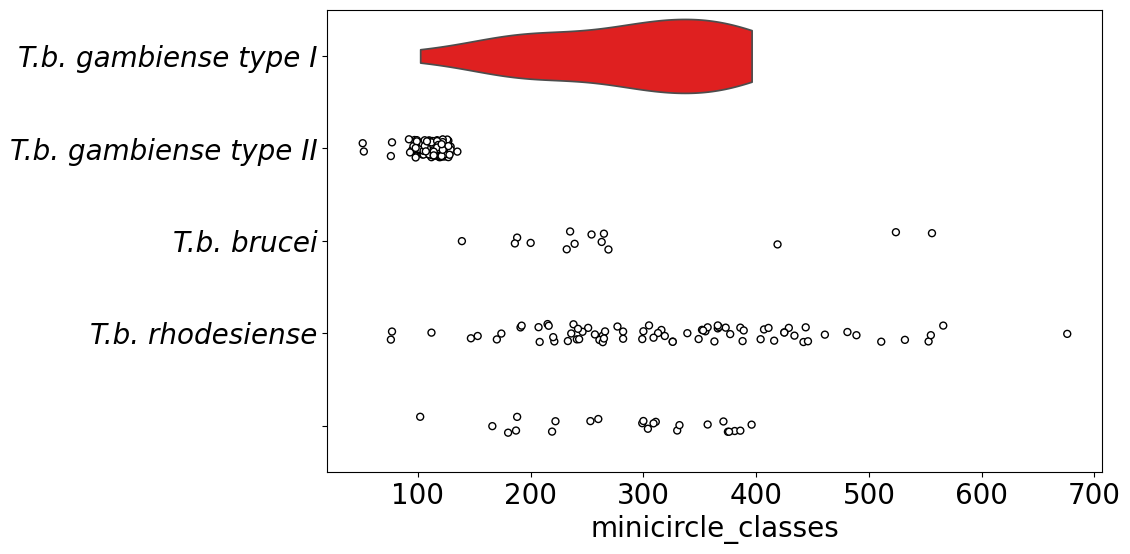

In [19]:
plot_minicircle_class_network_size(combined,'minicircle_classes')
plot_kDNA_stats_violin(combined,'minicircle_classes')


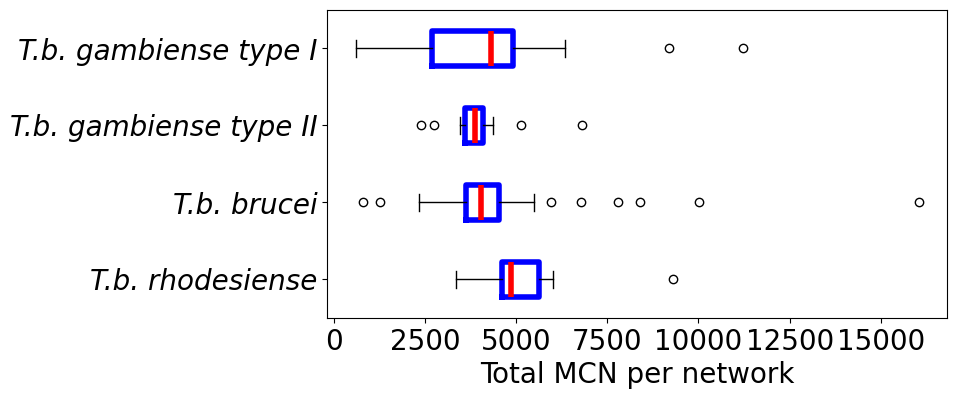

levene test for equal variances
taxon
T.b. brucei               1883.8
T.b. gambiense type I     1706.6
T.b. gambiense type II    1045.8
T.b. rhodesiense          1184.6
Name: Total MCN per network, dtype: float64
W = 2.58, p = 0.054

T.b. rhodesiense: mean=5097.87 st=1184.59 sample size=23
mean: 5097.87, median: 4872.530000000002, mode: 4354.599999999999, max: 9310.039999999999, min: 3364.480000000001
T.b. brucei: mean=4324.79 st=1883.83 sample size=76
mean: 4324.79, median: 4050.915, mode: 3674.4700000000003, max: 16054.319999999992, min: 794.3799999999999
T.b. gambiense type II: mean=3978.44 st=1045.75 sample size=14
mean: 3978.44, median: 3866.2749999999996, mode: 5144.109999999999, max: 6814.050000000007, min: 2405.9500000000007
T.b. gambiense type I: mean=3903.98 st=1706.62 sample size=111
mean: 3903.98, median: 4303.8, mode: 5439.549999999999, max: 11234.109999999999, min: 603.2400000000002
T.b. rhodesiense vs T.b. brucei 0.06643637782097855
T.b. rhodesiense vs T.b. gambiense ty

/tmp/ipykernel_265/1415865640.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(colors.keys(),style='italic')


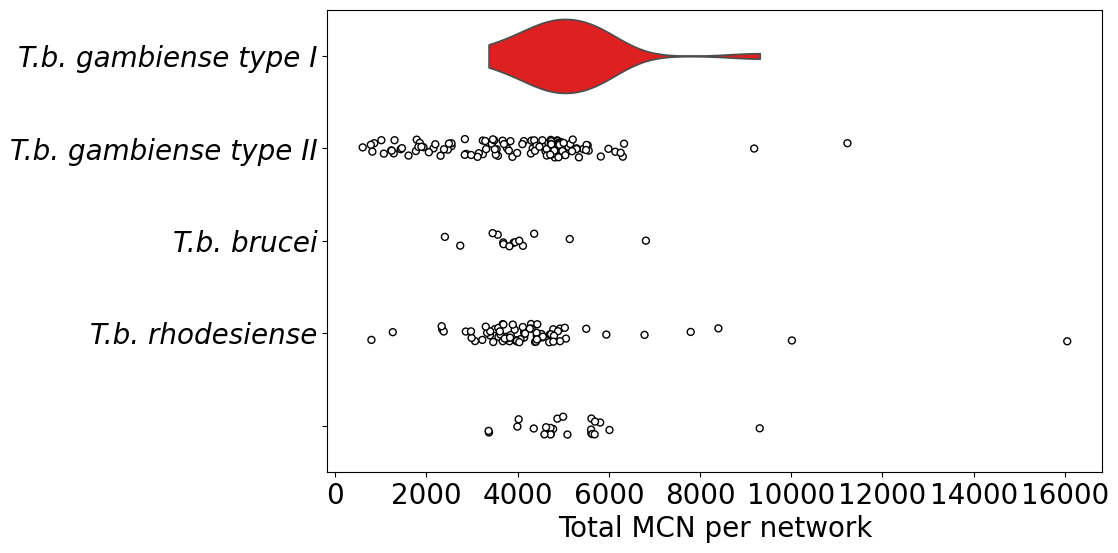

In [20]:
plot_minicircle_class_network_size(combined,'Total MCN per network')
plot_kDNA_stats_violin(combined,'Total MCN per network')

In [21]:
combined[combined['network_size']<=2000]['taxon'].value_counts()
#metadf2['taxon'].value_counts()

taxon
T.b. gambiense type I    19
T.b. brucei               2
Name: count, dtype: int64

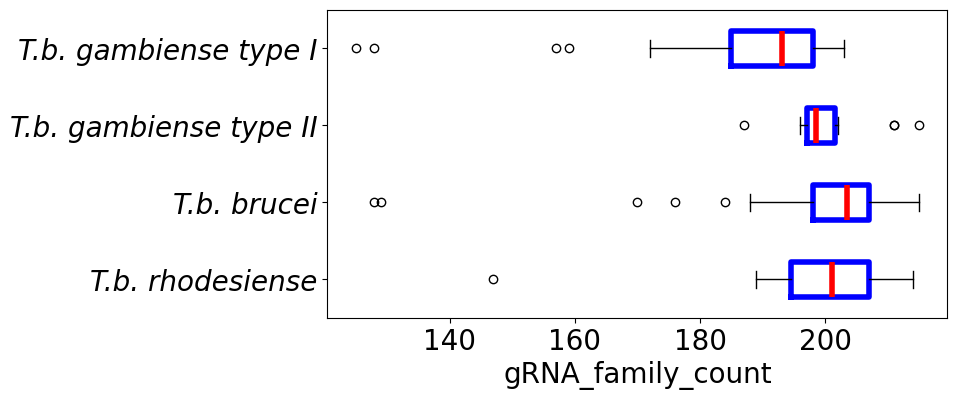

levene test for equal variances
taxon
T.b. brucei               14.4
T.b. gambiense type I     12.4
T.b. gambiense type II     7.3
T.b. rhodesiense          13.2
Name: gRNA_family_count, dtype: float64
W = 0.41, p = 0.75

T.b. rhodesiense: mean=198.96 st=13.19 sample size=23
mean: 198.96, median: 201, mode: 207, max: 214, min: 147
T.b. brucei: mean=200.46 st=14.44 sample size=76
mean: 200.46, median: 203.5, mode: 206, max: 215, min: 128
T.b. gambiense type II: mean=200.5 st=7.31 sample size=14
mean: 200.5, median: 198.5, mode: 200, max: 215, min: 187
T.b. gambiense type I: mean=189.63 st=12.36 sample size=111
mean: 189.63, median: 193, mode: 196, max: 203, min: 125
T.b. rhodesiense vs T.b. brucei 0.6565708758025577
T.b. rhodesiense vs T.b. gambiense type II 0.691238793809191
T.b. rhodesiense vs T.b. gambiense type I 0.0014379230508699927
T.b. brucei vs T.b. gambiense type II 0.9920755980633975
T.b. brucei vs T.b. gambiense type I 1.2992647613058239e-07
T.b. gambiense type II vs T.b. ga

/tmp/ipykernel_265/1415865640.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(colors.keys(),style='italic')


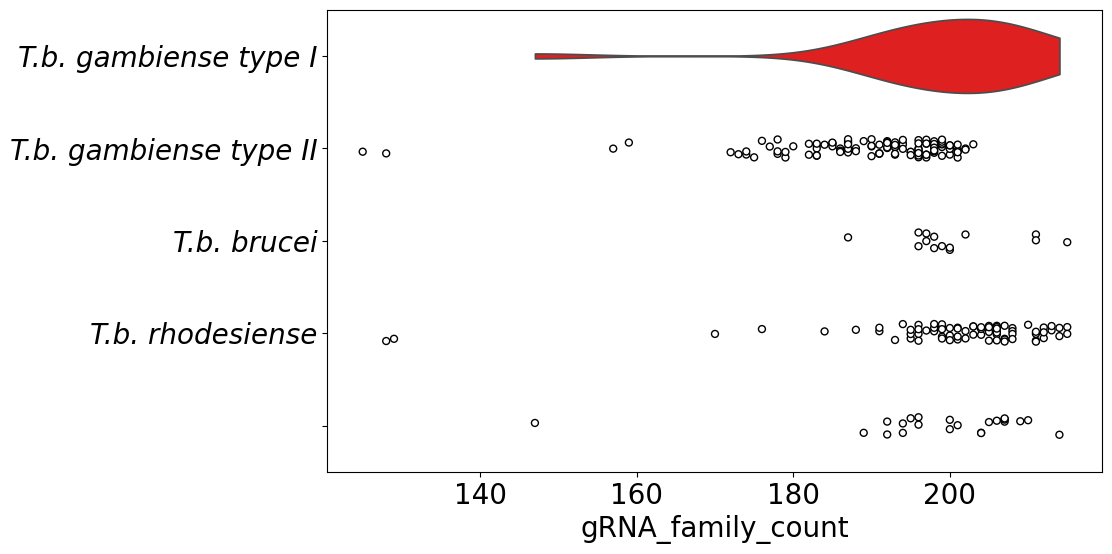

In [22]:
plot_minicircle_class_network_size(combined,'gRNA_family_count')
plot_kDNA_stats_violin(combined,'gRNA_family_count')

In [23]:
tmp={gf:sum([1 for i in strain_gfam_df[gf].isna() if i == False])/224*100 for gf in strain_gfam_df.columns}
high_presence=[k for k,v in tmp.items() if v >= 80 and k != 'taxon']
major_gfam_perc=[len([gf for gf in strain_gfam[strain].keys() if gf in high_presence])/len(strain_gfam[strain])*100 
                 for strain in strain_gfam_df.index]
combined['major gRNA gene percentage']=major_gfam_perc

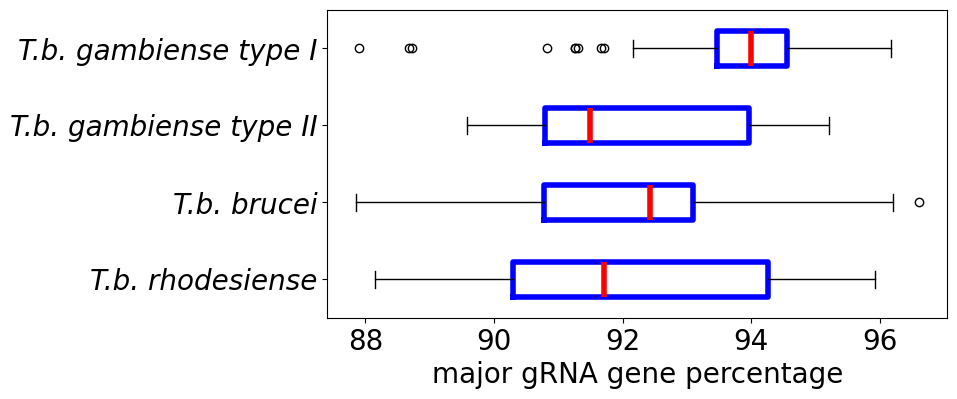

levene test for equal variances
taxon
T.b. brucei               2.1
T.b. gambiense type I     1.3
T.b. gambiense type II    1.9
T.b. rhodesiense          2.5
Name: major gRNA gene percentage, dtype: float64
W = 14.46, p = 1.3e-08

T.b. rhodesiense: mean=92.15 st=2.51 sample size=23
mean: 92.15, median: 91.70731707317074, mode: 91.3265306122449, max: 95.91836734693877, min: 88.15165876777252
T.b. brucei: mean=91.94 st=2.08 sample size=76
mean: 91.94, median: 92.4240491799097, mode: 90.77669902912622, max: 96.61016949152543, min: 87.85046728971963
T.b. gambiense type II: mean=92.16 st=1.95 sample size=14
mean: 92.16, median: 91.48550724637681, mode: 95.2127659574468, max: 95.2127659574468, min: 89.57345971563981
T.b. gambiense type I: mean=93.83 st=1.32 sample size=111
mean: 93.83, median: 94.0, mode: 94.38775510204081, max: 96.17486338797814, min: 87.90697674418605
T.b. rhodesiense vs T.b. brucei 0.6923418110415032
T.b. rhodesiense vs T.b. gambiense type II 0.9881693589259899
T.b. rhode

In [24]:
plot_minicircle_class_network_size(combined,'major gRNA gene percentage')
#plot_kDNA_stats_violin(combined,'major gRNA gene percentage')

In [25]:
#mean gRNA length
data=[int (v['length']) for k,v in gRNA_dict.items()]
m=sum(data)/len(gRNA_dict) 
print(f"mean gRNA length = {m} with sd = {statistics.stdev(data)}")

mean gRNA length = 39.77868613138686 with sd = 5.708513065702685


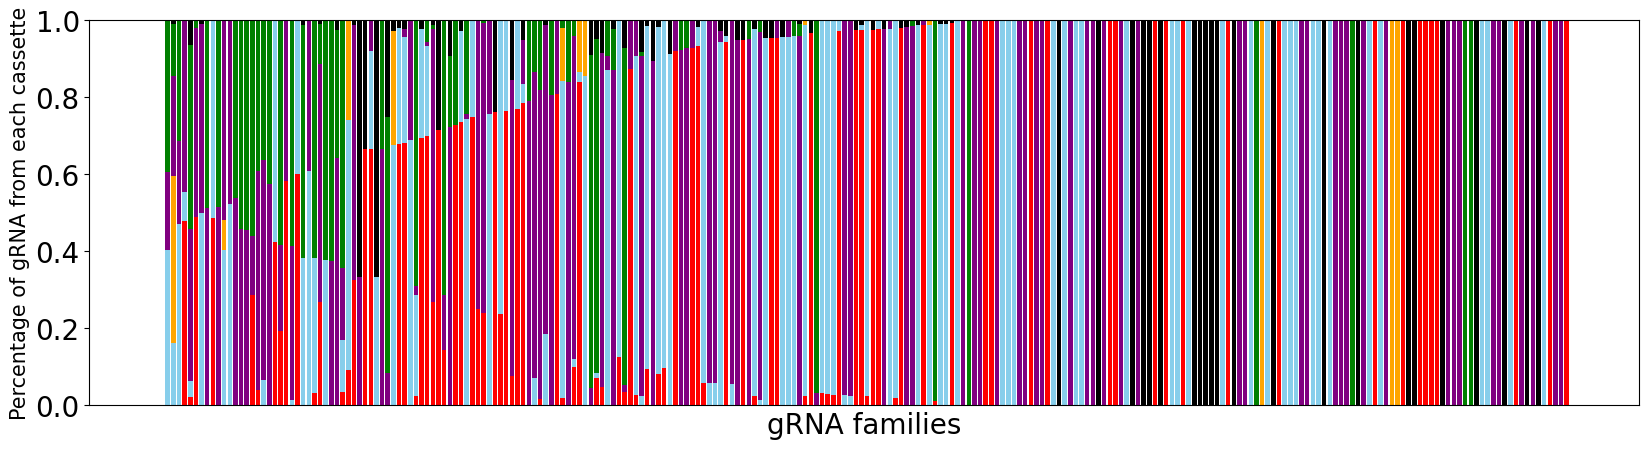

243 gRNA families contained over 50.0% gRNAs from one cassette
226 gRNA families contained over 60.0% gRNAs from one cassette
203 gRNA families contained over 70.0% gRNAs from one cassette
183 gRNA families contained over 80.0% gRNAs from one cassette
162 gRNA families contained over 90.0% gRNAs from one cassette
109 gRNA families contained over 100% gRNAs from one cassette
250 gRNAs were found in 1 isolates
0 gRNAs were found in 2 isolates
0 gRNAs were found in 3 isolates
0 gRNAs were found in 4 isolates
0 gRNAs were found in 5 isolates


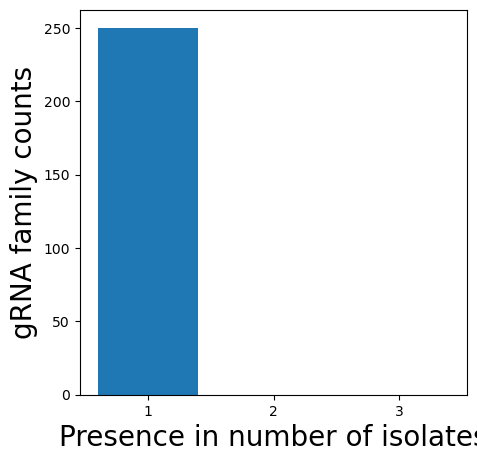

In [26]:
def cassette_distribution(gRNA_families,gRNA_dict,figw=20,figh=5):
    cs,isocounts=['I','II','III','IV','V','Orphan'],[1,2,3,4,5]
    
    gfam={gf:v for k in gRNA_families for gf,v in gRNA_families[k].items()}
    cass={gf:[gRNA_dict[g]['cassette_label'] for g in v['gRNA']] for gf,v in gfam.items()}
    cass={gf: {c: v.count(c)/len(v) for c in cs} for gf,v in cass.items()}
    #sort and put the gRNAs with the least conserved cassettes first
    cass={k:v for k,v in sorted(cass.items(), key=lambda item: max(item[1].values()))}
    df=pd.DataFrame.from_dict(cass, orient='index')
    fig,ax = plt.subplots(1,1,figsize=(figw,figh))
    ax.bar(df.index, (df['I']), label='I',color='r')
    ax.bar(df.index, (df['II']),bottom=(df['I']),label='II',color='skyblue')
    ax.bar(df.index, (df['III']),bottom=(df['I']+df['II']),label='III',color='orange')
    ax.bar(df.index, (df['IV']),bottom=(df['I']+df['II']+df['III']),label='IV',color='purple')
    ax.bar(df.index, (df['V']),bottom=(df['I']+df['II']+df['III']+df['IV']),label='V',color='green')
    ax.bar(df.index, (df['Orphan']),bottom=(df['I']+df['II']+df['III']+df['IV']+df['V']),label='Orphan',color='black')
    ax.set_xticks([])
    ax.set_xlabel('gRNA families',fontsize=20)
    ax.set_ylabel('Percentage of gRNA from each cassette',fontsize=15)
    ax.tick_params(axis='y', labelsize= 20)
    plt.show()
    #some statistics
    casmax={k:max(v.values()) for k,v in cass.items()}
    #all in one cassette
    for cut in [0.5,0.6,0.7,0.8,0.9, 1]:
        s1=[k for k,v in casmax.items() if v>=cut]
        print(f"{len(s1)} gRNA families contained over {cut*100}% gRNAs from one cassette")
    #isolates
    iso={gf: set([g.split('_')[0] for g in v['gRNA']]) for gf,v in gfam.items()}
    data={k:len(v) for k,v in iso.items()}
    for i in isocounts:
        s=list(data.values()).count(i)
        print(f"{s} gRNAs were found in {i} isolates")
        if i==1:
            a=[k for k,v in data.items() if v==1]
            #print(a)
            a={gf: [gRNA_dict[g]['length'] for g in gfam[gf]['gRNA']] for gf in a }
            #print(a)
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    x=[1,2,3]
    ax.bar(x,[list(data.values()).count(i) for i in x])
    ax.set_xticks(x)
    ax.set_xlabel('Presence in number of isolates',fontsize=20)
    ax.set_ylabel('gRNA family counts',fontsize=20)
    plt.show()
    return(df)

cass=cassette_distribution(gRNA_families,gRNA_dict)

In [27]:
#editing block analysis
def editing_block(gRNA_families,gf_presence,mini_presence,high_presence,gRNA_dict,anchorlen=6,figw=20,figh=5):
    taxon_dict={'T.b. gambiense type I':'TbgI','T.b. gambiense type II':'TbgII','T.b. brucei':'Tbb','T.b. rhodesiense':'Tbr',}
    cs,isocounts=['I','II','III','IV','V','Orphan'],[1,2,3,4,5]
    isolates=['T.b. gambiense type I','T.b. gambiense type II','T.b. brucei','T.b. rhodesiense']
    gfam={gf:v for k in gRNA_families for gf,v in gRNA_families[k].items() if gf in high_presence}
    subspecies_mini={s:set([m for m,v in mini_presence.items() if abr in [i.split('_')[0] for i in v]]) for s,abr in taxon_dict.items()}
    ed_blocks={gf:{s:(min([gRNA_dict[g]['mRNA_start'] for g in v['gRNA'] if gRNA_dict[g]['mO_name'] in subspecies_mini[s]]),max([gRNA_dict[g]['mRNA_end']-anchorlen for g in v['gRNA'] if gRNA_dict[g]['mO_name'] in subspecies_mini[s]])) 
                   for s in isolates if gf_presence[s][gf]!=0} 
               for gf,v in gfam.items()}
    startsdiff={gf: max([abs(pair[0]-pair[1]) for pair in combinations([pos[0] for pos in d.values()],2)]) for gf,d in ed_blocks.items() if len(d)>1 }
    endsdiff={gf: max([abs(pair[0]-pair[1]) for pair in combinations([pos[1] for pos in d.values()],2)]) for gf,d in ed_blocks.items() if len(d)>1 }
    data=[list(startsdiff.values()),list(endsdiff.values())]
    labels=['start difference','end difference']
    #basic stats
    for label,d in zip(labels,data):
        print(label)
        mean=round(sum(d)/len(d),2)
        med=statistics.median(d)
        mod=statistics.mode(d)
        print(f"mean: {mean}, median: {med}, mode: {mod}, max: {max(d)}, min: {min(d)}")
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), sharey=False)
    ax = sns.violinplot(data, inner=None,cut=0,orient='h')
    ax=sns.stripplot(data, edgecolor='black', linewidth=1, palette=['white']*len(data) ,orient='h') 
    ax.tick_params(labelsize=20)
    ax.set_yticklabels(labels,style='italic')
    ax.set_xlabel(f'difference (nt)')
    #
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), sharey=False)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    ax.boxplot(data,labels=labels,vert=False,boxprops=boxprops,medianprops=medianprops)
    ax.tick_params(labelsize=20)
    ax.set_yticklabels(labels,style='italic')
    ax.set_xlabel(f'')
    plt.show()
    return(ed_blocks)
def plot_editng_blocks(ed_blocks_by_mrna,filename,exception,figw=100,figh=50,floor=-20,shared_only=False):
    taxon_dict={'T.b. gambiense type I':'red','T.b. gambiense type II':'orange','T.b. brucei':'blue','T.b. rhodesiense':'green'}
    #shape_dict={'IL3000':'o','Kapeya':'v','UPKZN':'s'} #circle,triangle,square
    add_dict={'T.b. gambiense type I':0,'T.b. gambiense type II':-2,'T.b. brucei':-4,'T.b. rhodesiense':-6}
    c,c_dict=0,{'I':'r','II':'skyblue','III':'orange','Orphan':'black'}
    insertions=read_editing_sites(small_u) #1 for insertions
    dels=read_deletion_sites(deletion) #0 for deletion sites
    fig,axs = plt.subplots(len(ed_blocks_by_mrna),1,figsize=(figw,figh))
    for k,v in ed_blocks_by_mrna.items():
        ax,d=axs[c],0
        ax.set_title(f'Editing blocks on {k}',fontdict={'fontsize': 50, 'fontweight': 30})
        c+=1
        #plot init sites
        #ax.plot(range(len(counts[k])),counts[k],label=k)
        ax.set_xlim(left=0,right=len(insertions[k])+60)
        #plot boundaries
        #draw insertion sites: 0 for insertions
        x=[i for i,c in enumerate(insertions[k]) if c!=0 ] 
        y=[d]*len(x)
        ax.scatter(x,y,marker=3,color='purple',linewidth=5)
        d+=-1
        #draw deletions
        x=[i for i,c in enumerate(dels[k]) if c==0 ] 
        y=[d]*len(x)
        ax.scatter(x,y,marker=3,color='red',linewidth=5)
        d+=-1
        #draw gRNA families
        ceiling=d
        if shared_only==False:
            tmp=ed_blocks_by_mrna[k]
        else: #include only gf in all three isolates
            tmp={gf:v for gf,v in ed_blocks_by_mrna[k].items() if len(v)==3 or gf in exception}
        for i,gf in enumerate(tmp):
            if i%2==1:
                d=-4 #alternate starting height
            else:
                d=-12
            ax.text(max([i[1] for i in ed_blocks_by_mrna[k][gf].values()]),d,f"{gf}")
            for s,bound in ed_blocks_by_mrna[k][gf].items():
                ax.add_patch(Rectangle((bound[0], d+add_dict[s]), bound[1]-bound[0], -1,
                              facecolor = taxon_dict[s],alpha=0.6)) #coding region
    plt.savefig(filename)
    plt.show()

def length_of_ed_block_stats(ed_blocks_by_mrna):
    data=[[b[1]-b[0] for gf in v for b in v[gf].values()] for k,v in ed_blocks_by_mrna.items()]
    summary={}
    #basic stats
    for label,d in zip(ed_blocks_by_mrna.keys(),data):
        mean=round(sum(d)/len(d),2)
        med=statistics.median(d)
        mod=statistics.mode(d)
        summary[label]={'mean':mean,'median':med,'mode':mod,'max':max(d),'min':min(d)}
        #print(f"{label} mean: {mean}, median: {med}, mode: {mod}, max: {max(d)}, min: {min(d)}")
    df=pd.DataFrame.from_dict(summary,orient='index')
    print(df)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), sharey=False)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    ax.boxplot(data,labels=ed_blocks_by_mrna.keys(),vert=False,boxprops=boxprops,medianprops=medianprops)
    ax.tick_params(labelsize=20)
    ax.set_yticklabels(ed_blocks_by_mrna.keys(),style='italic')
    ax.set_xlabel(f'Length of effective editing range of gRNA families (nt)',fontsize=25)
    plt.show()
    return(df)
#
def calculate_interval(ed_blocks_by_mrna,exception):
    isolates=['T.b. gambiense type I','T.b. gambiense type II','T.b. brucei','T.b. rhodesiense']
    summary={k:{} for k in ed_blocks_by_mrna}
    for k in ed_blocks_by_mrna:
        tmp=ed_blocks_by_mrna[k]
        for s in isolates:
            starts=[v[s][0] for gf,v in tmp.items() if s in v]
            ends=[v[s][1] for gf,v in tmp.items() if s in v]
            d1=[starts[i+1]-n for i,n in enumerate(starts[:-1])]
            d2=[ends[i+1]-n for i,n in enumerate(ends[:-1])]
            mean=round(sum(d1)/len(d1),2)
            med=statistics.median(d1)
            mod=statistics.mode(d1)
            if len(d1)>2:
                sd=round(statistics.stdev(d1),2)
            else:
                sd=np.nan
            #sts={'mean':mean,'median':med,'mode':mod,'max':max(d1),'min':min(d1)}
            sts=(mean,sd)
            summary[k][s]=sts#
    df=pd.DataFrame.from_dict(summary,orient='index')
    return(df)
            


start difference
mean: 4.0, median: 3, mode: 1, max: 27, min: 0
end difference
mean: 5.24, median: 4, mode: 1, max: 36, min: 0


/tmp/ipykernel_265/3135977766.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels,style='italic')


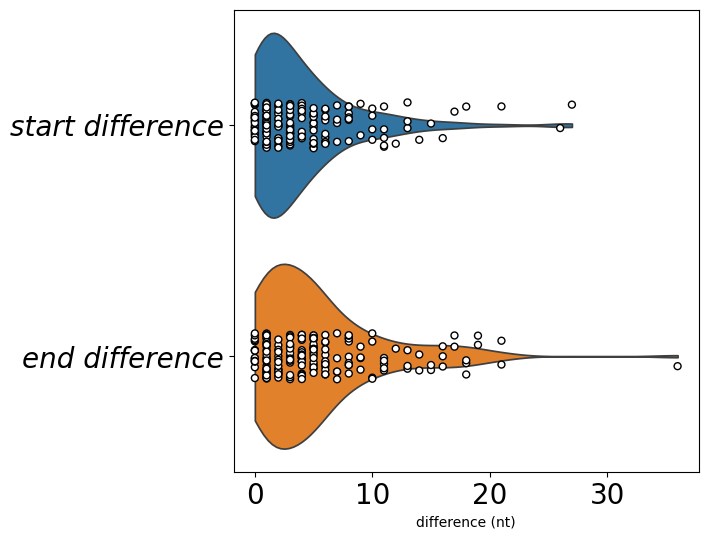

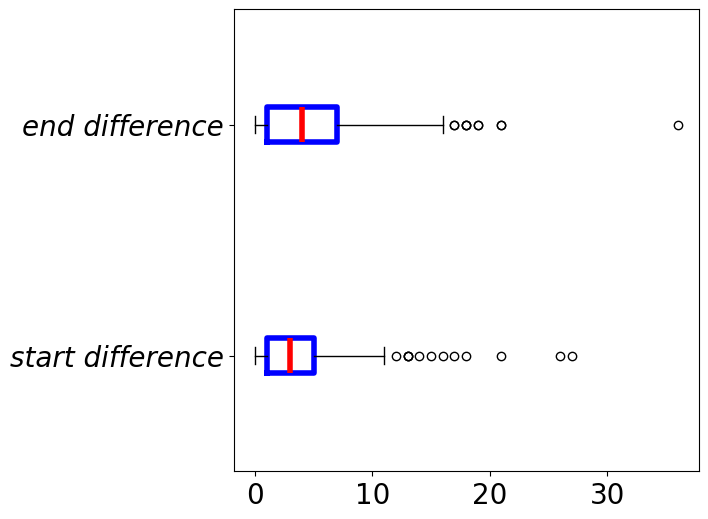

In [28]:
#back to pick up
ed_blocks=editing_block(gRNA_families,gf_presence,mini_presence,high_presence,gRNA_dict,anchorlen=6,figw=20,figh=5)   
ed_blocks_by_mrna={k:{gf:v for gf,v in ed_blocks.items() if k in gf} for k in gRNA_families}
ed_blocks_by_mrna.pop('MURF2')
ed_blocks_by_mrna.pop('COX2')
exception=[]

In [29]:
outdir='/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb'
outfile=f"{outdir}/Effective_editing_range.pdf"
plot_editng_blocks(ed_blocks_by_mrna,outfile,exception,figw=100,figh=100,floor=-20,shared_only=False)

        mean  median  mode  max  min
A6     44.75    42.0    42   80   34
COX3   46.22    45.5    46   65   26
CR3    49.53    48.5    54   64   25
CR4    44.22    42.5    44   63   33
CYB    30.62    28.0    23   40   23
ND3    42.56    42.0    42   57   30
ND7    43.37    42.0    42   76   19
ND8    42.24    42.0    48   59   22
ND9    41.66    41.0    46   67   29
RPS12  44.39    43.5    44   56   31


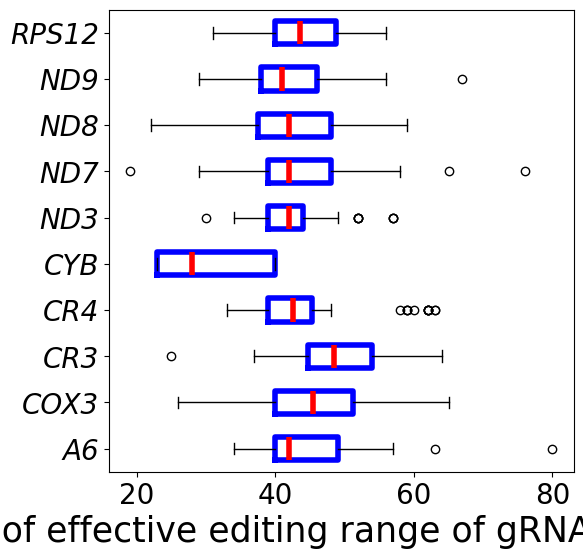

In [30]:
df=length_of_ed_block_stats(ed_blocks_by_mrna)
csv_out=f"{outdir}/editing_block_length_per_mRNA.csv"
df.to_csv(csv_out)

In [31]:
df=calculate_interval(ed_blocks_by_mrna,exception)
csv_out=f"{outdir}/editing_block_interval_per_isolate_per_mRNA.csv"
df.to_csv(csv_out)
print(df)

      T.b. gambiense type I T.b. gambiense type II     T.b. brucei  \
A6             (27.5, 8.83)          (27.5, 10.61)   (27.5, 13.26)   
COX3          (27.03, 8.41)          (27.21, 8.96)   (27.21, 8.85)   
CR3           (31.0, 13.47)         (28.86, 10.93)  (30.71, 11.28)   
CR4           (28.71, 5.38)         (28.65, 10.74)  (28.65, 10.69)   
CYB             (20.0, nan)            (17.0, nan)     (17.0, nan)   
ND3           (31.36, 6.39)          (32.36, 8.41)   (32.18, 8.46)   
ND7           (30.5, 14.85)         (30.53, 15.71)  (30.53, 16.45)   
ND8          (22.85, 10.62)          (22.85, 10.7)  (22.85, 10.48)   
ND9          (31.17, 10.14)          (31.61, 9.99)    (32.0, 9.92)   
RPS12          (32.0, 7.39)           (30.75, 5.7)   (31.12, 5.22)   

      T.b. rhodesiense  
A6       (27.5, 10.77)  
COX3     (27.21, 8.14)  
CR3      (27.71, 13.2)  
CR4      (28.47, 6.17)  
CYB        (17.0, nan)  
ND3      (32.18, 7.76)  
ND7     (30.53, 16.45)  
ND8     (22.85, 10.59)  
ND9 

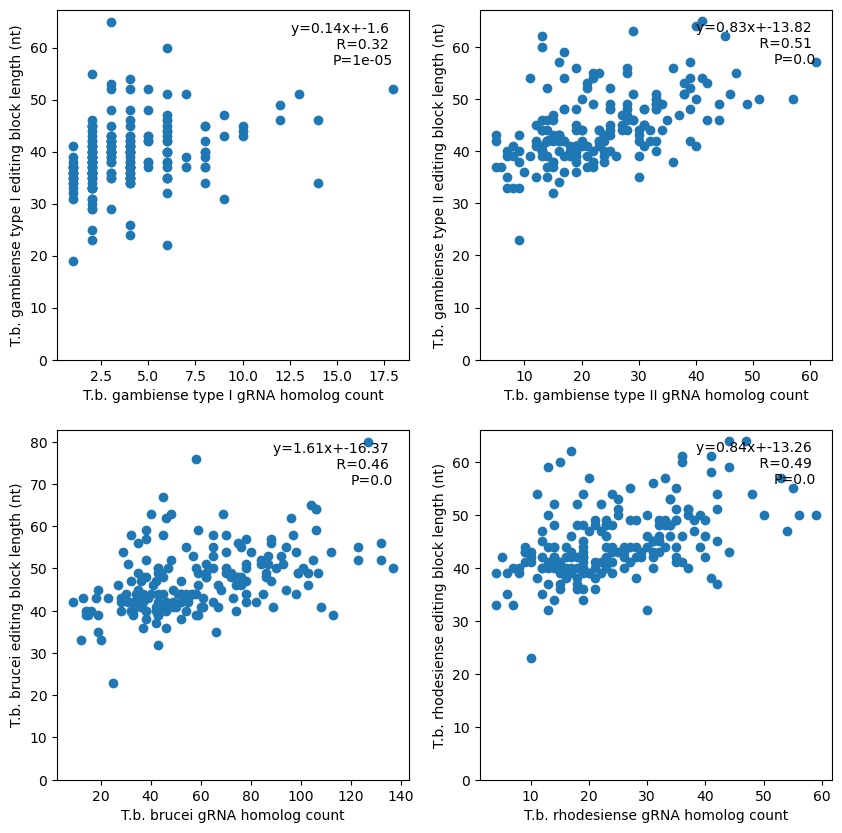

In [32]:
def length_correlation_ed_blocks(gRNA_families,ed_blocks):
    isolates=['T.b. gambiense type I','T.b. gambiense type II','T.b. brucei','T.b. rhodesiense']
    taxon_dict={'T.b. gambiense type I':'TbgI','T.b. gambiense type II':'TbgII','T.b. brucei':'Tbb','T.b. rhodesiense':'Tbr',}
    gfam={gf:v for k in gRNA_families for gf,v in gRNA_families[k].items() if gf in high_presence}
    subspecies_mini={s:set([m for m,v in mini_presence.items() if abr in [i.split('_')[0] for i in v]]) for s,abr in taxon_dict.items()}
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), sharey=False)
    for i,s in enumerate(isolates):
        ax=axs[math.floor(i/2),i%2]
        x=[ed_blocks[gf].get(s,(0,0))[1]-ed_blocks[gf].get(s,(0,0))[0] for gf, v in gfam.items()]
        y=[len([g for g in gfam[gf]['gRNA'] if gRNA_dict[g]['mO_name'] in subspecies_mini[s]]) for gf, v in gfam.items()]
        corr=linregress(x,y)
        ax.scatter(y,x)
        ax.set_ylim(bottom=0)
        ax.set_ylabel(f"{s} editing block length (nt)")
        ax.set_xlabel(f"{s} gRNA homolog count")
        ax.text(max(y),max(x),f"y={round(corr.slope,2)}x+{round(corr.intercept,2)} \n R={round(corr.rvalue,2)} \nP={round(corr.pvalue,5)}",ha='right',va='top')
    plt.show()
            

length_correlation_ed_blocks(gRNA_families,ed_blocks)

In [33]:
#plot %gRNAs
def plot_gRNA_percentage_multi_strain (df_list,strains,width=0.35,figw=20,figh=15,title='Coverage of Editing Sites on mRNA'):
    fig,axs = plt.subplots(1,1,figsize=(figw,figh))
    #start bar plot: editing sites coverage
    x,adj= np.arange(0,len(strains),1)*(width*1.2),0
    for df,strain in zip(df_list,strains):
        total=sum(df['total gRNAs'])
        bttm=0
        for mrna in df.index:
            percent=df.loc[mrna]['total gRNAs']/total*100
            axs.bar(adj, percent, width,bottom=bttm,label=mrna)
            bttm+=percent
        adj+=width*1.2
    #styling
    axs.set_xticks(x)
    axs.set_xticklabels(strains,rotation= 90) # have to do this seperate from set_xticks, otherwise error
    axs.tick_params(axis='x', labelsize= 20)
    axs.tick_params(axis='y', labelsize= 15)
    axs.set_xlabel('mRNAs',fontsize=20)
    axs.set_ylabel('Proportion of predicted gRNAs(%)',fontsize=20)
    axs.set_title(title,fontsize=20) 
    axs.set_facecolor("white")
    #legend
    handles1, labels1 = axs.get_legend_handles_labels()
    by_label = dict(zip(labels1, handles1))
    leg=axs.legend(by_label.values(), by_label.keys(),fontsize=20,bbox_to_anchor=(0.14, -0.15))
    plt.grid(True)
    plt.show()

In [34]:
##
def plot_gRNA_percentage_multi_strain_cpnb(strains,strain_gfam,gRNA_dict,combined,strain_mini_sets,mini_dict,
                                      figw=4,figh=8,width=0.35,title='null'):
    mrnas=['ND8','ND9','ND7','COX3','CYB','A6','CR3','CR4','ND3','RPS12']
    df_list=[]
    for s in strains:
        #consider copy number of gfam
        gf={gf:sum(v.values()) for gf,v in strain_gfam[s].items()} #combine v1 v2
        total=sum(gf.values())
        gf={mrna: round(sum([cp for gf,cp in gf.items() if mrna in gf])/total*100,2) for mrna in mrnas}
        df=pd.DataFrame.from_dict(gf,orient='index')
        df_list.append(df)
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), sharey=False)
    x,adj= np.arange(0,len(strains),1)*(width*1.2),0
    for df,strain in zip(df_list,strains):
        bttm=0
        for mrna in df.index:
            axs.bar(adj, df.loc[mrna], width,bottom=bttm,label=mrna)
            bttm+=df.loc[mrna]
        adj+=width*1.2
    #styling
    axs.set_xticks(x)
    axs.set_xticklabels(strains,rotation= 90) # have to do this seperate from set_xticks, otherwise error
    axs.tick_params(axis='x', labelsize= 20)
    axs.tick_params(axis='y', labelsize= 15)
    axs.set_xlabel('mRNAs',fontsize=20)
    axs.set_ylabel('Proportion of predicted gRNAs(%)',fontsize=20)
    axs.set_title(title,fontsize=20) 
    axs.set_facecolor("white")
    #legend
    handles1, labels1 = axs.get_legend_handles_labels()
    by_label = dict(zip(labels1, handles1))
    leg=axs.legend(by_label.values(), by_label.keys(),fontsize=20,bbox_to_anchor=(0.14, -0.15))
    plt.grid(True)
    plt.show()

13105 594 13699 0.9566391707423899 0.04336082925761005
30 gRNA families are present 
in no more than 10% isolates


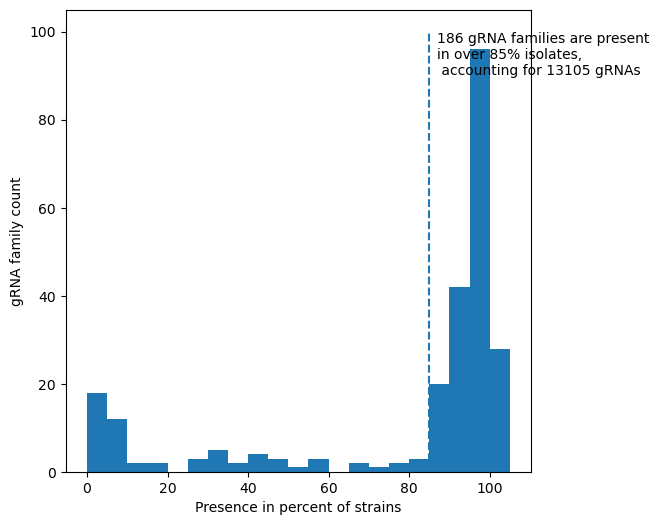

pvalue 0.0 mean major: 69.85, mean minor: 8.3


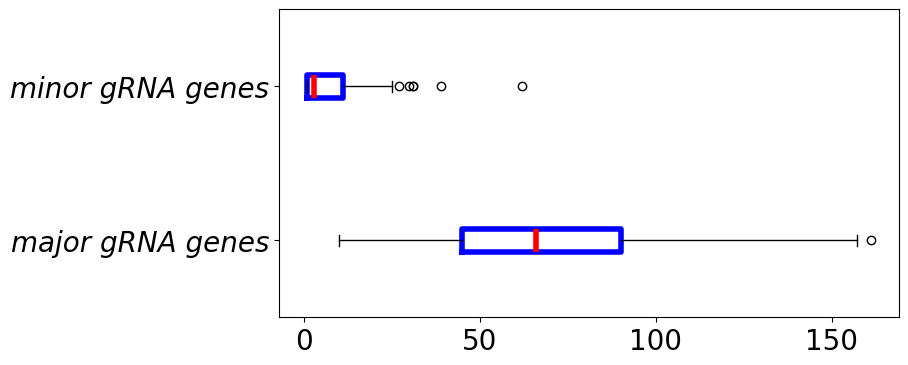

TbgI: null hypothesis rejected in 75 gRNA families, 108 isolates overrepresented in lower 10% of 68 families
TbgI: null hypothesis rejected in 73 gRNA families, 88 isolates overrepresented in top 10% of 59 families
TbgI: null hypothesis rejected in 40 gRNA families, 103 isolates overrepresented in middle 60% of 1 families
111/111 TbgI isolates are overrepresented in top/bottom 10% of 123 gRNA families 

TbgII: null hypothesis rejected in 17 gRNA families, 11 isolates overrepresented in lower 10% of 17 families
TbgII: null hypothesis rejected in 7 gRNA families, 8 isolates overrepresented in top 10% of 7 families
TbgII: null hypothesis rejected in 1 gRNA families, 0 isolates overrepresented in middle 60% of 0 families
11/14 TbgII isolates are overrepresented in top/bottom 10% of 24 gRNA families 

Tbb: null hypothesis rejected in 54 gRNA families, 52 isolates overrepresented in lower 10% of 7 families
Tbb: null hypothesis rejected in 55 gRNA families, 38 isolates overrepresented in top 

In [35]:
#statistics: chi-square: if a taxon is overrepresented in the top/bottom quantile of a gRNA family
def check_gfam_presence(strain_gfam_df,gfam,cutoff=80):
    present={gf:sum([1 for i in strain_gfam_df[gf].isna() if i == False])/224*100 for gf in strain_gfam_df.columns if gf!='taxon'}
    gRNAinmajor=sum([len(gfam[gf]['gRNA']) for gf,v in present.items() if v >=cutoff])
    gRNAinminor=sum([len(gfam[gf]['gRNA']) for gf,v in present.items() if v <cutoff])
    total=gRNAinmajor+gRNAinminor
    print(gRNAinmajor,gRNAinminor,total,gRNAinmajor/total,gRNAinminor/total)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), sharey=False)
    ax.hist(present.values(),bins=range(0,110,5))
    ax.set_xlabel('Presence in percent of strains')
    ax.set_ylabel('gRNA family count')
    ax.vlines(cutoff,0,100,linestyle='dashed')
    ax.text(cutoff+2,100,f"{sum([1 for i in present.values() if i >= cutoff])} gRNA families are present \nin over {cutoff}% isolates,\n accounting for {gRNAinmajor} gRNAs ",
           va='top',ha='left')
    cutoff2=10
    print(f"{sum([1 for i in present.values() if i <= cutoff2])} gRNA families are present \nin no more than {cutoff2}% isolates")
    plt.show()

def compare_gRNA_isotype_number(gRNA_families,strain_gfam_df):
    tmp={gf:sum([1 for i in strain_gfam_df[gf].isna() if i == False])/224*100 for gf in strain_gfam_df.columns}
    high_presence=[k for k,v in tmp.items() if v >= 80 and k not in ['percent of major gRNA','taxon']]
    low_presence=[k for k,v in tmp.items() if v < 80  and k not in ['percent of major gRNA','taxon']]
    data_high=[len(gRNA_families[k]['gRNA']) for k in high_presence]
    data_low=[len(gRNA_families[k]['gRNA']) for k in low_presence]
    a=ttest_ind(data_high, data_low)
    print('pvalue',round(a.pvalue,4),f"mean major: {round(sum(data_high)/len(data_high),2)}, mean minor: {round(sum(data_low)/len(data_low),2)}")
    data=[data_high,data_low]
    labels=['major gRNA genes','minor gRNA genes']
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4), sharey=False)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    ax.boxplot(data,labels=labels,vert=False,boxprops=boxprops,medianprops=medianprops)
    ax.tick_params(labelsize=20)
    ax.set_yticklabels(labels,style='italic')
    plt.show()
            
def check_gRNA_cpnb_distribution(strain_gfam_df,qntl=10,cutoff=80,taxon='TbgI',pv=0.05,ascending=True):
    #print(qntl_c,count,fexp
    #set the cutoff to 80
    sig,enriched,enriched_gf,enriched_isolates=0,0,[],[]
    for gf in strain_gfam_df.columns:
        present=sum([1 for i in strain_gfam_df[gf].isna() if i == False])/224*100
        if present >=cutoff:
            tmp=strain_gfam_df[~strain_gfam_df[gf].isna()][gf]#choose only isolates with that gfam
            #calculate expected frequency
            #find cutoff point for presence
            qntl_c=round(len(tmp)*qntl/100)
            count=sum([1 for idx in tmp.index if idx.startswith(f"{taxon}_")])
            fexp=[qntl_c*i for i in [count/len(tmp),1-count/len(tmp)]]#two frequencies
            tmp=tmp.sort_values(ascending=ascending)
            #bottom qntl_c
            bottom=tmp.iloc[:qntl_c]
            taxon_bottom=sum([1 for idx in bottom.index if idx.startswith(f"{taxon}_")])
            fobs=[taxon_bottom,len(bottom)-taxon_bottom]
            #chi-square stats,digree of freedom = 1
            chi=chisquare(fobs, f_exp=fexp)
            p=chi.pvalue
            if p<=pv:
                sig+=1
                if taxon_bottom>fexp[0]:
                    enriched+=1
                    enriched_gf.append(gf)
                    enriched_isolates+=[idx for idx in bottom.index if idx.startswith(f"{taxon}_")]
    toplower={True:'lower',False:'top'}
    enriched_isolates=set(enriched_isolates)
    print(f"{taxon}: null hypothesis rejected in {sig} gRNA families, {len(enriched_isolates)} isolates overrepresented in {toplower[ascending]} {qntl}% of {enriched} families")
    return(enriched_gf,enriched_isolates)
def check_gRNA_cpnb_distribution_control(strain_gfam_df,qntl=10,cutoff=80,taxon='TbgI',pv=0.05):
    #print(qntl_c,count,fexp
    #set the cutoff to 80
    sig,enriched,enriched_gf,enriched_isolates=0,0,[],[]
    for gf in strain_gfam_df.columns:
        present=sum([1 for i in strain_gfam_df[gf].isna() if i == False])/224*100
        if present >=cutoff:
            tmp=strain_gfam_df[~strain_gfam_df[gf].isna()][gf]#choose only isolates with that gfam, ignore na
            #calculate expected frequency
            #find cutoff point for presence
            qntl_c1=round(len(tmp)*qntl/100)
            qntl_c2=round(len(tmp)*(100-qntl)/100)
            count=sum([1 for idx in tmp.index if idx.startswith(f"{taxon}_")])
            fexp=[(qntl_c2-qntl_c1)*i for i in [count/len(tmp),1-count/len(tmp)]]#two frequencies
            tmp=tmp.sort_values(ascending=True)
            #bottom qntl_c
            bottom=tmp.iloc[qntl_c1:qntl_c2]
            taxon_bottom=sum([1 for idx in bottom.index if idx.startswith(f"{taxon}_")])
            fobs=[taxon_bottom,len(bottom)-taxon_bottom]
            #chi-square stats,digree of freedom = 1
            chi=chisquare(fobs, f_exp=fexp)
            p=chi.pvalue
            if p<=pv:
                sig+=1
                if taxon_bottom>fexp[0]:
                    enriched+=1
                    enriched_gf.append(gf)
                    enriched_isolates+=[idx for idx in bottom.index if idx.startswith(f"{taxon}_")]
    toplower={True:'lower',False:'top'}
    enriched_isolates=set(enriched_isolates)
    print(f"{taxon}: null hypothesis rejected in {sig} gRNA families, {len(enriched_isolates)} isolates overrepresented in middle {100-2*qntl}% of {enriched} families")
    return(enriched_gf,enriched_isolates)
#
#summary
def main(strain_gfam_df,gfam,qntl=10,cutoff=85,pv=0.05):
    check_gfam_presence(strain_gfam_df,gfam,cutoff=cutoff)
    compare_gRNA_isotype_number(gfam,strain_gfam_df)
    gf_enriched={}
    #for taxon in ['TbgI','TbgII','Tbb','Tbr','Tb']:
    for taxon in ['TbgI','TbgII','Tbb','Tbr']:
        #cutoff=60: the gRNA family is present is at least 60% of the isolates,if not present, treat as 0 (if remove fillna then treat as ignored)
        enriched_gf1,enriched_isolates1=check_gRNA_cpnb_distribution(strain_gfam_df,qntl=qntl,cutoff=cutoff,taxon=taxon,pv=pv,ascending=True) #bottom
        enriched_gf2,enriched_isolates2=check_gRNA_cpnb_distribution(strain_gfam_df,qntl=qntl,cutoff=cutoff,taxon=taxon,pv=pv,ascending=False)
        check_gRNA_cpnb_distribution_control(strain_gfam_df,qntl=20,cutoff=80,taxon=taxon,pv=0.05)
        total_gf=set(enriched_gf1).union(set(enriched_gf2))
        #total_gf=set(enriched_gf2)
        gf_enriched[taxon]=total_gf
        total_isolates=enriched_isolates1.union(enriched_isolates2)
        total=[i for i in strain_gfam_df.index if i.startswith(f'{taxon}_')]
        print(f"{len(total_isolates)}/{len(total)} {taxon} isolates are overrepresented in top/bottom {qntl}% of {len(total_gf)} gRNA families \n")
    other_gf,all_gf=set(),set()
    for t,gfset in gf_enriched.items():
        all_gf=all_gf.union(gfset)
        if t !='TbgI':
            other_gf=other_gf.union(gfset)
    #check for TbgI
    fobs=[len(gf_enriched['TbgI']),len(other_gf)]
    fexp=[sum(fobs)*i/224 for i in [111,224-111]]
    chi=chisquare(fobs, f_exp=fexp)
    print(chi.pvalue,len(gf_enriched['TbgI']),len(other_gf),len(all_gf),fexp)
    return(gf_enriched)
gf_enriched=main(strain_gfam_df,gfam,qntl=10,cutoff=85,pv=0.05)
#enriched in top/lower portion of gRNA families: 117 gfam have enriched taxon, test null: f_exp=[i/224*117 for i in [111,224-111]]


In [36]:
def strain_cpnb_quantiles(strain_gfam_df,qntl=10,cutoff=80,taxon='TbgI',pv=0.05):
    gf_qtls={}
    for gf in strain_gfam_df.columns:
        present=sum([1 for i in strain_gfam_df[gf].isna() if i == False])/224*100
        if present >=cutoff and gf not in ['taxon','percent of major gRNA']:
            tmp=strain_gfam_df[~strain_gfam_df[gf].isna()][gf]#choose only isolates with that gfam, ignore na
            tmp=tmp.sort_values(ascending=True)
            #calculate quantils
            try:
                qtls={i:len(tmp[tmp<=i])/len(tmp)*100 for i in range(round(max(tmp)+2))}
                isolate_qtls={t:qtls[round(tmp[t])+1] for t in tmp.index}
                gf_qtls[gf]=isolate_qtls
            except:
                print(f'no quantile for {gf}')
    qtls_df=pd.DataFrame.from_dict(gf_qtls,orient='columns')
    qtls_df['taxon']=strain_gfam_df['taxon']
    return(qtls_df)
#visualize
def plot_strain_cpnb(qtls_df):
    #prepare data
    taxa={'T.b. gambiense type I':'TbgI','T.b. gambiense type II':'TbgII','T.b. brucei':'Tbb','T.b. rhodesiense':'Tbr'}
    data,colors={},{'T.b. gambiense type I':'red','T.b. gambiense type II':'orange','T.b. brucei':'blue','T.b. rhodesiense':'green'}
    for t in taxa.values():
        tmp=qtls_df[qtls_df['taxon']==t]#choose isolates from each subspecies
        data_t=[]
        for c in tmp.columns:
            if c not in ['taxon']:#just remove the 'taxon' colum present in all isolates
                data_t+=list(tmp[~tmp[c].isna()][c])
        data[t]=data_t
    #make violin plot with seaborn
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6), sharey=False)
    ax = sns.violinplot([data for t,data in data.items()], inner=None,cut=0,palette=colors.values(),orient='h')
    #ax=sns.stripplot(data,edgecolor='black', linewidth=1, palette=['white'] * 4,orient='h') #too many dots. hard to interpret
    ax.tick_params(labelsize=20)
    ax.set_yticklabels(colors.keys(),style='italic')
    plt.show()
    return(data)

In [37]:
qtls_df=strain_cpnb_quantiles(strain_gfam_df,qntl=10,cutoff=80,taxon='TbgI',pv=0.05)

In [38]:
#count the number of isolates in the upper and lower 10%
def count_upper_lower(qtls_df,qtl):
    taxa={'T.b. gambiense type I':'TbgI','T.b. gambiense type II':'TbgII','T.b. brucei':'Tbb','T.b. rhodesiense':'Tbr'}
    data,colors={},{'T.b. gambiense type I':'red','T.b. gambiense type II':'orange','T.b. brucei':'blue','T.b. rhodesiense':'green'}
    lowerall=len([qtls_df.loc[s,gf] for s in qtls_df.index for gf in qtls_df.columns if gf !='taxon' and qtls_df.loc[s,gf]<=qtl])
    upperall=len([qtls_df.loc[s,gf] for s in qtls_df.index for gf in qtls_df.columns if gf !='taxon' and qtls_df.loc[s,gf]>=100-qtl])
    for t in taxa.values():
        tmp=qtls_df[qtls_df['taxon']==t]#choose isolates from each subspecies
        lower=len([tmp.loc[s,gf] for s in tmp.index for gf in tmp.columns if gf !='taxon' and tmp.loc[s,gf]<=qtl])
        upper=len([tmp.loc[s,gf] for s in tmp.index for gf in tmp.columns if gf !='taxon' and tmp.loc[s,gf]>=100-qtl])
        data[t]={'lower':lower,'upper':upper}
        #statistics
        #check lower
        fexp=[lowerall*i for i in [len(tmp)/len(qtls_df),1-len(tmp)/len(qtls_df)]]#two frequencies
        fobs=[lower,lowerall-lower]
        chi=chisquare(fobs, f_exp=fexp)
        p=chi.pvalue
        print(f"{t} lower {qtl}%: {lower} observed, {lowerall*len(tmp)/len(qtls_df)} expected, p={p}")
        #check upper
        fexp=[upperall*i for i in [len(tmp)/len(qtls_df),1-len(tmp)/len(qtls_df)]]#two frequencies
        fobs=[upper,upperall-upper]
        chi=chisquare(fobs, f_exp=fexp)
        p=chi.pvalue
        print(f"{t} upper {qtl}%: {upper} observed, {upperall*len(tmp)/len(qtls_df)} expected, p={p}")
    return(data)

In [39]:
counts=count_upper_lower(qtls_df,10)

TbgI lower 10%: 2251 observed, 1716.0401785714287 expected, p=7.164020820870297e-74
TbgI upper 10%: 2542 observed, 2113.4598214285716 expected, p=2.386771883142835e-39
TbgII lower 10%: 196 observed, 216.4375 expected, p=0.15135868588158916
TbgII upper 10%: 150 observed, 266.5625 expected, p=1.662055974775068e-13
Tbb lower 10%: 847 observed, 1174.9464285714287 expected, p=5.553575900707834e-32
Tbb upper 10%: 1067 observed, 1447.0535714285713 expected, p=1.0094679650728068e-34
Tbr lower 10%: 169 observed, 355.57589285714283 expected, p=1.541850919656647e-25
Tbr upper 10%: 506 observed, 437.92410714285717 expected, p=0.0005944040770001199


/tmp/ipykernel_265/1752140678.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(colors.keys(),style='italic')


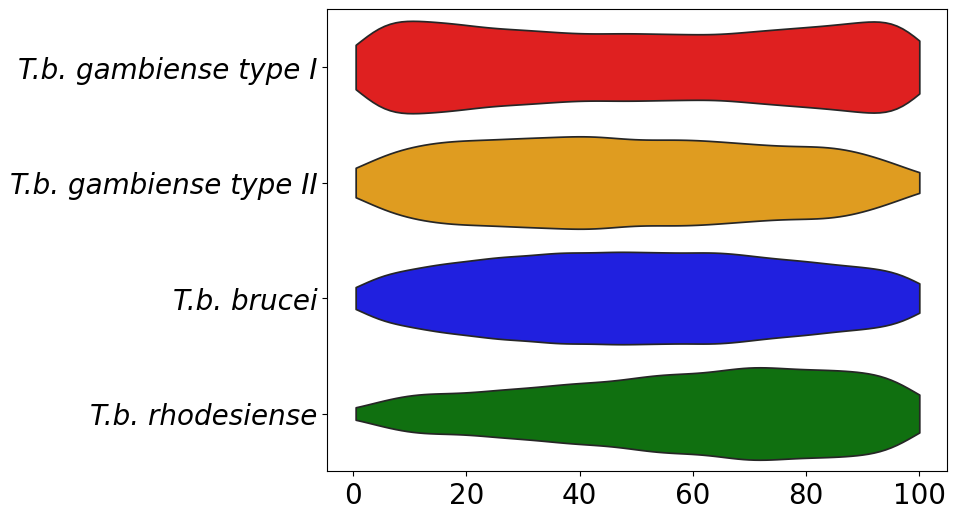

In [40]:
df=plot_strain_cpnb(qtls_df)

In [41]:
tmp={gf:sum([1 for i in strain_gfam_df[gf].isna() if i == False])/224*100 for gf in strain_gfam_df.columns}
high_presence=[k for k,v in tmp.items() if v >= 80 and k != 'taxon']
#strain_gfam_df.loc['TbgI_104AT'].dropna(axis=0, how='all').index

In [42]:
#gRNA family and minicircle family stats
def gRNA_family_stats(gRNA_dict,gRNA_families, figw=25,figh=50): #use the new version
    #presence in multiple cassettes
    x,y,z=[],[],[]
    fig,axs = plt.subplots(2,3,figsize=(figw,figh))
    for k in gRNA_families:
        for f in gRNA_families[k]:
            y.append(len(gRNA_families[k][f]['gRNA']))
            z.append(len(set([gRNA_dict[g]['mO_name'] for g in gRNA_families[k][f]['gRNA']])))
            cst={}
            for g in gRNA_families[k][f]['gRNA']:
                l=gRNA_dict[g]['cassette_label']
                if l not in cst:
                    cst[l]=1
                else:
                    cst[l]+=1
            gRNA_families[k][f]['cassettes']=cst
            x.append(len(cst))
            #if len(cst)>1:
                #print(k,cst)
    ax=axs[0,0]
    ax.hist(x,bins=np.array(range(0,(max(x)+1)*2,1))/2) #np array can be used as a vector
    ax.set_xlabel('presence in number of different cassettes')
    ax.set_ylabel('number of gRNA family')
    #how many gRNAs are in one gRNA fam
    ax=axs[0,1]
    ax.hist(y,bins=np.array(range(0,(max(y)+1)*2,1))/2) #np array can be used as a vector
    ax.set_xlabel('number of gRNAs in each gRNA family')
    ax.set_ylabel('number of gRNA family')
    #how many minicircles contain the same gRNA family
    ax=axs[0,2]
    ax.hist(z,bins=np.array(range(0,(max(z)+1)*2,1))/2) #np array can be used as a vector
    ax.set_xlabel('presence in minicircles')
    ax.set_ylabel('number of gRNA family')
    #how many minicircles families contain the same gRNA family
    ax=axs[1,0]
    mf=[len(gRNA_families[k][gf].get('minicircle_family','n')) for k in gRNA_families for gf in gRNA_families[k]]
    ax.hist(mf,bins=np.array(range(0,(max(mf)+1)*2,1))/2) #np array can be used as a vector
    ax.set_xlabel('presence in minicircles families')
    ax.set_ylabel('number of gRNA family')
    #length distribution of gRNA families (boundary length)
    gflen=[((gRNA_families[k][gf]['bound'][1]-gRNA_families[k][gf]['bound'][0]),len(gRNA_families[k][gf]['cassettes'])) for k in gRNA_families for gf in gRNA_families[k]]
    len_c={i+1:{c:0 for c in [1,2,3,4,5,6]} for i in range(0,(max([i[0] for i in gflen])+1),1)}
    for boundary in gflen:
            for k in len_c:
                if boundary[0]==k:
                    len_c[k][boundary[1]]+=1
    ax=axs[1,1]
    ax.hist([i[0] for i in gflen],bins=np.array(range(0,(max([i[0] for i in gflen])+1),1))) #np array can be used as a vector
    ax.set_xlabel('length of initiation site boundaries')
    ax.set_ylabel('number of gRNA family')
    ax=axs[1,2]
    df=pd.DataFrame.from_dict(len_c,orient='index')
    ax.bar(df.index, (df[1]), label='1',color='blue')
    ax.bar(df.index, (df[2]),bottom=(df[1]),label='2',color='cornflowerblue')
    ax.bar(df.index, (df[3]),bottom=(df[1]+df[2]),label='3',color='dodgerblue')
    ax.bar(df.index, (df[4]),bottom=(df[1]+df[2]+df[3]),label='4',color='steelblue')
    ax.bar(df.index, (df[5]),bottom=(df[1]+df[2]+df[3]+df[4]),label='5',color='skyblue')
    ax.bar(df.index, (df[6]),bottom=(df[1]+df[2]+df[3]+df[4]+df[5]),label='6',color='lightcoral')
    #legend
    handles1, labels1 = ax.get_legend_handles_labels()
    by_label = dict(zip(labels1, handles1))
    leg=ax.legend(by_label.values(), by_label.keys(),fontsize=20,bbox_to_anchor=(0.14, -0.15))
    ax.set_xlabel('initiation site boundary length')
    ax.set_ylabel('number of gRNA families')
    #another figure
    fig,axs = plt.subplots(2,1,figsize=(figw,figh))
    #number of gRNA families for each mRNA,seperated by cassettes
    g_f=[len(gRNA_families[k]) for k in gRNA_families] 
    mrna=[k for k in gRNA_families]
    ax=axs[0]
    ax.bar(mrna,g_f)
    #number of gRNA for each mRNA,seperated by cassettes
    mrna_cst,cassettes={},['I','II','III','IV','V','Orphan']
    for k in gRNA_families:
        mrna_cst[k]={c:0 for c in cassettes}
        for f in gRNA_families[k]:
            for g in gRNA_families[k][f]['gRNA']:
                if gRNA_dict[g]['cassette_label'] in mrna_cst[k]:
                    mrna_cst[k][gRNA_dict[g]['cassette_label']]+=1
    df=pd.DataFrame.from_dict(mrna_cst,orient='index')
    print(df)
    ax=axs[1]
    ax.bar(df.index, (df['I']), label='I',color='blue')
    ax.bar(df.index, (df['II']),bottom=(df['I']),label='II',color='cornflowerblue')
    ax.bar(df.index, (df['III']),bottom=(df['I']+df['II']),label='III',color='dodgerblue')
    ax.bar(df.index, (df['IV']),bottom=(df['I']+df['II']+df['III']),label='IV',color='steelblue')
    ax.bar(df.index, (df['V']),bottom=(df['I']+df['II']+df['III']+df['IV']),label='V',color='skyblue')
    ax.bar(df.index, (df['Orphan']),bottom=(df['I']+df['II']+df['III']+df['IV']+df['V']),label='Orphan',color='lightcoral')
    ax.set_xlabel('mRNAs')
    ax.set_ylabel('number of gRNA')
    #legend
    handles1, labels1 = ax.get_legend_handles_labels()
    by_label = dict(zip(labels1, handles1))
    leg=ax.legend(by_label.values(), by_label.keys(),fontsize=20,bbox_to_anchor=(0.14, -0.15))
    plt.show()

          I   II  III   IV    V  Orphan
A6      411  494   53  748  228      25
COX2      0    0    0    0    0       0
COX3   1171  886   32  639  366      27
CR3     356   51    0  269   34      12
CR4     286  536    0  187    6      33
CYB       0    0    0    0    0      69
MURF2     0    0    0    0    0       0
ND3      34  189   32  189   68       9
ND7     176  854   59  936  489      16
ND8     597  280   20  444   82       4
ND9     255  309    8  340  130      13
RPS12   158  253    0  286   51       1


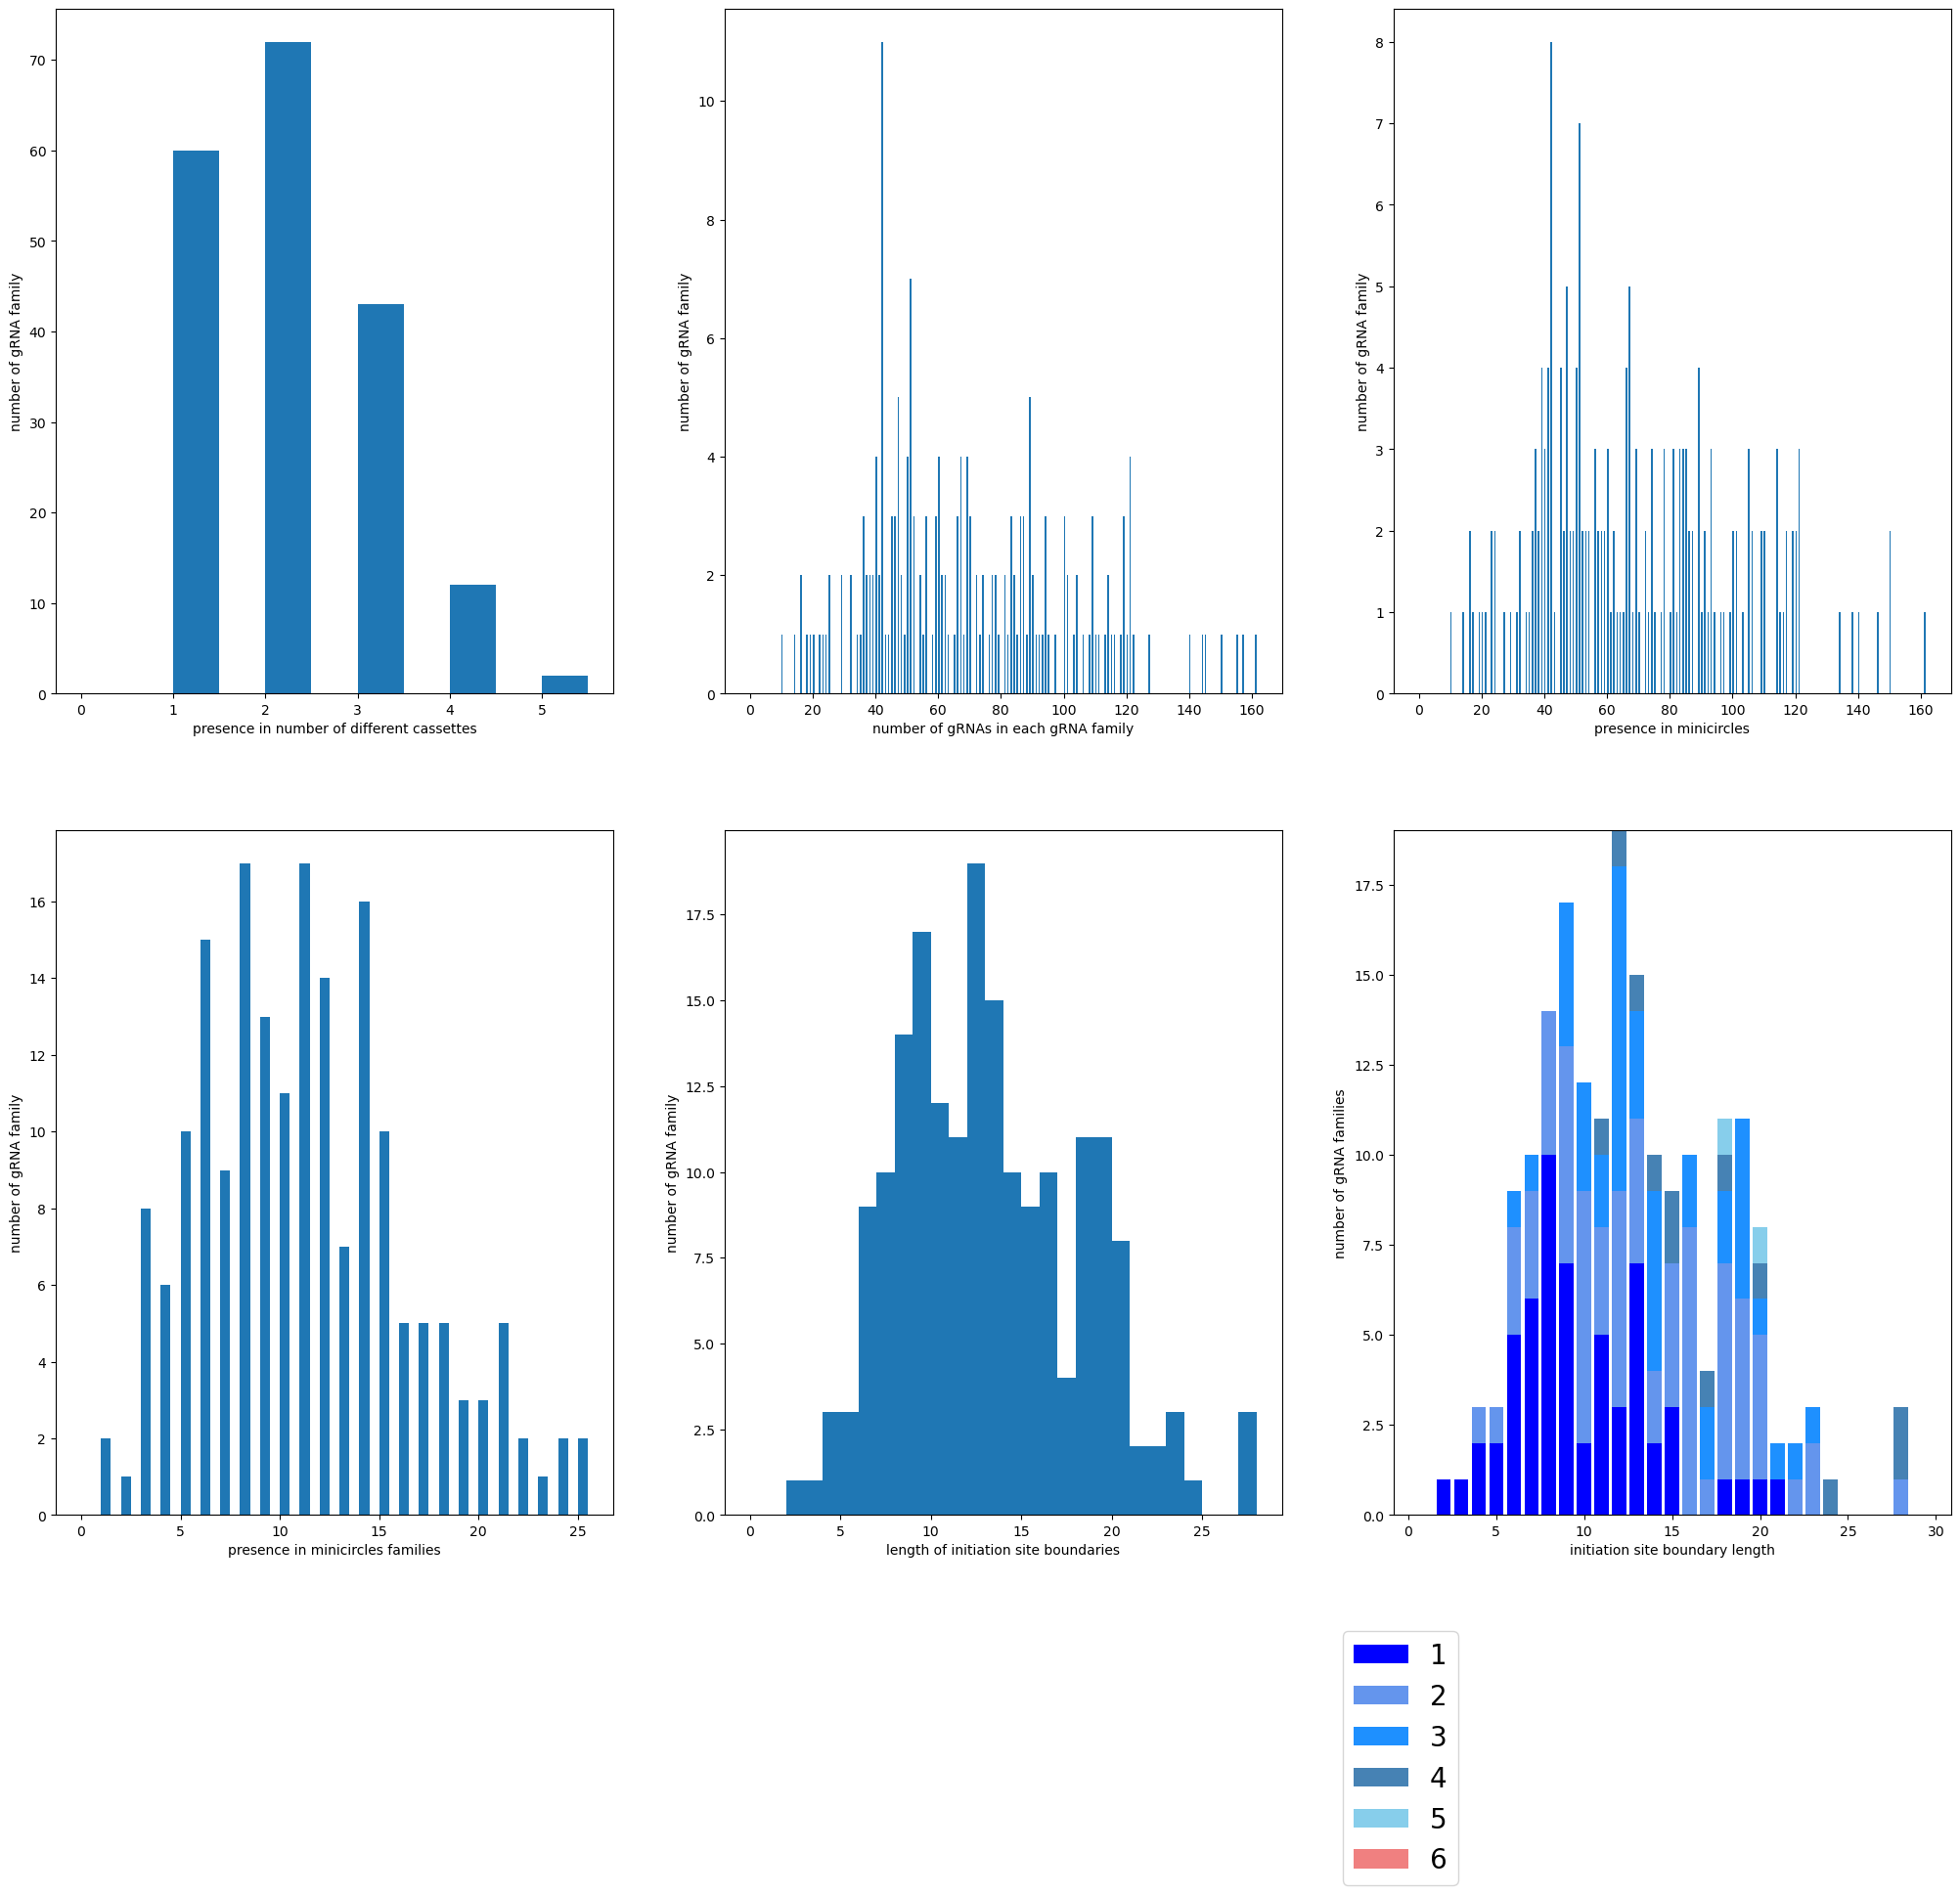

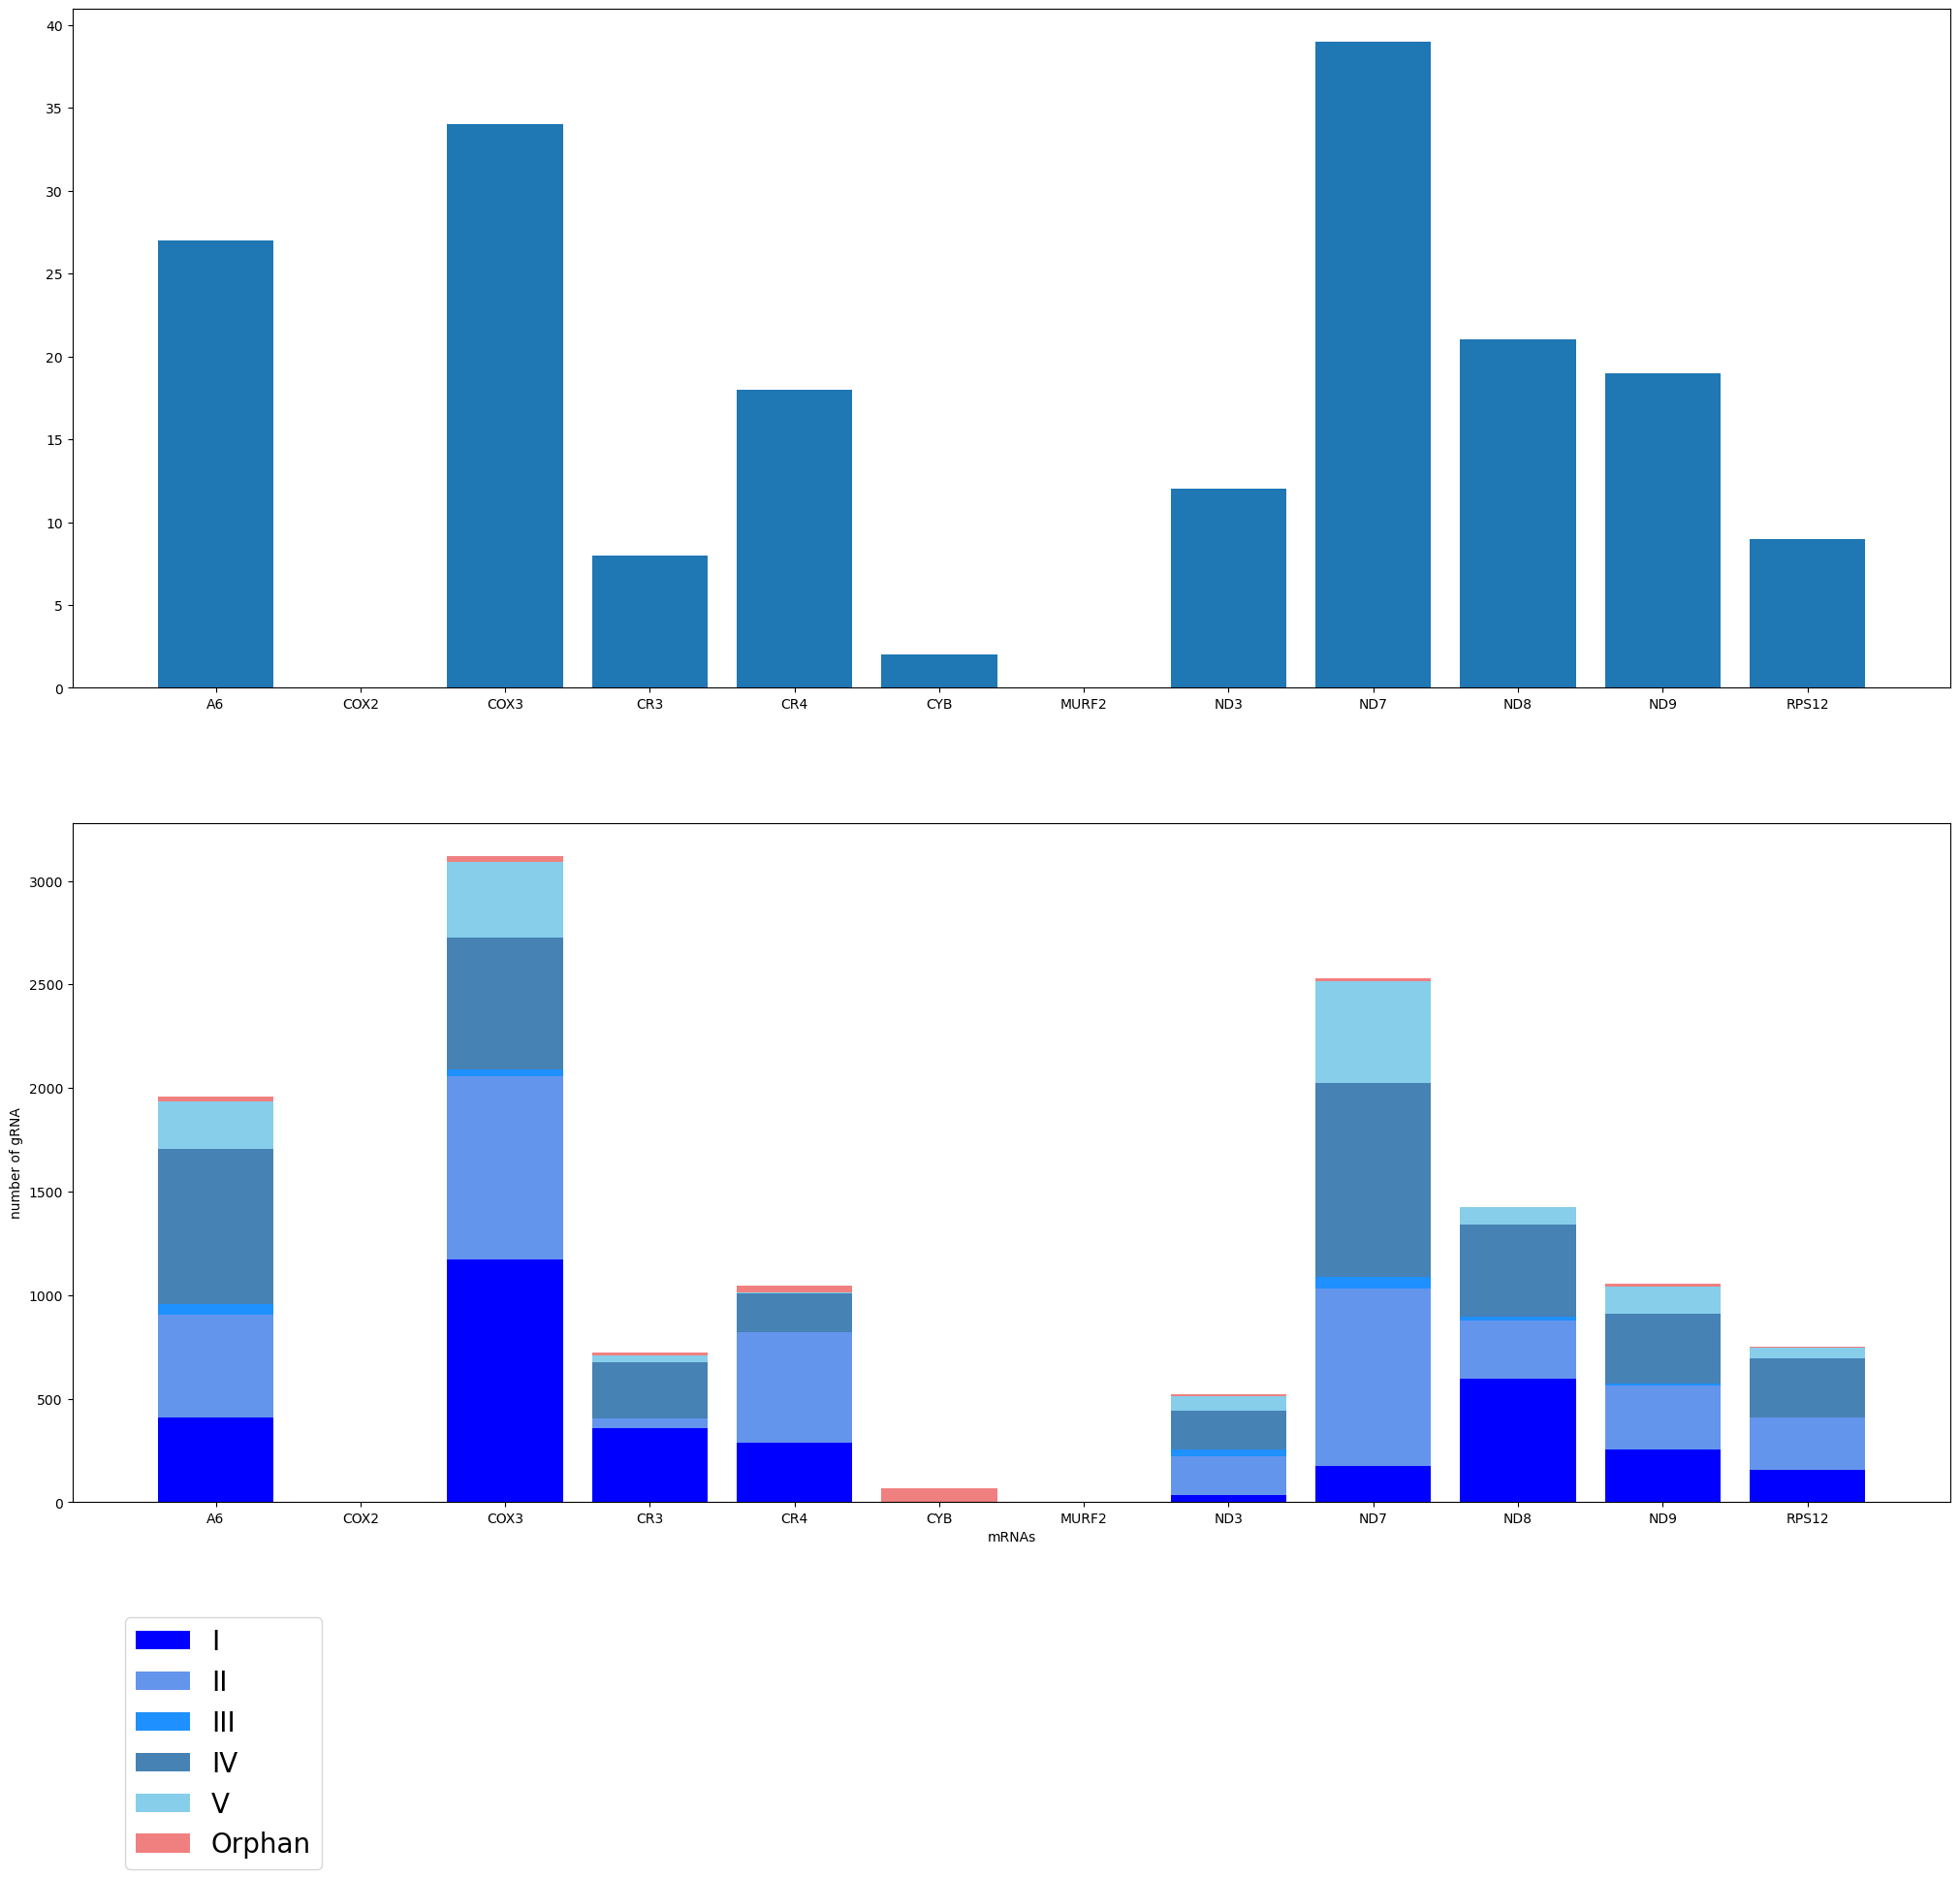

In [43]:
gRNA_fam_major={k:{gf:v for gf,v in gRNA_families[k].items() if gf in high_presence} for k in gRNA_families}
gRNA_family_stats(gRNA_dict,gRNA_fam_major, figw=25,figh=20)

162 249
240 249


/tmp/ipykernel_265/1447152309.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cassettes.keys())


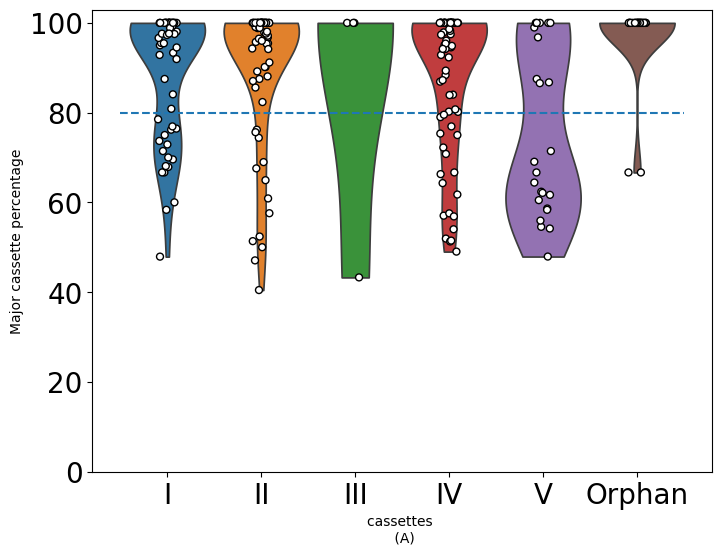

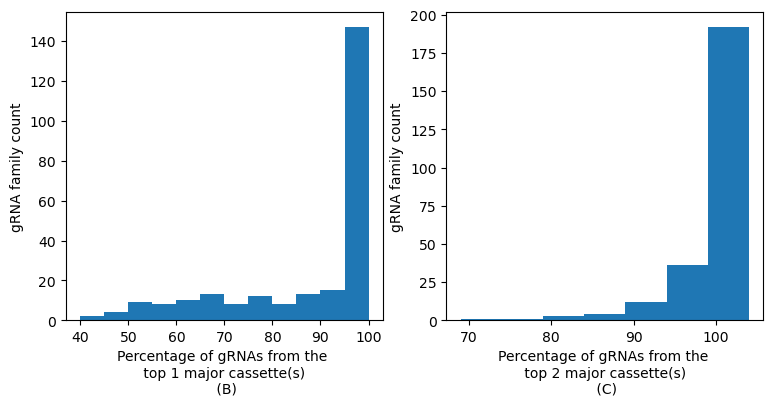

In [44]:
def cassette_stats(gfam):
    cassettes={c:[] for c in ['I','II','III','IV','V','Orphan']}
    for gf in gfam:
        total=sum(gfam[gf]['cassettes'].values())
        if total!=0:
            perc={c:v/total*100 for c,v in gfam[gf]['cassettes'].items()}
            c=max(perc, key=perc.get)
            cassettes[c].append(perc[c])
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6), sharey=False)
    data=[data for t,data in cassettes.items()]
    ax = sns.violinplot(data, inner=None,cut=0)#palette=colors.values(),orient='h')
    ax=sns.stripplot(data,edgecolor='black', linewidth=1, palette=['white'] * len(data)) 
    ax.tick_params(labelsize=20)
    ax.set_xticklabels(cassettes.keys())
    ax.set_ylim(bottom=0)
    ax.set_ylabel(f"Major cassette percentage")
    ax.set_xlabel(f"cassettes \n (A)")
    ax.hlines(80,-0.5,5.5,linestyle='dashed')
    #plt.show()
    #another
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), sharey=False)
    for i,j in zip([0,1],['B','C']):
        top2,ax=[],axs[i]
        for gf in gfam:
            total=sum(gfam[gf]['cassettes'].values())
            if total!=0:
                perc=[v/total*100 for c,v in gfam[gf]['cassettes'].items()]
                perc.sort(reverse=True)
                top2.append(sum(perc[:i+1]))
        ax.hist(top2,bins=range(round(min(top2)),105,5))
        ax.set_xlabel(f"Percentage of gRNAs from the \n top {i+1} major cassette(s) \n ({j})")
        ax.set_ylabel(f"gRNA family count")
        print(len([i for i in top2 if i >= 90]),len(top2))
    plt.show()

cassette_stats(gfam)

In [45]:
def check_editing_sites_coverage(gRNA_by_mini,combined,small_u,anchor=6):
    #to_plot=[['A6_v1', 'A6_v2','COX3', 'CR3', 'CR4', 'CYB'],['ND3','ND7', 'ND8_v1', 'ND8_v2', 'ND9', 'RPS12']]
    to_plot=[['A6','COX3', 'CR3', 'CR4', 'CYB'],['ND3','ND7', 'ND8', 'ND9', 'RPS12']]
    insertions=read_editing_sites(small_u)
    total_gaps={m:sum(insertions[m]) for m in insertions}
    missed_es={}
    for s in combined.index:
        insertions=read_editing_sites(small_u)
        minis=[i for i in combined.loc[s,combined.loc[s].notnull()].index if 'Tb_mO' in i]
        for mini in minis:
            if mini in gRNA_by_mini:
                for v in gRNA_by_mini[mini]:
                    coverage=(int(v['mRNA_start']),int(v['mRNA_end'])-anchor)
                    mrna=v['mRNA_name']
                    for i in range(coverage[0],min(coverage[1],len(insertions[mrna]))):
                        insertions[mrna][i]=0 #set insertions to 0
        gaps={m:sum(insertions[m]) for m in insertions}
        coverage={m:round((1-sum(insertions[m])/total_gaps[m])*100,2) for m in insertions}
        missed_es[s]=coverage
    df=pd.DataFrame.from_dict(missed_es,orient='index')
    df['taxon']=[i.split('_')[0] for i in df.index]
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 20), sharey=False)
    #labels=list(sorted(set(df['taxon'])))
    labels=['TbgI','TbgII','Tbb','Tbr']
    for i in range(5):
        for j in range(2):
            data=[df[df['taxon']==t][to_plot[j][i]] for t in labels]
            boxprops = dict(linestyle='-', linewidth=2, color='b')
            medianprops = dict(linestyle='-', linewidth=2, color='r')
            #ax.boxplot(data,labels=labels,vert=False,boxprops=boxprops,medianprops=medianprops)
            axs[i,j].boxplot(data,labels=labels,showmeans=True, meanline=True,boxprops=boxprops,medianprops=medianprops)
            axs[i,j].set_xlabel(to_plot[j][i])
            axs[i,j].set_ylabel('Percentage of covered editing sites')
            axs[i,j].hlines(95,0.5,5.5,linestyles='dashed')
            axs[i,j].hlines(90,0.5,5.5,linestyles='dashed')
            axs[i,j].set_ylim(top=110)
    plt.show()
    return(df)
            
def check_gRNA_coverage_with_subset(gRNA_by_mini,combined,strain_gfam_df,small_u,anchor=6):
    to_plot=[['A6','COX3', 'CR3', 'CR4', 'CYB'],['ND3','ND7', 'ND8', 'ND9', 'RPS12']]
    tmp={gf:sum([1 for i in strain_gfam_df[gf].isna() if i == False])/224*100 for gf in strain_gfam_df.columns}
    high_presence=[k for k,v in tmp.items() if v >= 80]#use only gRNA family with high presence
    insertions=read_editing_sites(small_u)
    total_gaps={m:sum(insertions[m]) for m in insertions}
    missed_es={}
    for s in combined.index:
        insertions=read_editing_sites(small_u)
        minis=[i for i in combined.loc[s,combined.loc[s].notnull()].index if 'Tb_mO' in i]
        for mini in minis:
            if mini in gRNA_by_mini:
                for v in gRNA_by_mini[mini]:
                    if v.get('gRNA_family',['NA'])[0] in high_presence:
                        coverage=(int(v['mRNA_start']),int(v['mRNA_end'])-anchor)
                        mrna=v['mRNA_name']
                        for i in range(coverage[0],min(coverage[1],len(insertions[mrna]))):
                            insertions[mrna][i]=0 #set insertions to 0
        gaps={m:sum(insertions[m]) for m in insertions}
        coverage={m:round((1-sum(insertions[m])/total_gaps[m])*100,2) for m in insertions}
        missed_es[s]=coverage
    df=pd.DataFrame.from_dict(missed_es,orient='index')
    df['taxon']=[i.split('_')[0] for i in df.index]
    fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(15, 20), sharey=False)
    labels=list(sorted(set(df['taxon'])))
    for i in range(5):
        for j in range(2):
            data=[df[df['taxon']==t][to_plot[j][i]] for t in labels]
            axs[i,j].boxplot(data,labels=labels,showmeans=True, meanline=True)
            axs[i,j].set_xlabel(to_plot[j][i])
            axs[i,j].set_ylabel('Percentage of covered editing sites')
            axs[i,j].hlines(80,0.5,5.5,linestyles='dashed')
            axs[i,j].hlines(90,0.5,5.5,linestyles='dashed')
            axs[i,j].set_ylim(top=110)
    plt.show()
    return(df)

#frequency of editing site coverage
def freq_editing_site_coverage(gRNA_by_mini,combined,small_u,anchor=6):
    #v1_unique=['ND8_v1-402_407','ND8_v1-542_546','A6_v1-799_801']
    #to_plot=[['A6_v1', 'A6_v2','COX3', 'CR3', 'CR4', 'CYB'],['ND3','ND7', 'ND8_v1', 'ND8_v2', 'ND9', 'RPS12']]
    es={}
    for s in combined.index:
        insertions=SeqIO.to_dict(SeqIO.parse(small_u,'fasta'))
        insertions={k:v.seq.replace('-','') for k,v in insertions.items()}
        insertions={k:[0 if i=='u' else 1 for i in v] for k,v in insertions.items()}
        #insertions={k:[0 if i==1 else 0 for i in v] for k,v in insertions.items()} #insertions are 0
        minis=[i for i in combined.loc[s,combined.loc[s].notnull()].index if 'Tb_mO' in i]
        for mini in minis:
            if mini in gRNA_by_mini: #if the minicircle contains canonical gRNAs
                for v in gRNA_by_mini[mini]:
                    coverage=(int(v['mRNA_start']),int(v['mRNA_end'])-anchor)
                    mrna=v['mRNA_name']
                    for i in range(coverage[0],min(coverage[1],len(insertions[mrna]))):
                        insertions[mrna][i]+=1 #+1 if the base is covered by gRNA
                    #take care of the shared gRNAs for alternatively editing mRNAs
        es['_'.join(s.split('_')[1:])]=insertions #use only the strain name, not the renamed version
    dfs={mrna:pd.DataFrame.from_dict({s:es[s][mrna] for s in es},orient='index') for mrna in insertions}
    return(dfs)

def plot_freq_es_coverage(metadf2,dfs,small_u,figsize=(30, 20)):
    colors={'T.b. gambiense type I':'red','T.b. gambiense type II':'orange','T.b. brucei':'blue','T.b. rhodesiense':'green'}
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=figsize, sharey=False)
    #to_plot=[['A6_v1', 'A6_v2','COX3', 'CR3', 'CR4', 'CYB'],['ND3','ND7', 'ND8_v1', 'ND8_v2', 'ND9', 'RPS12']]
    to_plot=[['A6','COX3', 'CR3', 'CR4', 'CYB'],['ND3','ND7', 'ND8', 'ND9', 'RPS12']]
    smallu=SeqIO.to_dict(SeqIO.parse(small_u,'fasta'))
    for i in range(2):
        for j in range(5):
            ax=axs[j,i]
            mrna=to_plot[i][j]
            adj,ticks=0,[]
            for t,c in colors.items():
                tmp=dfs[mrna].loc[metadf2[metadf2['taxon']==t].index]
                total=len(tmp)
                edi_coverage=[round(list(tmp[i]).count(0)/total*100,2)+adj for i,j in zip(tmp.columns,smallu[mrna])]
                ax.plot(range(len(edi_coverage)),edi_coverage,color=c)
                ticks.append(adj)
                adj+=100
            ax.set_ylim(bottom=0,top=adj)
            ax.set_xlabel(mrna,fontsize=20)
            ax.tick_params(labelsize=20)
            ax.set_yticks(ticks,colors.keys(),style='italic')
    plt.show()

def plot_coverage_depth(metadf2,dfs,insertions,figsize=(30, 20)): #method 1: each data point is an uridine insertion
    taxa=['T.b. gambiense type I','T.b. gambiense type II','T.b. brucei','T.b. rhodesiense']
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=figsize, sharey=False)
    to_plot=[['A6','COX3', 'CR3', 'CR4', 'CYB'],['ND3','ND7', 'ND8', 'ND9', 'RPS12']]
    for i in range(2):
        for j in range(5):
            ax=axs[j,i]
            mrna,data=to_plot[i][j],{}
            print(mrna)
            for t in taxa:
                tmp=dfs[mrna].loc[metadf2[metadf2['taxon']==t].index]
                total=len(tmp)
                #average depth at each u insertion, averaged over isolates of asubspecies
                avg_depth=[round(sum(tmp[i])/total,2) for i,j in zip(tmp.columns,insertions[mrna]) if j==1] 
                data[t]=avg_depth
            #ax.plot(range(len(edi_coverage)),edi_coverage)
            #ax = sns.violinplot(data, inner=None,cut=0)#palette=colors.values(),orient='h')
            #ax=sns.stripplot(data,edgecolor='black', linewidth=1, palette=['white'] * len(data)) 
            boxprops = dict(linestyle='-', linewidth=4, color='b')
            medianprops = dict(linestyle='-', linewidth=4, color='r')
            ax.boxplot(data.values(),labels=taxa,vert=False,boxprops=boxprops,medianprops=medianprops)
            ax.tick_params(labelsize=20)
            ax.set_yticklabels(taxa,style='italic')
            ax.set_xlabel(f'{mrna} unique gRNA count')
            pairs=combinations(taxa, 2)
            for p in pairs:
                query=data[p[0]]
                subject=data[p[1]]
                a=ttest_ind(subject, query)
                if a.pvalue<0.05:
                    meanq=sum(data[p[0]])/len(data[p[0]])
                    means=sum(data[p[1]])/len(data[p[1]])
                    print(f"{p[0]} {meanq} vs {p[1]} {means} {a.pvalue}")        
    plt.show()

#method 2: taking average coverage for all u insertions of an isolate, each datapoint is a sample
def plot_coverage_depth2(metadf2,dfs,insertions,figsize=(30, 20)): 
    taxa=['T.b. gambiense type I','T.b. gambiense type II','T.b. brucei','T.b. rhodesiense']
    meandiff=[]
    fig, axs = plt.subplots(nrows=6, ncols=2, figsize=figsize, sharey=False)
    to_plot=[['A6','COX3', 'CR3', 'CR4', 'CYB'],['ND3','ND7', 'ND8', 'ND9', 'RPS12']]
    for i in range(2):
        for j in range(5):
            ax=axs[j,i]
            mrna,data=to_plot[i][j],{}
            print(mrna)
            ucount=insertions[mrna].count(1)#count the number of U insertions
            for t in taxa:
                tmp=dfs[mrna].loc[metadf2[metadf2['taxon']==t].index]
                total=len(tmp)
                #average depth for each sample
                avg_depth=[sum([tmp.loc[s,i] for i,j in zip(tmp.columns,insertions[mrna]) if j==1])/ucount for s in tmp.index]
                data[t]=avg_depth
            #ax.plot(range(len(edi_coverage)),edi_coverage)
            #ax = sns.violinplot(data, inner=None,cut=0)#palette=colors.values(),orient='h')
            #ax=sns.stripplot(data,edgecolor='black', linewidth=1, palette=['white'] * len(data)) 
            boxprops = dict(linestyle='-', linewidth=4, color='b')
            medianprops = dict(linestyle='-', linewidth=4, color='r')
            ax.boxplot(data.values(),labels=taxa,vert=False,boxprops=boxprops,medianprops=medianprops)
            ax.tick_params(labelsize=20)
            ax.set_yticklabels(taxa,style='italic',fontsize=30)
            ax.set_xlabel(f'{mrna} unique gRNA counts',fontsize=40)
            ax.tick_params(axis='x', which='major', labelsize=30)
            pairs=combinations(taxa, 2)
            for p in pairs:
                query=data[p[0]]
                subject=data[p[1]]
                a=ttest_ind(subject, query)
                if a.pvalue<0.05:
                    meanq=sum(data[p[0]])/len(data[p[0]])
                    medq=statistics.median(data[p[0]])
                    means=sum(data[p[1]])/len(data[p[1]])
                    meds=statistics.median(data[p[1]])
                    print(f"{p[0]} {meanq} vs {p[1]} {means} {a.pvalue}")     
                    meandiff.append(abs(medq-meds))
    print(min(meandiff),max(meandiff),sum(meandiff)/len(meandiff))      
    plt.show()

#line plot with error bar
def plot_coverage_depth_line(metadf2,dfs,insertions,figsize=(30, 20)): 
    colors={'T.b. gambiense type I':'red','T.b. gambiense type II':'orange','T.b. brucei':'blue','T.b. rhodesiense':'green'}
    fig, axs = plt.subplots(nrows=6, ncols=2, figsize=figsize, sharey=False)
    #to_plot=[['A6_v1', 'A6_v2','COX3', 'CR3', 'CR4', 'CYB'],['ND3','ND7', 'ND8_v1', 'ND8_v2', 'ND9', 'RPS12']]
    to_plot=[['A6','COX3', 'CR3', 'CR4', 'CYB'],['ND3','ND7', 'ND8', 'ND9', 'RPS12']]
    for i in range(2):
        for j in range(5):
            ax=axs[j,i]
            mrna,data,error_bar=to_plot[i][j],{},{}
            for t,c in colors.items():
                tmp=dfs[mrna].loc[metadf2[metadf2['taxon']==t].index]
                total=len(tmp)
                #average depth at each u insertion, averaged over isolates of asubspecies
                #find the last editing site
                last=max([i for i,j in enumerate(insertions[mrna]) if j==1])
                avg_depth=[round(sum(tmp[i])/total,2) for i,j in zip(tmp.columns,insertions[mrna]) if j==1] 
                yerr=[round(statistics.stdev(tmp[i]),2) for i,j in zip(tmp.columns,insertions[mrna]) if j==1] 
                data[t]=avg_depth
                error_bar[t]=yerr
                ax.errorbar(range(len(avg_depth)),avg_depth,yerr,label=t,alpha=0.5,color=c)
            ax.set_xlabel(f'{mrna} (nt)',fontsize=30)
            ax.set_ylabel(f'unique gRNA counts',fontsize=30)
            ax.tick_params(axis='x', which='major', labelsize=20)
            ax.tick_params(axis='y', which='major', labelsize=20)
    ax.legend()
    plt.show()
#line plot with error bar full length
def plot_coverage_depth_line_nucleotied_freq(metadf2,dfs,insertions,small_u,w=30,figsize=(30, 20)): 
    colors={'T.b. gambiense type I':'red','T.b. gambiense type II':'orange','T.b. brucei':'blue','T.b. rhodesiense':'green'}
    fig, axs = plt.subplots(nrows=len(insertions), ncols=1, figsize=figsize, sharey=False)
    mrnas=SeqIO.to_dict(SeqIO.parse(small_u,'fasta'))
    for i,mrna in enumerate(dfs):
        ax=axs[i]
        data,error_bar={},{}
        for t,c in colors.items():
            tmp=dfs[mrna].loc[metadf2[metadf2['taxon']==t].index]
            total=len(tmp)
            #average depth at each u insertion, averaged over isolates of asubspecies
            #find the last editing site
            last=max([i for i,j in enumerate(insertions[mrna]) if j==1])
            last=len(insertions[mrna])#no trimming
            avg_depth=[round(sum(tmp[j])/total,2) for i,j in enumerate(tmp.columns) if i<=last] 
            yerr=[round(statistics.stdev(tmp[j]),2) for i,j in enumerate(tmp.columns) if i<=last] 
            data[t]=avg_depth
            error_bar[t]=yerr
            ax.errorbar(range(len(avg_depth)),avg_depth,yerr,label=t,alpha=0.5,color=c)
        ax.set_xlabel(f'{mrna} (nt)',fontsize=15)
        #plot U frequency
        mseq=mrnas[mrna].seq.upper()
        ufreq=[mseq[i-w:i+w].count('U')/w for i in range(w,len(mseq)-w,1)]
        ax2 = ax.twinx()
        ax2.plot(np.arange(w,len(mseq)-w,1),ufreq,color='k')
        ax2.hlines(0.2,0,len(ufreq))
        #plot mRNA nucleotides
        colorlgd={'A':'g','U':'r','C':'b','G':'orange'}
        ax2.scatter(range(len(mseq)),[0]*len(mseq),c=[colorlgd.get(b,'white') for b in mseq],marker='|')
       # for i,b in enumerate(mseq):
       #     ax2.plot([i,i],[-1,0],color=colorlgd[b],linewidth=4,label=b)
    ax.legend()
    plt.show()

In [46]:
dfs=freq_editing_site_coverage(gRNA_by_mini,combined,small_u,anchor=6)

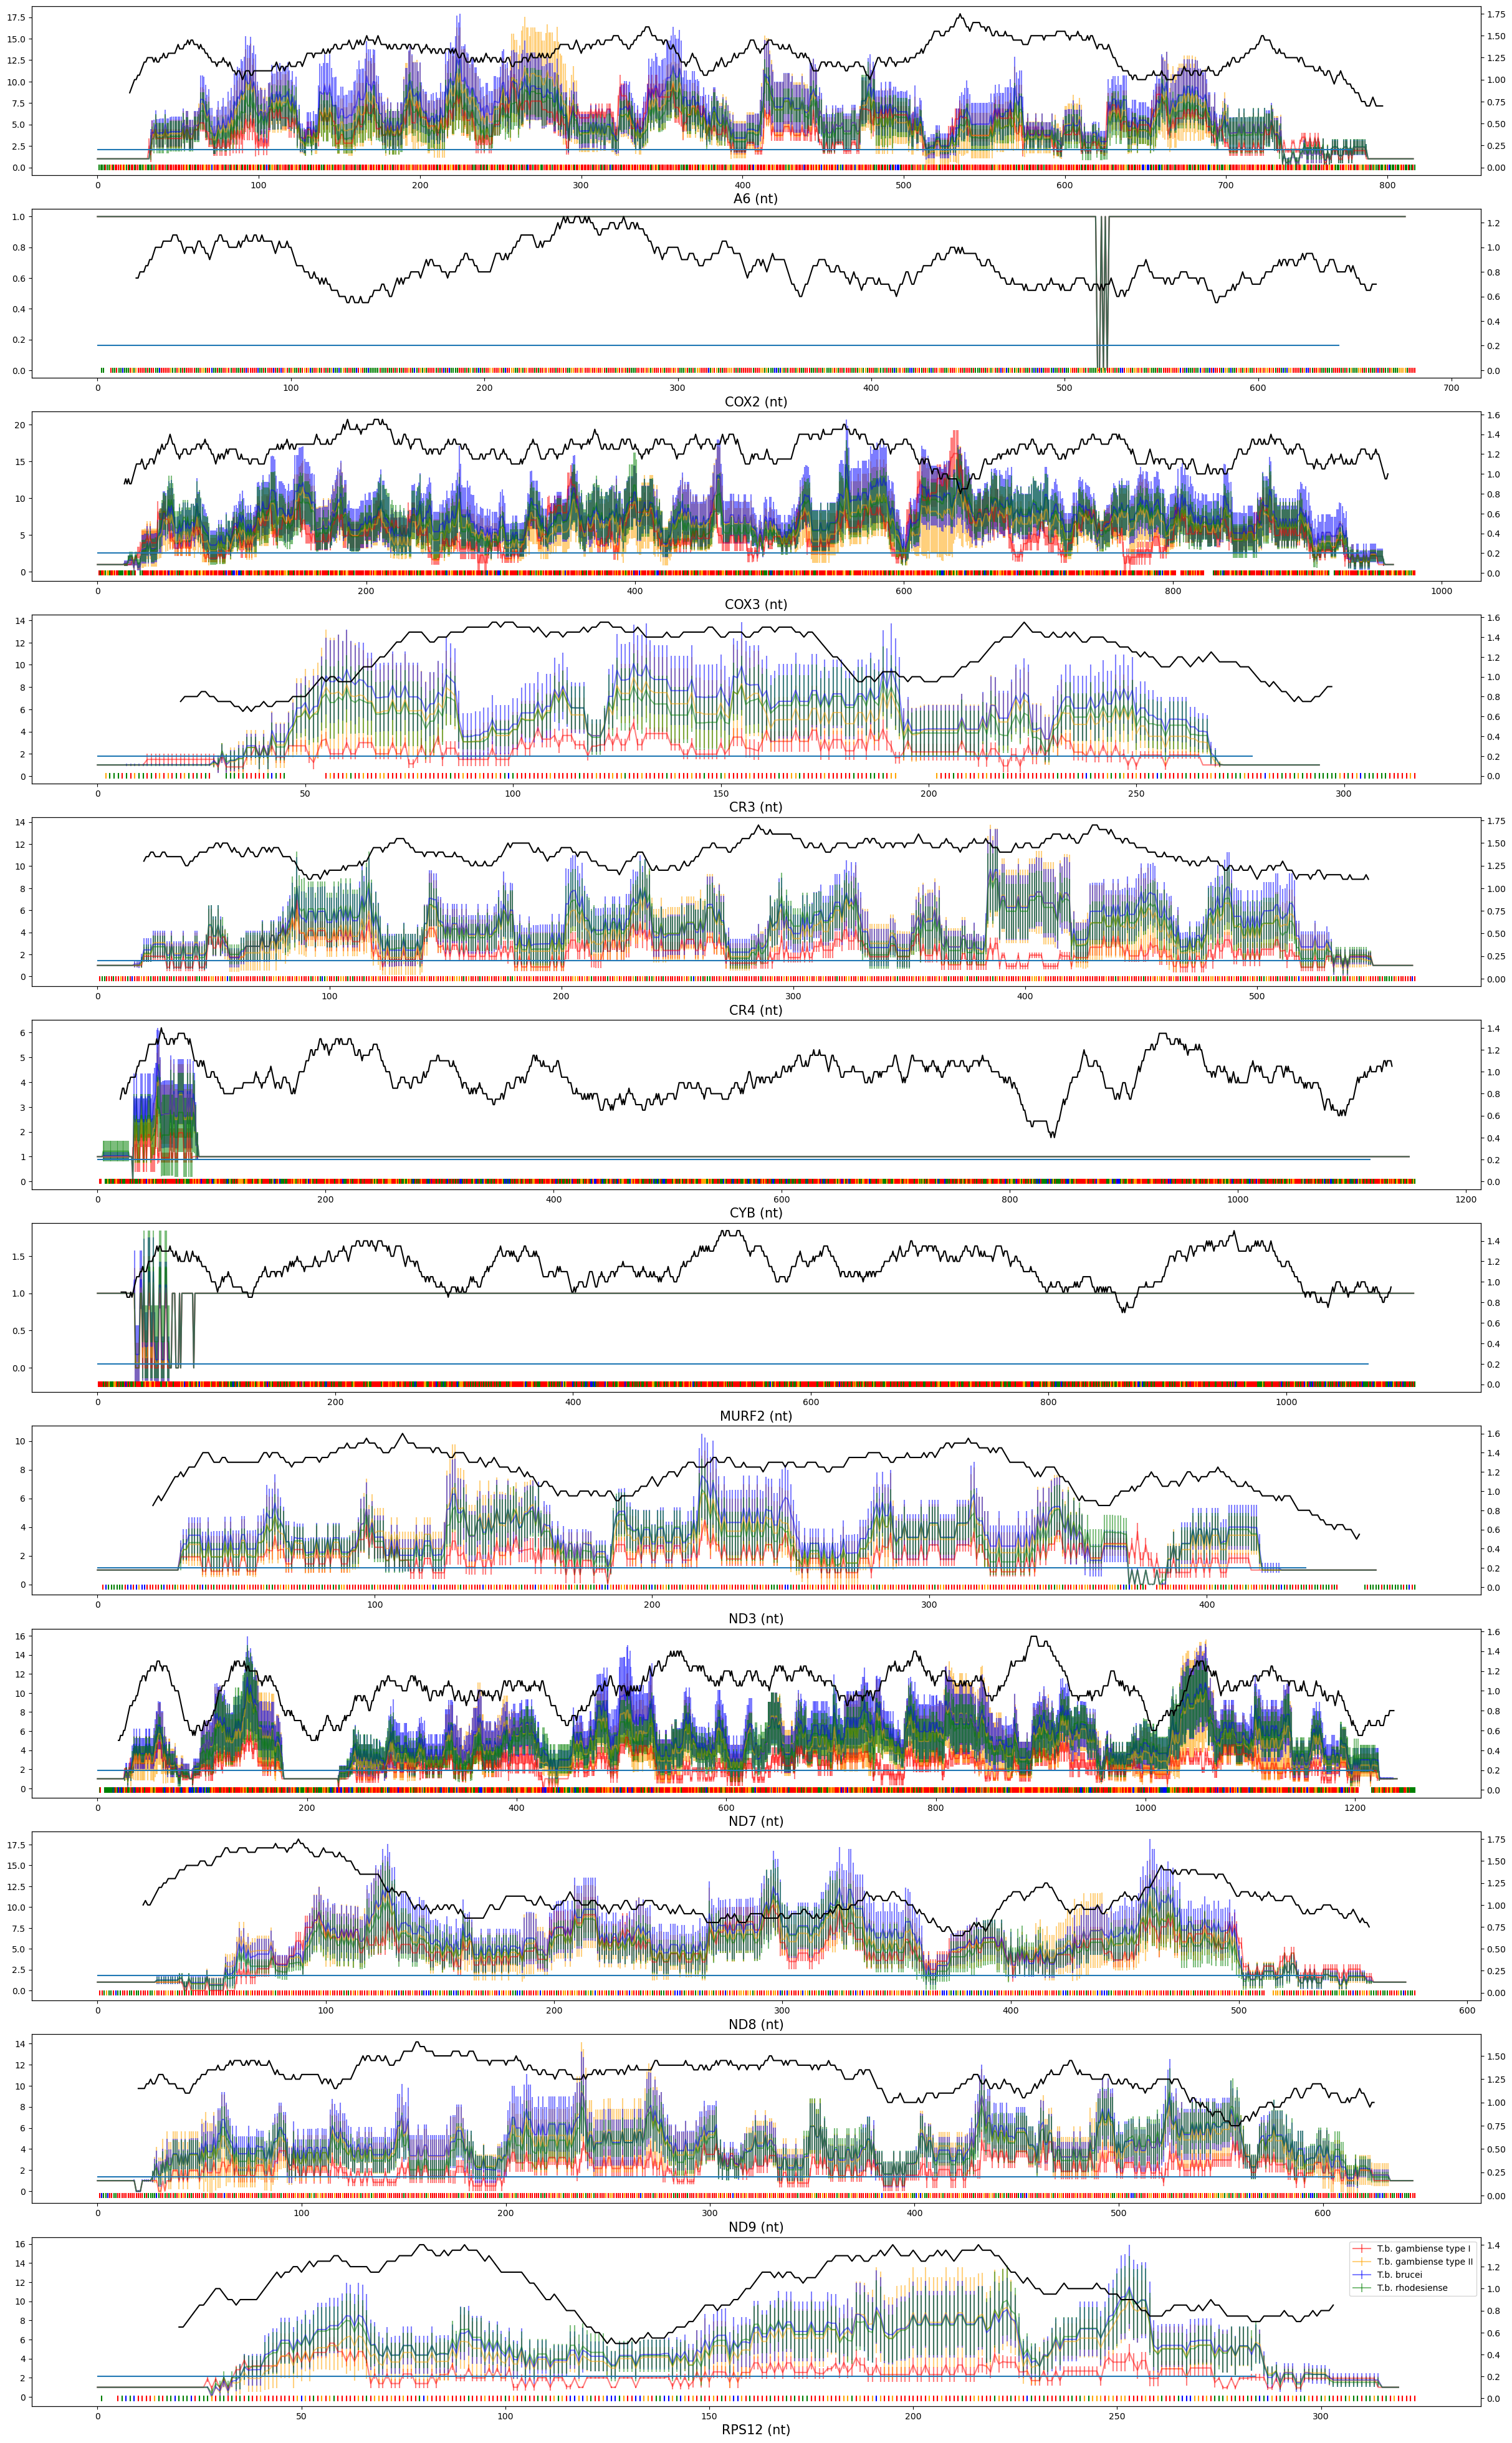

In [47]:
plot_coverage_depth_line_nucleotied_freq(metadf2,dfs,insertions,small_u,w=20,figsize=(30, 50))

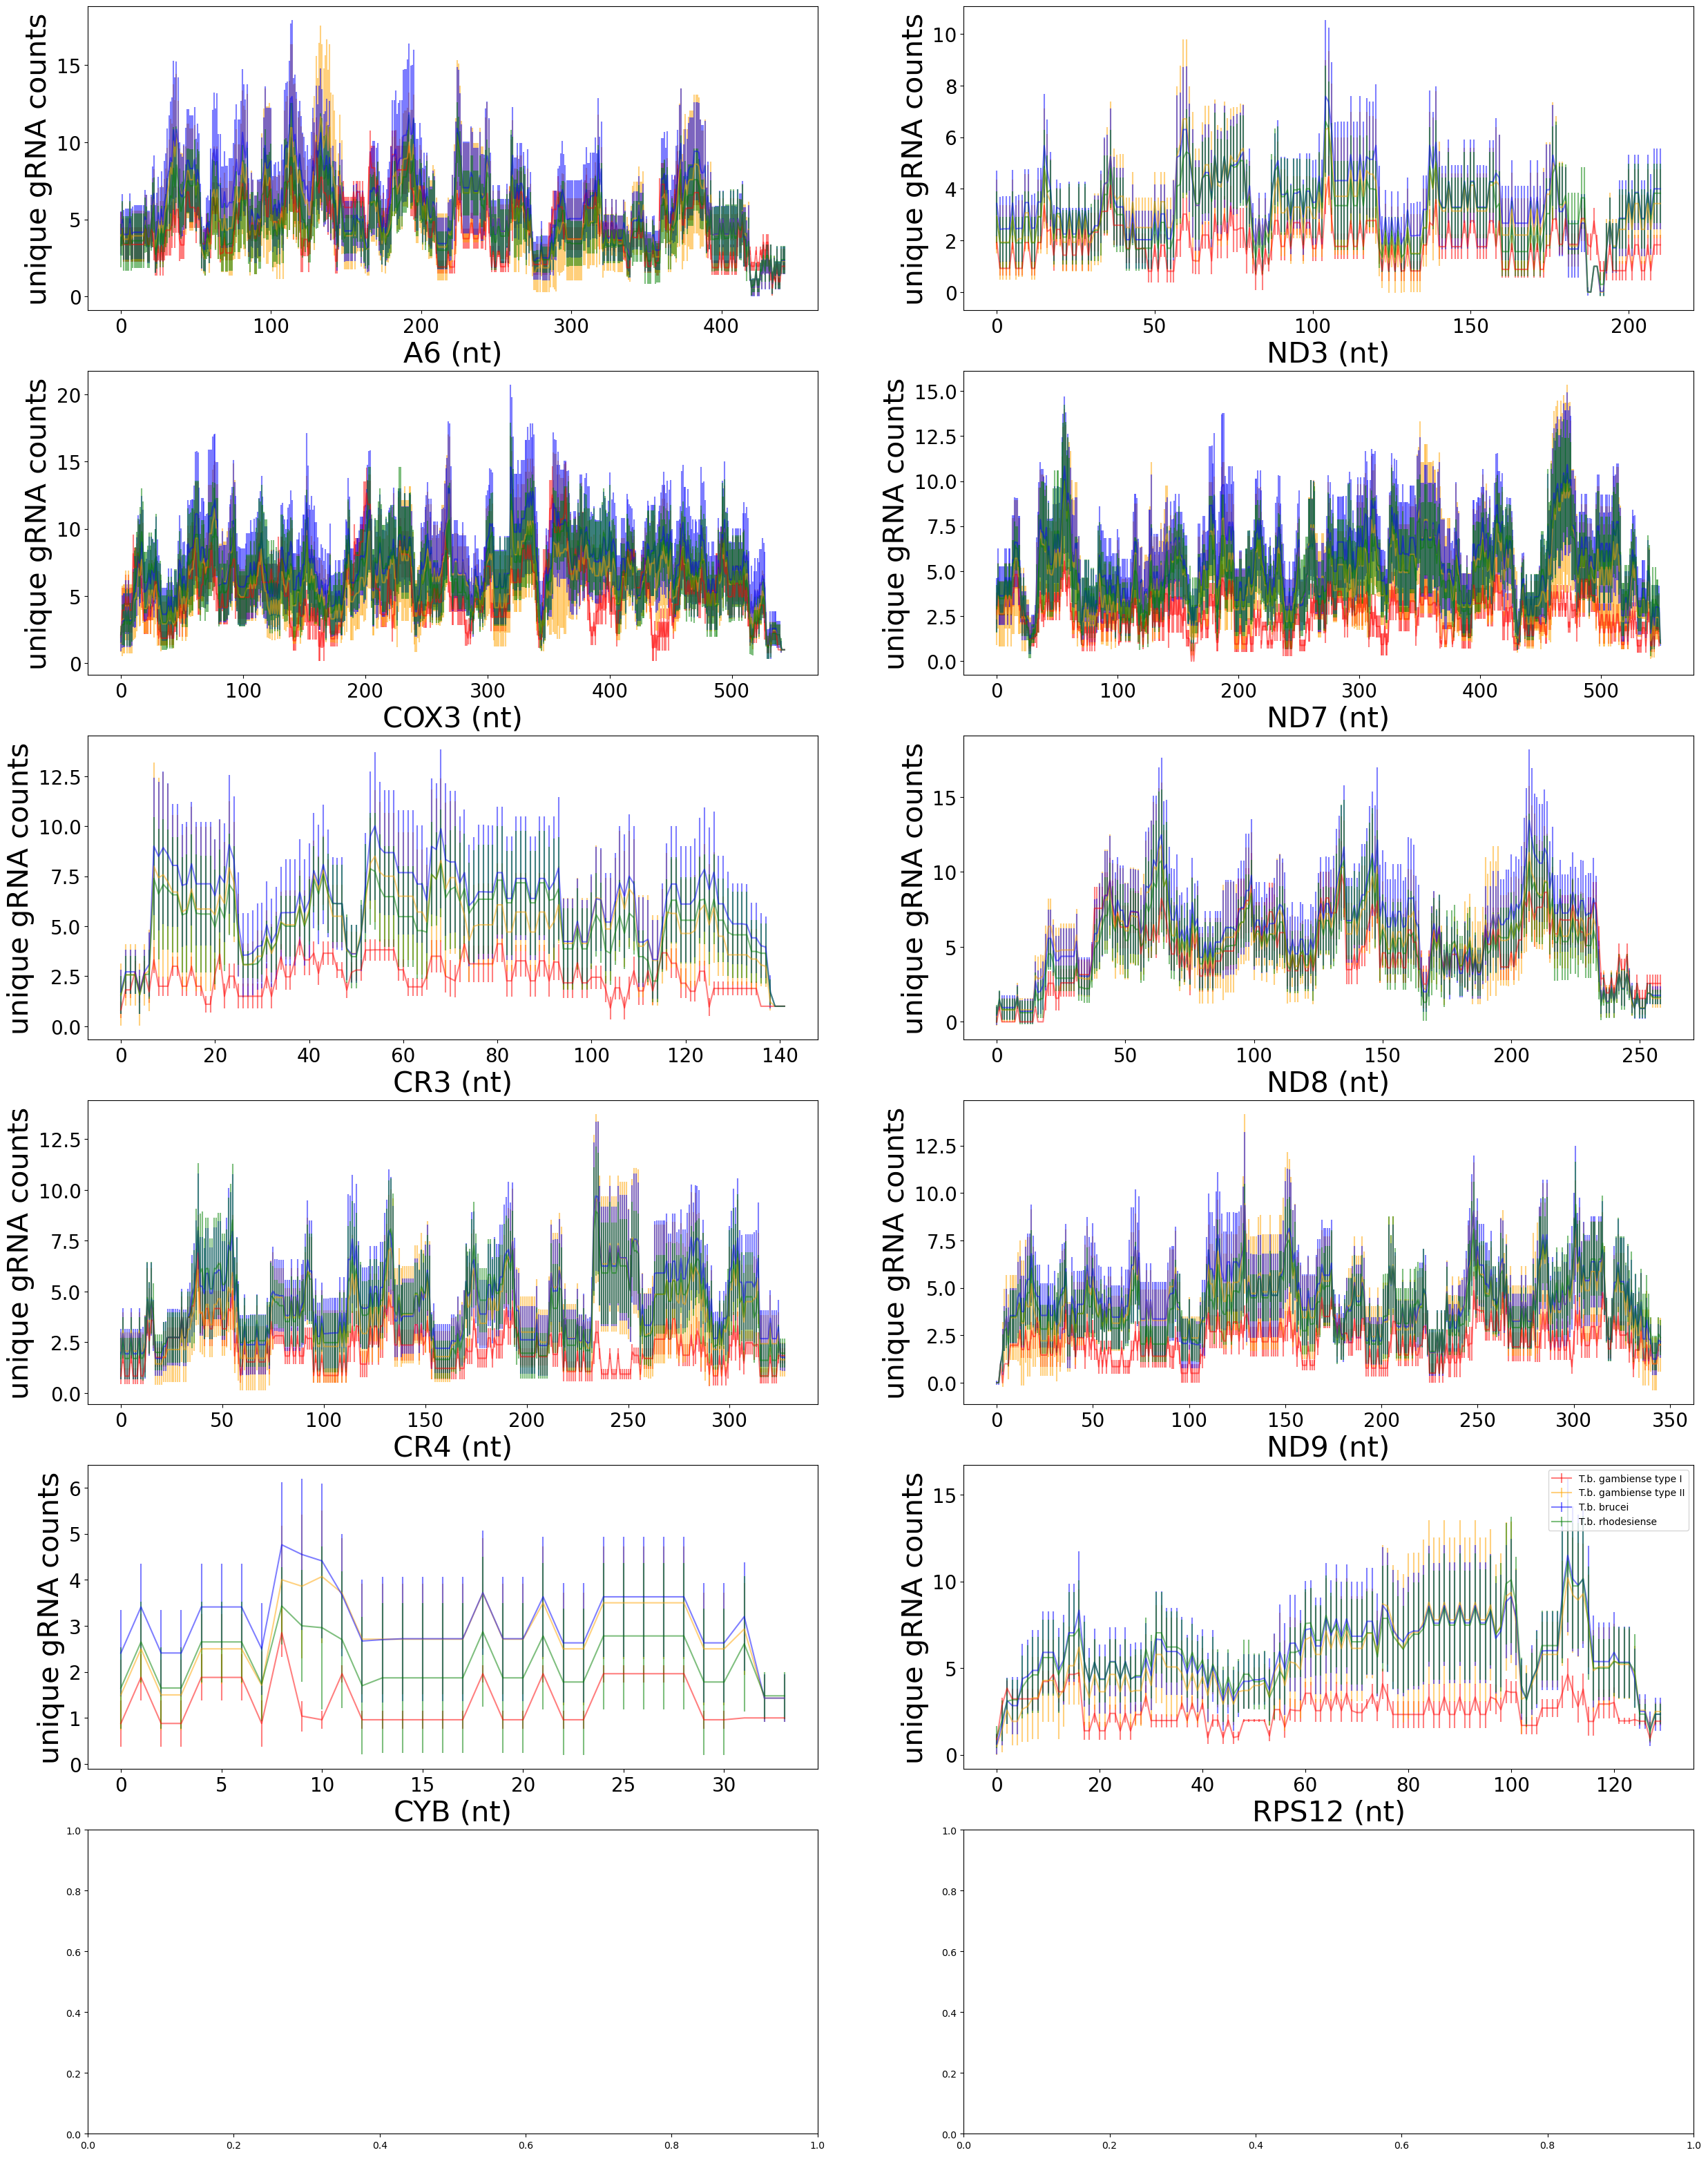

In [48]:
plot_coverage_depth_line(metadf2,dfs,insertions,figsize=(30, 40))

In [49]:
#each datapoint is a u insertion
#plot_coverage_depth(metadf2,dfs,insertions,figsize=(50, 40))

A6
T.b. gambiense type I 4.5388322860106145 vs T.b. gambiense type II 5.2952273460174135 0.0008580963527930432
T.b. gambiense type I 4.5388322860106145 vs T.b. brucei 5.891469644766545 1.161194001863657e-11
T.b. gambiense type I 4.5388322860106145 vs T.b. rhodesiense 4.842967906565905 0.027296037019343283
T.b. brucei 5.891469644766545 vs T.b. rhodesiense 4.842967906565905 0.015153451875257738
COX3
T.b. gambiense type I 5.208565182829886 vs T.b. gambiense type II 6.1657037815126055 0.0005453324005965532
T.b. gambiense type I 5.208565182829886 vs T.b. brucei 7.203125 1.9276965019264404e-13
T.b. gambiense type I 5.208565182829886 vs T.b. rhodesiense 6.470748081841433 2.961950947668612e-08
CR3
T.b. gambiense type I 2.4764623778708286 vs T.b. gambiense type II 5.183098591549295 1.802469184136385e-24
T.b. gambiense type I 2.4764623778708286 vs T.b. brucei 6.1209229058561885 2.2652314997921018e-40
T.b. gambiense type I 2.4764623778708286 vs T.b. rhodesiense 5.214941824862216 2.570150181019396

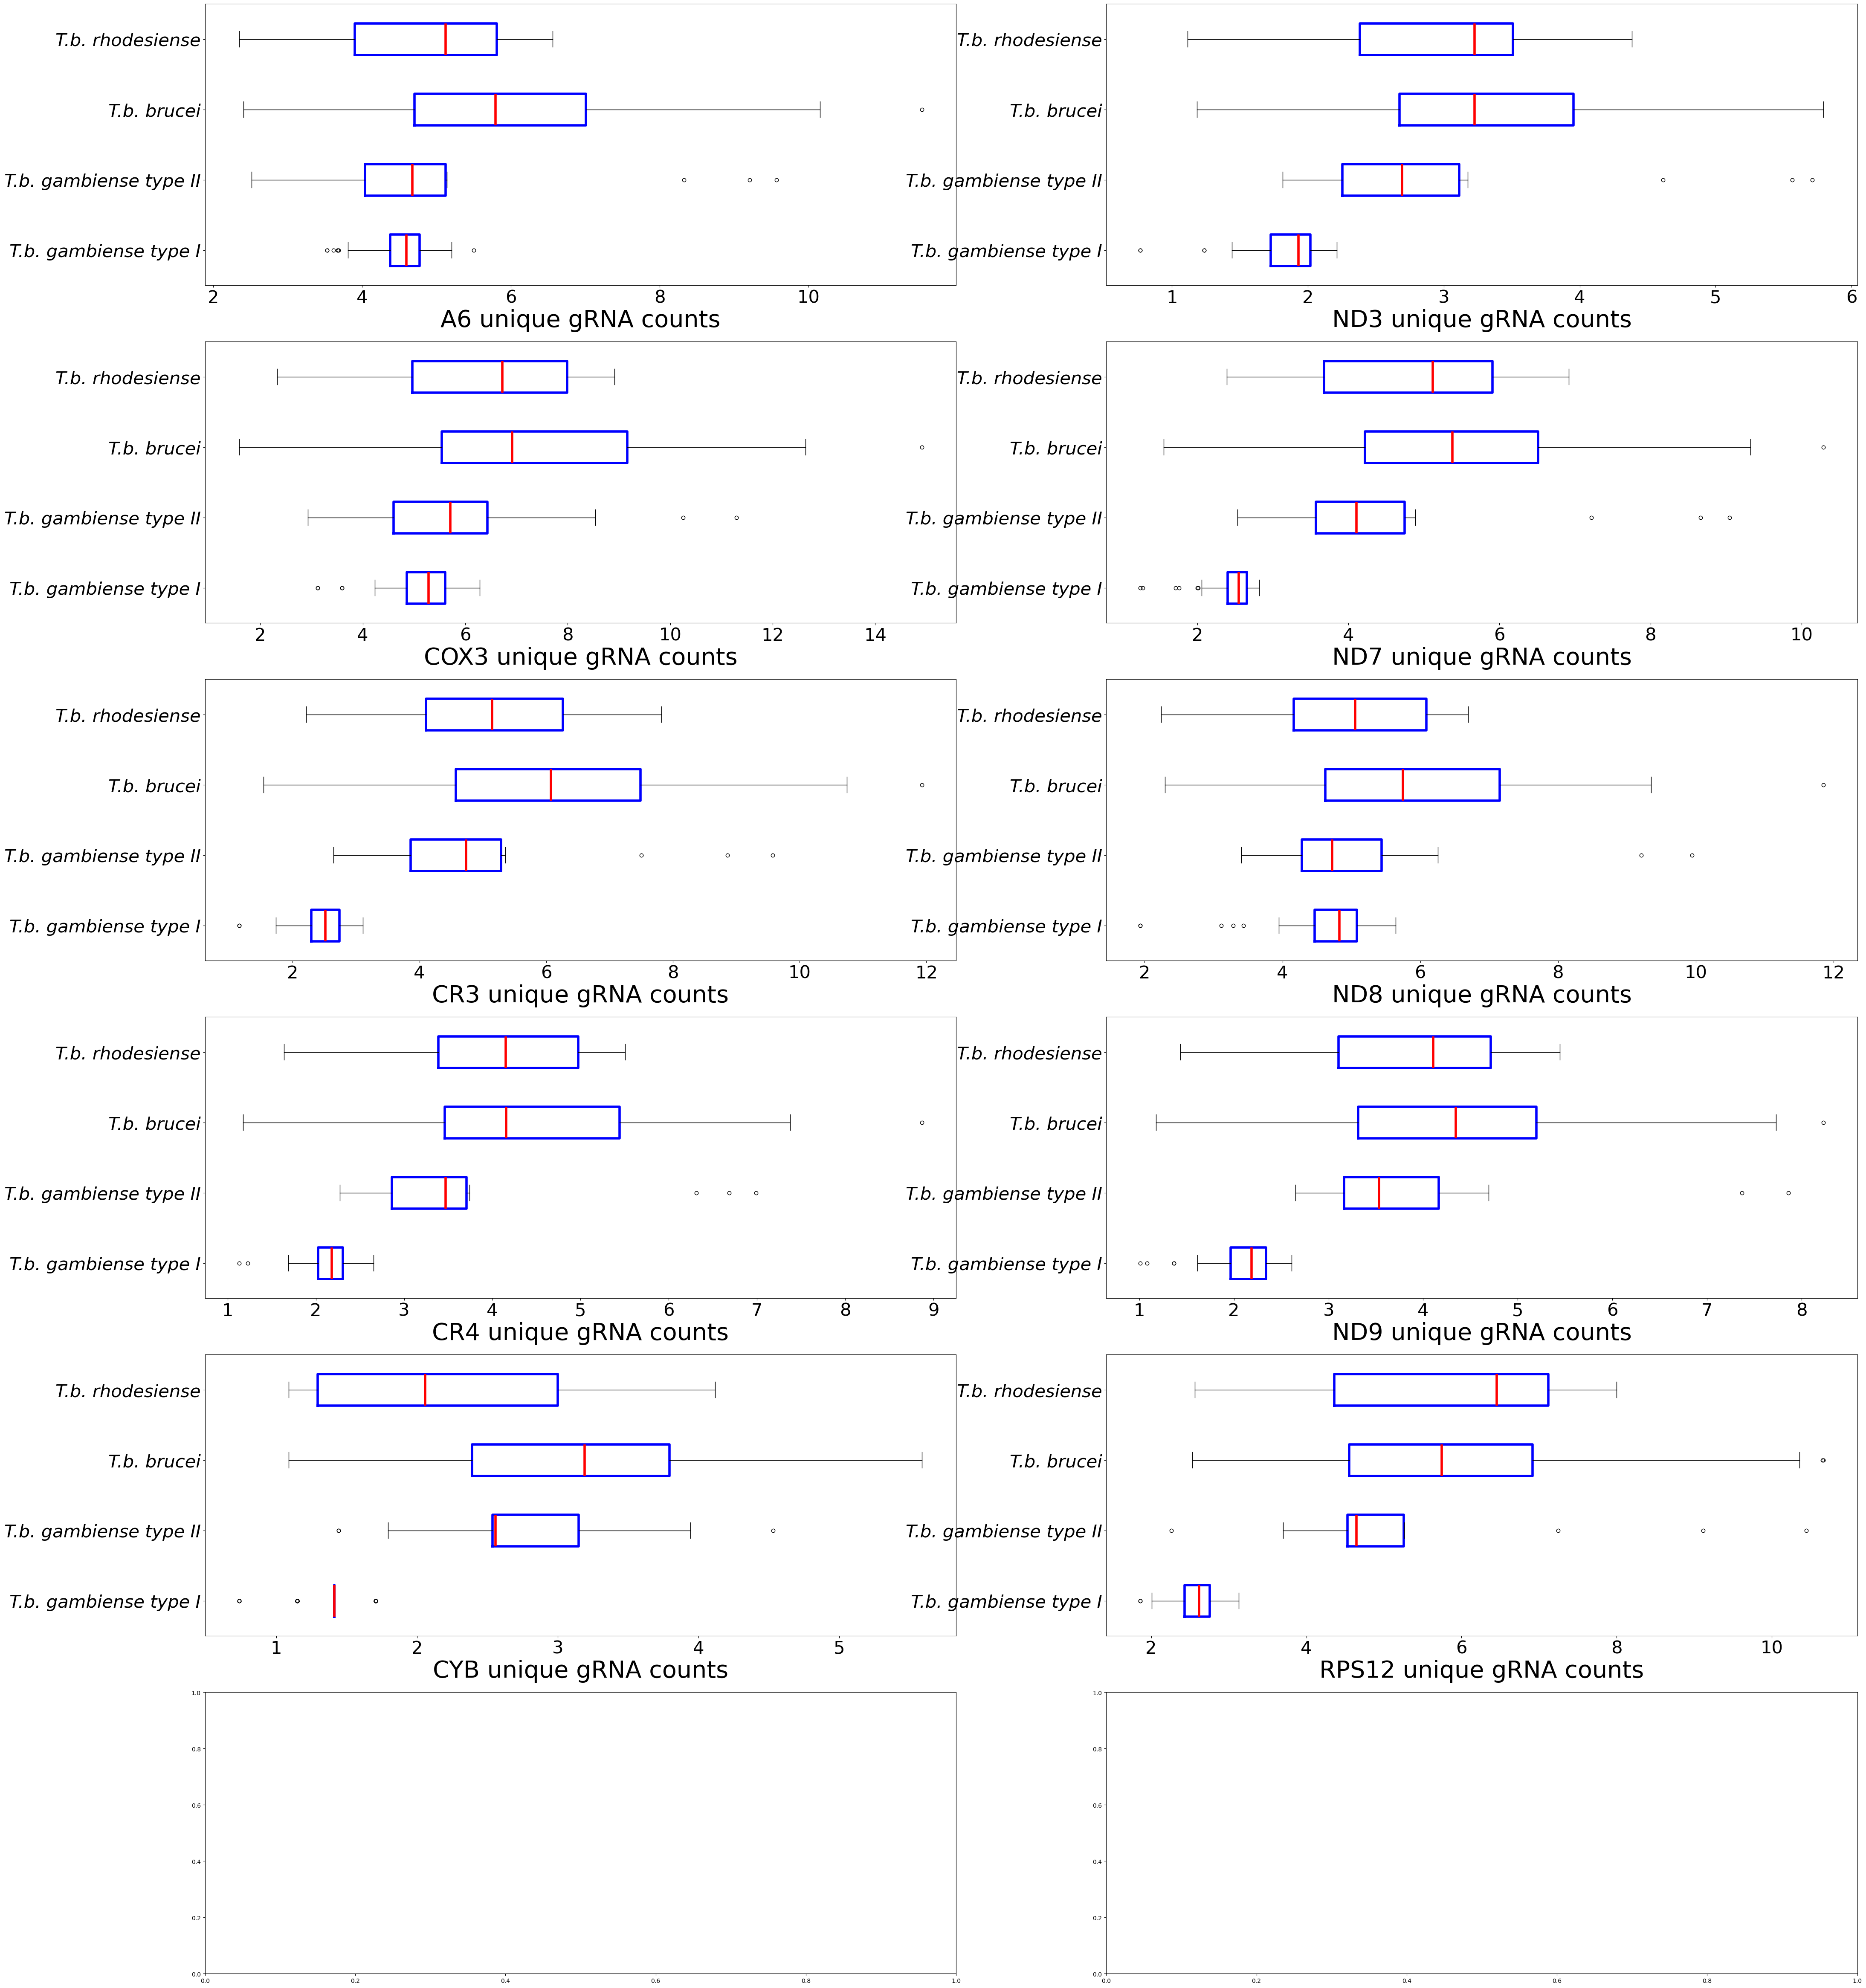

In [50]:
#each data point is an isolate
plot_coverage_depth2(metadf2,dfs,insertions,figsize=(50,60))

plot_freq_es_coverage(metadf2,dfs,small_u,figsize=(50, 40)) #something weird with the ocverage

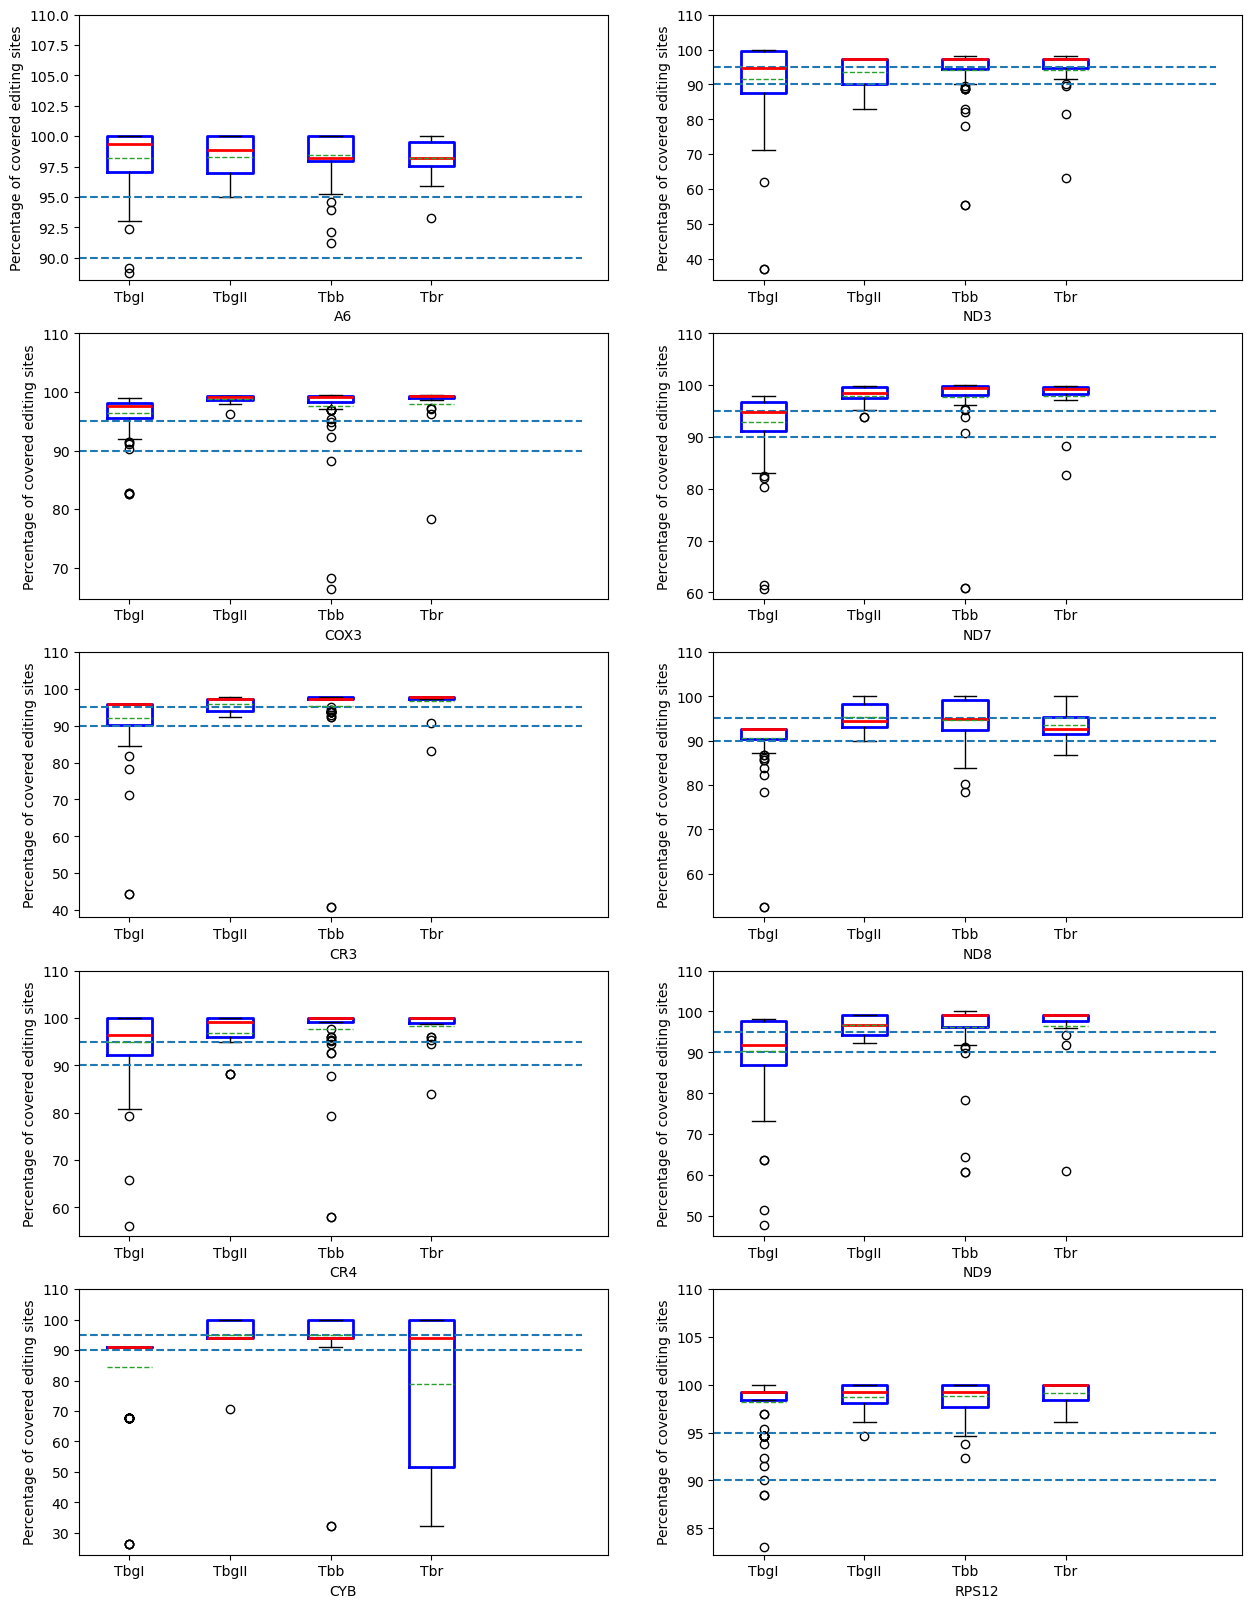

In [51]:
df_es=check_editing_sites_coverage(gRNA_by_mini,combined,small_u,anchor=6)

In [52]:
#CR4 deletion
strains=['TbgI_13_97D','TbgI_14_97D','TbgI_15_97D','TbgI_A005','TbgI_BAT35','TbgI_BIP28','TbgI_BIP33','TbgI_C3359','TbgI_Demba','TbgI_Leontio','TbgI_Mibene','TbgI_Moyox2','TbgII_P8F','TbgI_R47']
with_deletion=[df_es.loc[s]['CR4'] for s in strains]
other_Tbg1=[df_es.loc[s]['CR4'] for s in df_es[df_es['taxon']=='TbgI'].index if s not in strains]
a=ttest_ind(with_deletion, other_Tbg1)
print(a)
for s in strains:
    print(s,df_es.loc[s]['CR4'])

TtestResult(statistic=1.0293548577717488, pvalue=0.3055710289507792, df=110.0)
TbgI_13_97D 99.7
TbgI_14_97D 92.99
TbgI_15_97D 94.82
TbgI_A005 95.43
TbgI_BAT35 97.56
TbgI_BIP28 90.24
TbgI_BIP33 100.0
TbgI_C3359 100.0
TbgI_Demba 88.11
TbgI_Leontio 100.0
TbgI_Mibene 100.0
TbgI_Moyox2 100.0
TbgII_P8F 99.09
TbgI_R47 95.12


In [53]:
#strain_gfam_df[[i for i in strain_gfam_df.columns if 'ND3' in i]]

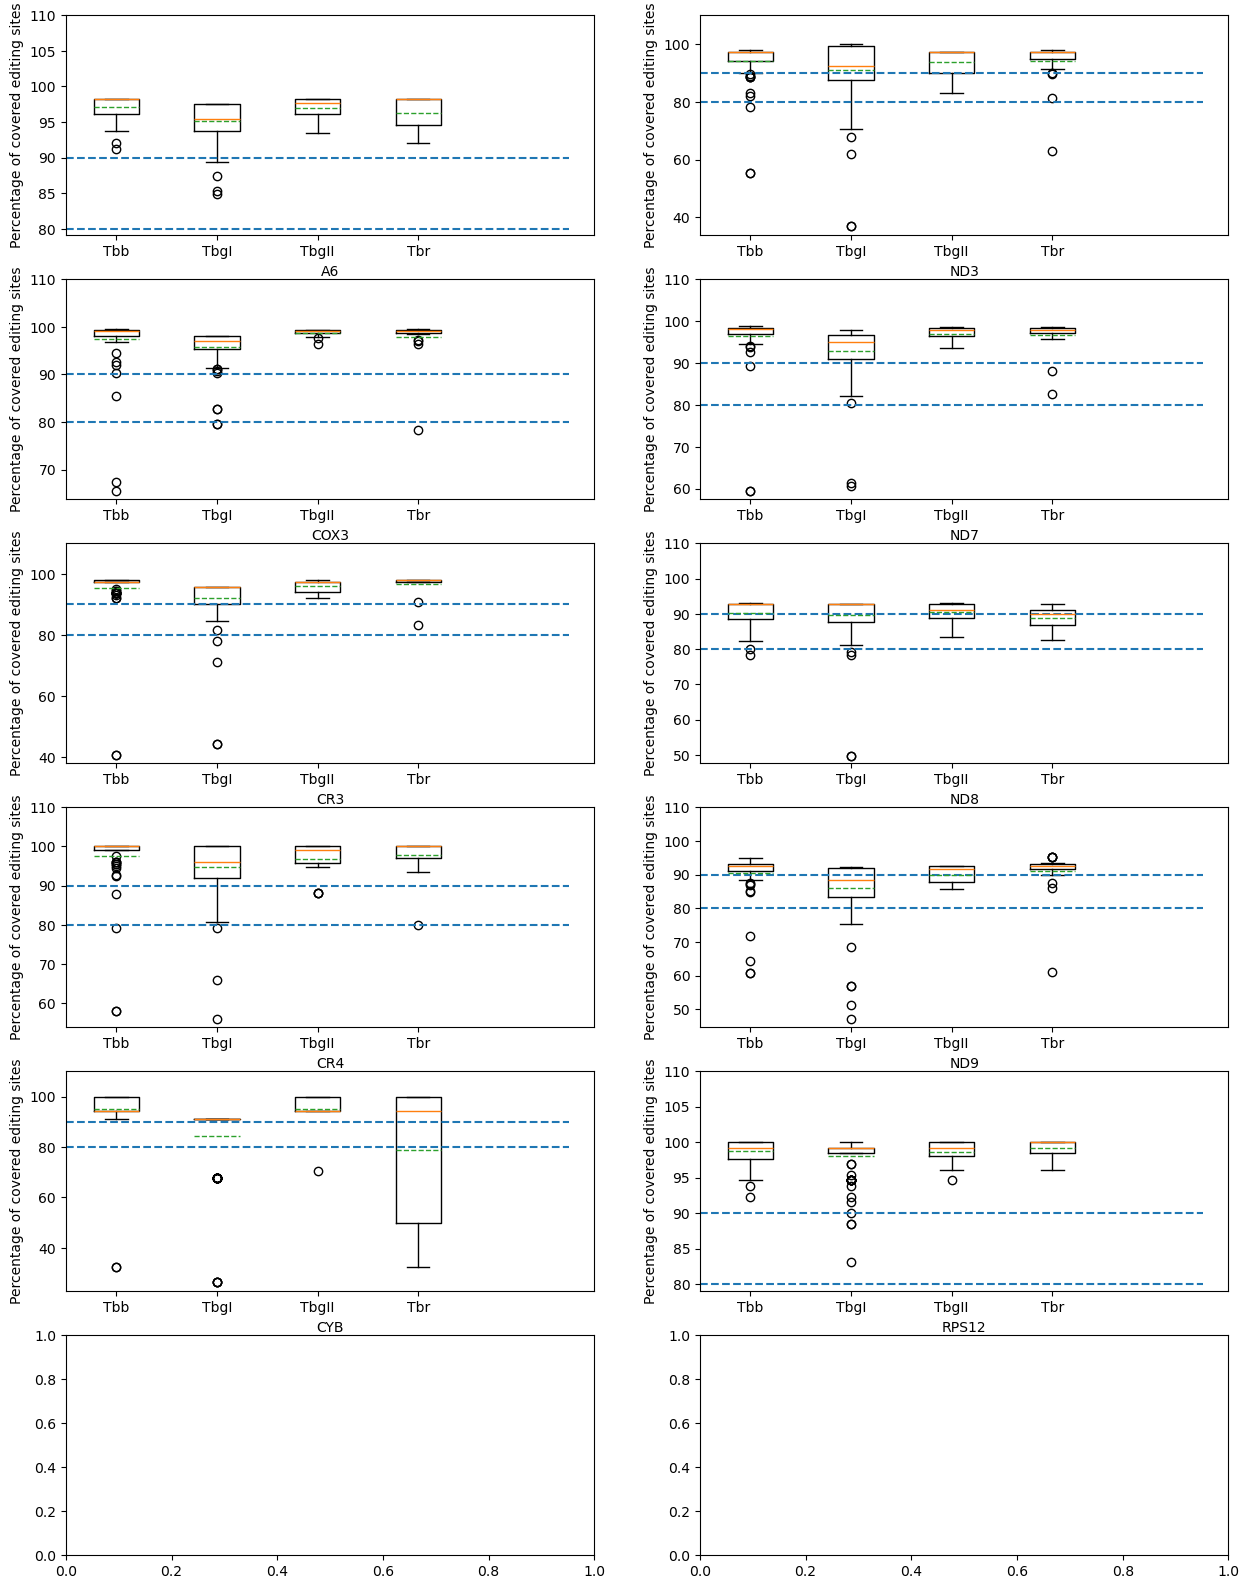

In [54]:
df_es_sub=check_gRNA_coverage_with_subset(gRNA_by_mini,combined,strain_gfam_df,small_u,anchor=6) #use only gRNA family present in >=80% isolates

In [55]:
#T test of Tbg1 against other strains
for mRNA in df_es.columns[:-1]:
    print(mRNA)
    t_test('taxon','TbgI',df_es,mRNA)

A6
pvalue 0.4891 TbgI mean: 98.22 vs Tbb mean 98.44
pvalue 0.8776 TbgI mean: 98.22 vs TbgII mean 98.32
pvalue 0.9874 TbgI mean: 98.22 vs Tbr mean 98.21
COX2
pvalue nan TbgI mean: 0.0 vs Tbb mean 0.0
pvalue nan TbgI mean: 0.0 vs TbgII mean 0.0
pvalue nan TbgI mean: 0.0 vs Tbr mean 0.0
COX3
pvalue 0.0513 TbgI mean: 96.35 vs Tbb mean 97.6
pvalue 0.0069 TbgI mean: 96.35 vs TbgII mean 98.82
pvalue 0.0443 TbgI mean: 96.35 vs Tbr mean 97.99
CR3
pvalue 0.0085 TbgI mean: 92.09 vs Tbb mean 95.4
pvalue 0.0664 TbgI mean: 92.09 vs TbgII mean 95.97
pvalue 0.0059 TbgI mean: 92.09 vs Tbr mean 96.72
CR4
pvalue 0.0097 TbgI mean: 94.89 vs Tbb mean 97.59
pvalue 0.3156 TbgI mean: 94.89 vs TbgII mean 96.76
pvalue 0.0169 TbgI mean: 94.89 vs Tbr mean 98.38
CYB
pvalue 0.0 TbgI mean: 84.4 vs Tbb mean 94.85
pvalue 0.0087 TbgI mean: 84.4 vs TbgII mean 94.96
pvalue 0.1722 TbgI mean: 84.4 vs Tbr mean 78.77
MURF2
pvalue 0.0 TbgI mean: 0.0 vs Tbb mean 12.7
pvalue 0.0001 TbgI mean: 0.0 vs TbgII mean 6.59
pvalue 0.0 Tb

In [56]:
for mRNA in df_es.columns[:-1]:
    print(mRNA)
    t_test('taxon','Tbb',df_es,mRNA)

A6
pvalue 0.4891 Tbb mean: 98.44 vs TbgI mean 98.22
pvalue 0.8192 Tbb mean: 98.44 vs TbgII mean 98.32
pvalue 0.5923 Tbb mean: 98.44 vs Tbr mean 98.21
COX2
pvalue nan Tbb mean: 0.0 vs TbgI mean 0.0
pvalue nan Tbb mean: 0.0 vs TbgII mean 0.0
pvalue nan Tbb mean: 0.0 vs Tbr mean 0.0
COX3
pvalue 0.0513 Tbb mean: 97.6 vs TbgI mean 96.35
pvalue 0.3967 Tbb mean: 97.6 vs TbgII mean 98.82
pvalue 0.7456 Tbb mean: 97.6 vs Tbr mean 97.99
CR3
pvalue 0.0085 Tbb mean: 95.4 vs TbgI mean 92.09
pvalue 0.8183 Tbb mean: 95.4 vs TbgII mean 95.97
pvalue 0.5007 Tbb mean: 95.4 vs Tbr mean 96.72
CR4
pvalue 0.0097 Tbb mean: 97.59 vs TbgI mean 94.89
pvalue 0.6828 Tbb mean: 97.59 vs TbgII mean 96.76
pvalue 0.6133 Tbb mean: 97.59 vs Tbr mean 98.38
CYB
pvalue 0.0 Tbb mean: 94.85 vs TbgI mean 84.4
pvalue 0.9723 Tbb mean: 94.85 vs TbgII mean 94.96
pvalue 0.0001 Tbb mean: 94.85 vs Tbr mean 78.77
MURF2
pvalue 0.0 Tbb mean: 12.7 vs TbgI mean 0.0
pvalue 0.2952 Tbb mean: 12.7 vs TbgII mean 6.59
pvalue 0.2495 Tbb mean: 12.

In [57]:
#T test of Tbg1 against other strains
for mRNA in df_es_sub.columns[:-1]:
    print(mRNA)
    t_test('taxon','TbgI',df_es_sub,mRNA)

A6
pvalue 0.0 TbgI mean: 95.11 vs Tbb mean 97.16
pvalue 0.0157 TbgI mean: 95.11 vs TbgII mean 96.95
pvalue 0.0483 TbgI mean: 95.11 vs Tbr mean 96.33
COX2
pvalue nan TbgI mean: 0.0 vs Tbb mean 0.0
pvalue nan TbgI mean: 0.0 vs TbgII mean 0.0
pvalue nan TbgI mean: 0.0 vs Tbr mean 0.0
COX3
pvalue 0.0133 TbgI mean: 95.73 vs Tbb mean 97.38
pvalue 0.0016 TbgI mean: 95.73 vs TbgII mean 98.74
pvalue 0.0085 TbgI mean: 95.73 vs Tbr mean 97.94
CR3
pvalue 0.0085 TbgI mean: 92.09 vs Tbb mean 95.4
pvalue 0.0664 TbgI mean: 92.09 vs TbgII mean 95.97
pvalue 0.0059 TbgI mean: 92.09 vs Tbr mean 96.72
CR4
pvalue 0.007 TbgI mean: 94.76 vs Tbb mean 97.58
pvalue 0.286 TbgI mean: 94.76 vs TbgII mean 96.76
pvalue 0.0358 TbgI mean: 94.76 vs Tbr mean 97.88
CYB
pvalue 0.0 TbgI mean: 84.4 vs Tbb mean 94.85
pvalue 0.0087 TbgI mean: 84.4 vs TbgII mean 94.96
pvalue 0.163 TbgI mean: 84.4 vs Tbr mean 78.64
MURF2
pvalue nan TbgI mean: 0.0 vs Tbb mean 0.0
pvalue nan TbgI mean: 0.0 vs TbgII mean 0.0
pvalue nan TbgI mean: 0

In [58]:
def compare_es_coverage(df1,df2):
    #mean es coverage
    for mrna in df1.columns[:-1]:
        diff=df1[mrna]-df2[mrna]
        diffmean=sum(diff)/len(diff)
        print(f"{mrna},{round(sum(df1[mrna])/len(df1),2)},{round(sum(df2[mrna])/len(df2),2)},{round(diffmean,2)}")
    #mean: decline in es coverage
    for mrna in df1.columns[:-1]:
        diff=df1[mrna]-df2[mrna]
        mean=sum(diff)/len(diff)
        #print(mrna,mean)
    #mean: decline in es coverage by taxon
    for mrna in df1.columns[:-1]:
        for t in set(df1['taxon']):
            diff=df1[df1['taxon']==t][mrna]-df2[df2['taxon']==t][mrna]
            mean=sum(diff)/len(diff)
            #print(mrna,t,mean)

compare_es_coverage(df_es,df_es_sub)
tmp={gf:sum([1 for i in strain_gfam_df[gf].isna() if i == False])/224*100 for gf in strain_gfam_df.columns}
high_presence=[k for k,v in tmp.items() if v >= 80]#use only gRNA family with high presence
prevalent_gRNA_nb=sum([len(gRNA_families[mrna][gf]['gRNA']) for mrna in gRNA_families for gf in gRNA_families[mrna] if gf in high_presence])
print('gRNAs contained in all and subset gfam',prevalent_gRNA_nb,len(gRNA_dict),round(prevalent_gRNA_nb/len(gRNA_dict)*100,2))

A6,98.3,96.04,2.26
COX2,0.0,0.0,0.0
COX3,97.1,96.71,0.39
CR3,93.93,93.93,0.0
CR4,96.28,96.16,0.12
CYB,88.03,88.01,0.01
MURF2,6.65,0.0,6.65
ND3,92.88,92.59,0.3
ND7,95.38,94.73,0.65
ND8,92.53,89.85,2.68
ND9,93.28,88.32,4.96
RPS12,98.51,98.5,0.02
gRNAs contained in all and subset gfam 13201 13700 96.36


In [59]:
def plot_gRNA_percentage_multi_strain(strains,strain_gfam,gRNA_dict,combined,strain_mini_sets,mini_dict,
                                      figw=4,figh=8,width=0.35,title='null'):
    mrnas=['ND8','ND9','ND7','COX3','CYB','A6','CR3','CR4','ND3','RPS12']
    #mrnas=['ND8','ND9','ND7','COX3','A6','CR3','CR4','ND3','RPS12']
    df_list=[]
    for s in strains:
        #consider unique gfam
        gf=[gf.split('-')[0].split('_')[0] for gf in strain_gfam[s].keys()] #combine v1 v2
        gf={mrna: round(gf.count(mrna)/len(gf)*100,2) for mrna in mrnas}
        df=pd.DataFrame.from_dict(gf,orient='index')
        df_list.append(df)
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), sharey=False)
    x,adj= np.arange(0,len(strains),1)*(width*1.2),0
    for df,strain in zip(df_list,strains):
        bttm=0
        for mrna in df.index:
            axs.bar(adj, df.loc[mrna], width,bottom=bttm,label=mrna)
            bttm+=df.loc[mrna]
        adj+=width*1.2
    #styling
    axs.set_xticks(x)
    axs.set_xticklabels(strains,rotation= 90) # have to do this seperate from set_xticks, otherwise error
    axs.tick_params(axis='x', labelsize= 20)
    axs.tick_params(axis='y', labelsize= 15)
    axs.set_xlabel('mRNAs',fontsize=20)
    axs.set_ylabel('Proportion of predicted gRNAs(%)',fontsize=20)
    axs.set_title(title,fontsize=20) 
    axs.set_facecolor("white")
    #legend
    handles1, labels1 = axs.get_legend_handles_labels()
    by_label = dict(zip(labels1, handles1))
    leg=axs.legend(by_label.values(), by_label.keys(),fontsize=20,bbox_to_anchor=(0.1, -0.15))
    plt.grid(True)
    plt.show()

#get ratio of edited length
def get_edited_len(insertions):
    edited_len={}
    for mrna,seq in insertions.items():
        if 'v2' not in mrna and mrna not in ['COX2','MURF2']:
            #remove unedited region on 3' and 5' end
            edited=''.join([str(i) for i in insertions[mrna]]).strip('0')
            edited_len[mrna.split('_')[0]]=len(edited)
    total_len=sum(edited_len.values())
    ratio_exp={k: round(v/total_len*100,2) for k,v in edited_len.items()}
    return(edited_len,ratio_exp)
#compare ratio of gRNAs: need to use z test to compare the ratio instead of chi square
def gRNA_ratio(gRNA_dict,gfam,high_presence,gf_enriched,ratio_exp,pv=0.05,figw=4,figh=8,width=0.35,title=''):
    mrnas=['ND8','ND9','ND7','COX3','CYB','A6','CR3','CR4','ND3','RPS12']
    ratio={k:v/100 for k,v in ratio_exp.items()}
    #ratio of gRNA
    grnas=[v['product'] for k,v in gRNA_dict.items()]
    grna_obs={mrna: grnas.count(mrna) for mrna in mrnas}
    grna_ratio={mrna: grnas.count(mrna)/len(grnas)*100 for mrna in mrnas}
        #use chi square to check
    for mrna in mrnas:
        #chi=chisquare([grna_obs[mrna],sum(grna_obs.values())-grna_obs[mrna]], 
        #              f_exp=[sum(grna_obs.values())*ratio[mrna],(1-ratio[mrna])*sum(grna_obs.values())])
        z=binomtest(grna_obs[mrna],sum(grna_obs.values()),ratio[mrna])
        if z.pvalue<=pv:
            print('gRNA',mrna,z)
    #ratio of gRNA families without COX2, MURF2
    gfams=[k.split('-')[0].split('_')[0] for k in gfam.keys() if k.split('-')[0].split('_')[0] not in ['COX2','MURF2']]
    gfam_obs={mrna: round(gfams.count(mrna)/len(gfams)*100,2) for mrna in mrnas}
    gfam_count={mrna: gfams.count(mrna) for mrna in mrnas}
        #use z test to check
    for mrna in mrnas:
    #    chi=chisquare([gfam_count[mrna],sum(gfam_count.values())-gfam_count[mrna]], 
    #                  f_exp=[ratio[mrna]*sum(gfam_count.values()),(1-ratio_exp[mrna])*sum(gfam_count.values())])
        z=binomtest(gfam_count[mrna],sum(gfam_count.values()),ratio[mrna])
        if z.pvalue<=pv:
            print(mrna,z)
    #ratio of major gRNA families without COX2, MURF2
    high_gf=[k.split('-')[0].split('_')[0] for k in high_presence if k.split('-')[0].split('_')[0] not in ['COX2','MURF2','percent of major gRNA','taxon']]
    print(set(high_gf))
    high_gf_obs={mrna: round(high_gf.count(mrna)/len(high_gf)*100,2) for mrna in mrnas}
    high_gf_counts={mrna: high_gf.count(mrna) for mrna in mrnas}
        #use z test to check
    for mrna in mrnas:
        #chi=chisquare([high_gf_obs[mrna],100-high_gf_obs[mrna]], f_exp=[ratio_exp[mrna],100-ratio_exp[mrna]])
        z=binomtest(high_gf_counts[mrna],sum(high_gf_counts.values()),ratio[mrna])
        if z.pvalue<=pv:
            print(mrna,z)
    #ratio of major gRNA families without COX2, MURF2, enriched with TbgI in top/bottom 10%
    en_gf=[k.split('-')[0].split('_')[0] for k in gf_enriched['TbgI'] if k.split('-')[0].split('_')[0] not in ['percent of major gRNA','COX2','MURF2']]
    en_gf_obs={mrna: round(en_gf.count(mrna)/len(en_gf)*100,2) for mrna in mrnas}
    en_gf_count={mrna: en_gf.count(mrna) for mrna in mrnas}
    print(set(en_gf))
        #use chi square to check
    for mrna in mrnas:
        #chi=chisquare([en_gf_obs[mrna],100-en_gf_obs[mrna]], f_exp=[ratio_exp[mrna],100-ratio_exp[mrna]])
        z=binomtest(en_gf_count[mrna],sum(en_gf_count.values()),ratio[mrna])
        if z.pvalue<=pv:
            print(mrna,z)
    #visualize
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), sharey=False)
    data=[pd.DataFrame.from_dict(ratio_exp,orient='index'),
          pd.DataFrame.from_dict(grna_ratio,orient='index'),
          pd.DataFrame.from_dict(gfam_obs,orient='index'),
          pd.DataFrame.from_dict(high_gf_obs,orient='index')] #pd.DataFrame.from_dict(en_gf_obs,orient='index')
    #labels=['expected ratio','gRNA ratio','gRNA family ratio','major gRNA family ratio','top/bottom 10% TbgI enriched gfam']
    labels=['expected ratio','gRNA ratio','gRNA family ratio','major gRNA family ratio']
    x,adj= np.arange(0,len(data),1)*(width*1.2),0
    for df in data:
        bttm=0
        for mrna in mrnas:
            axs.bar(adj, df.loc[mrna], width,bottom=bttm,label=mrna)
            bttm+=df.loc[mrna]
        adj+=width*1.2
    #styling
    axs.set_xticks(x)
    axs.set_xticklabels(labels,rotation= 90) # have to do this seperate from set_xticks, otherwise error
    axs.tick_params(axis='x', labelsize= 20)
    axs.tick_params(axis='y', labelsize= 15)
    #axs.set_xlabel('mRNAs',fontsize=20)
    axs.set_ylabel('Proportion of predicted gRNAs(%)',fontsize=20)
    axs.set_title(title,fontsize=20) 
    axs.set_facecolor("white")
    #legend
    handles1, labels1 = axs.get_legend_handles_labels()
    by_label = dict(zip(labels1, handles1))
    leg=axs.legend(by_label.values(), by_label.keys(),fontsize=20,bbox_to_anchor=(0.1, -0.15))
    plt.grid(True)
    plt.show()
    #return (ratio_obs)
#find strain with mRNA-gRNA deviated from expected ratio
def strain_gRNA_ratio(strain_gfam,strain_mini_sets,high_presence,ratio_exp,pv=0.05,figw=4,figh=8,width=0.35,title=''):
    ratio_exp={k:v/100 for k,v in ratio_exp.items()}
    mrnas=['ND8','ND9','ND7','COX3','CYB','A6','CR3','CR4','ND3','RPS12']
    #ratio of gRNA family
    print('------------gRNA family ratio--------------')
    for s,gfams in strain_gfam.items():
        #consider unique gfam
        gf=[gf.split('-')[0].split('_')[0] for gf in gfams.keys()] #combine v1 v2
        gfam_obs={mrna: gf.count(mrna) for mrna in mrnas}
        mrna_chi={mrna:chisquare([gfam_obs[mrna],sum(gfam_obs.values())-gfam_obs[mrna]], f_exp=[ratio_exp[mrna]*sum(gfam_obs.values()),(1-ratio_exp[mrna])*sum(gfam_obs.values())]).pvalue
                  for mrna in mrnas}
        sig={mrna:(p,gfam_obs[mrna]) for mrna,p in mrna_chi.items() if p<pv}
        if len(sig)>0:
            print(s,sig,len(strain_mini_sets[s]))
            #sig={mrna:(p,gfam_obs[mrna]) for mrna,p in mrna_chi.items()}
            #print(s,sig)
    #repeat for gRNA 
    print('\n------------gRNA ratio--------------\n')
    def gRNA_ratio():
        enriched={}
        for s,gfams in strain_gfam.items():
            grnas={mrna:sum([len(gfams[gf]) for gf in gfams if mrna in gf]) for mrna in mrnas}
            total=sum(grnas.values())
            #grna_obs={mrna: round(grnas[mrna]/total*100,2) for mrna in mrnas}
            mrna_chi={mrna:chisquare([grnas[mrna],sum(grnas.values())-grnas[mrna]], f_exp=[ratio_exp[mrna]*sum(grnas.values()),(1-ratio_exp[mrna])*sum(grnas.values())]).pvalue
                      for mrna in mrnas}
            sig={mrna:(p,grnas[mrna]) for mrna,p in mrna_chi.items() if p<pv}
            sig={mrna:'lower' if sig[mrna][1]< ratio_exp[mrna]*sum(grnas.values()) else 'higher' for mrna in sig}
            if len(sig)>0:
                #print(s,sig,len(strain_mini_sets[s]))
                enriched[s]=sig
                #print(s,{mrna:(p,grna_obs[mrna]) for mrna,p in mrna_chi.items()})
        return(enriched)
    enriched=gRNA_ratio()
    print('\n------------major gRNA gene ratio--------------\n')
    for s,gfams in strain_gfam.items():
        #consider unique gfam
        gf=[gf.split('-')[0].split('_')[0] for gf in gfams.keys() if gf in high_presence] #combine v1 v2
        gfam_obs={mrna: gf.count(mrna) for mrna in mrnas}
        mrna_chi={mrna:chisquare([gfam_obs[mrna],sum(gfam_obs.values())-gfam_obs[mrna]], f_exp=[ratio_exp[mrna]*sum(gfam_obs.values()),(1-ratio_exp[mrna])*sum(gfam_obs.values())]).pvalue
                  for mrna in mrnas}
        sig={mrna:(p,gfam_obs[mrna]) for mrna,p in mrna_chi.items() if p<pv}
        if len(sig)>0:
            print(s,sig,len(strain_mini_sets[s]))
    return(enriched)

In [60]:
#enrichment of mRNA-gRNAs in certain isolates
edited_len,ratio_exp=get_edited_len(insertions)
enriched=strain_gRNA_ratio(strain_gfam,strain_mini_sets,high_presence,ratio_exp,pv=0.05,figw=4,figh=8,width=0.35,title='')

------------gRNA family ratio--------------
TbgI_LiTat-1-3 {'A6': (0.007237173042657149, 28)} 52
TbgI_LiTat-1-5-P9 {'A6': (0.004732154952215272, 28)} 51
Tbb_MBO-NG-74-R10-bis {'A6': (0.017115174859310443, 27)} 77
Tbb_MBO-NG-74-R10 {'A6': (0.015150930407837316, 27)} 76

------------gRNA ratio--------------


------------major gRNA gene ratio--------------

TbgI_LiTat-1-3 {'A6': (0.0068451845291388185, 27)} 52
TbgI_LiTat-1-5-P9 {'A6': (0.004402560759423307, 27)} 51
Tbb_MBO-NG-74-R10-bis {'A6': (0.016612284982204295, 26)} 77
Tbb_MBO-NG-74-R10 {'A6': (0.0146441316615737, 26)} 76


In [61]:
deviated={mrna:{'higher':0,'lower':0} for mrna in ratio_exp}
for s in enriched:
    for mrna in enriched[s]:
        deviated[mrna][enriched[s][mrna]]+=1
deviated

{'A6': {'higher': 7, 'lower': 0},
 'COX3': {'higher': 198, 'lower': 0},
 'CR3': {'higher': 10, 'lower': 0},
 'CR4': {'higher': 0, 'lower': 25},
 'CYB': {'higher': 0, 'lower': 7},
 'ND3': {'higher': 0, 'lower': 103},
 'ND7': {'higher': 0, 'lower': 25},
 'ND8': {'higher': 24, 'lower': 0},
 'ND9': {'higher': 0, 'lower': 58},
 'RPS12': {'higher': 13, 'lower': 0}}

In [62]:
ratio_exp
#binom_test(x = 16, n = 32, p = 0.5)

{'A6': 13.71,
 'COX3': 17.18,
 'CR3': 4.54,
 'CR4': 9.37,
 'CYB': 0.97,
 'ND3': 6.85,
 'ND7': 22.03,
 'ND8': 9.42,
 'ND9': 11.0,
 'RPS12': 4.92}

gRNA ND8 BinomTestResult(k=1509, n=13695, alternative='two-sided', statistic=0.11018619934282585, pvalue=3.7686027903916146e-10)
gRNA ND9 BinomTestResult(k=1154, n=13695, alternative='two-sided', statistic=0.08426433004746257, pvalue=1.861715671262797e-23)
gRNA ND7 BinomTestResult(k=2629, n=13695, alternative='two-sided', statistic=0.19196787148594377, pvalue=4.759927667579905e-16)
gRNA COX3 BinomTestResult(k=3249, n=13695, alternative='two-sided', statistic=0.23723986856516976, pvalue=3.83987856098626e-84)
gRNA CYB BinomTestResult(k=72, n=13695, alternative='two-sided', statistic=0.005257393209200438, pvalue=9.824311861275428e-09)
gRNA A6 BinomTestResult(k=1986, n=13695, alternative='two-sided', statistic=0.14501642935377876, pvalue=0.007563171327431368)
gRNA CR3 BinomTestResult(k=723, n=13695, alternative='two-sided', statistic=0.05279299014238773, pvalue=4.793254367791061e-05)
gRNA CR4 BinomTestResult(k=1088, n=13695, alternative='two-sided', statistic=0.07944505293902884, pvalue=5.

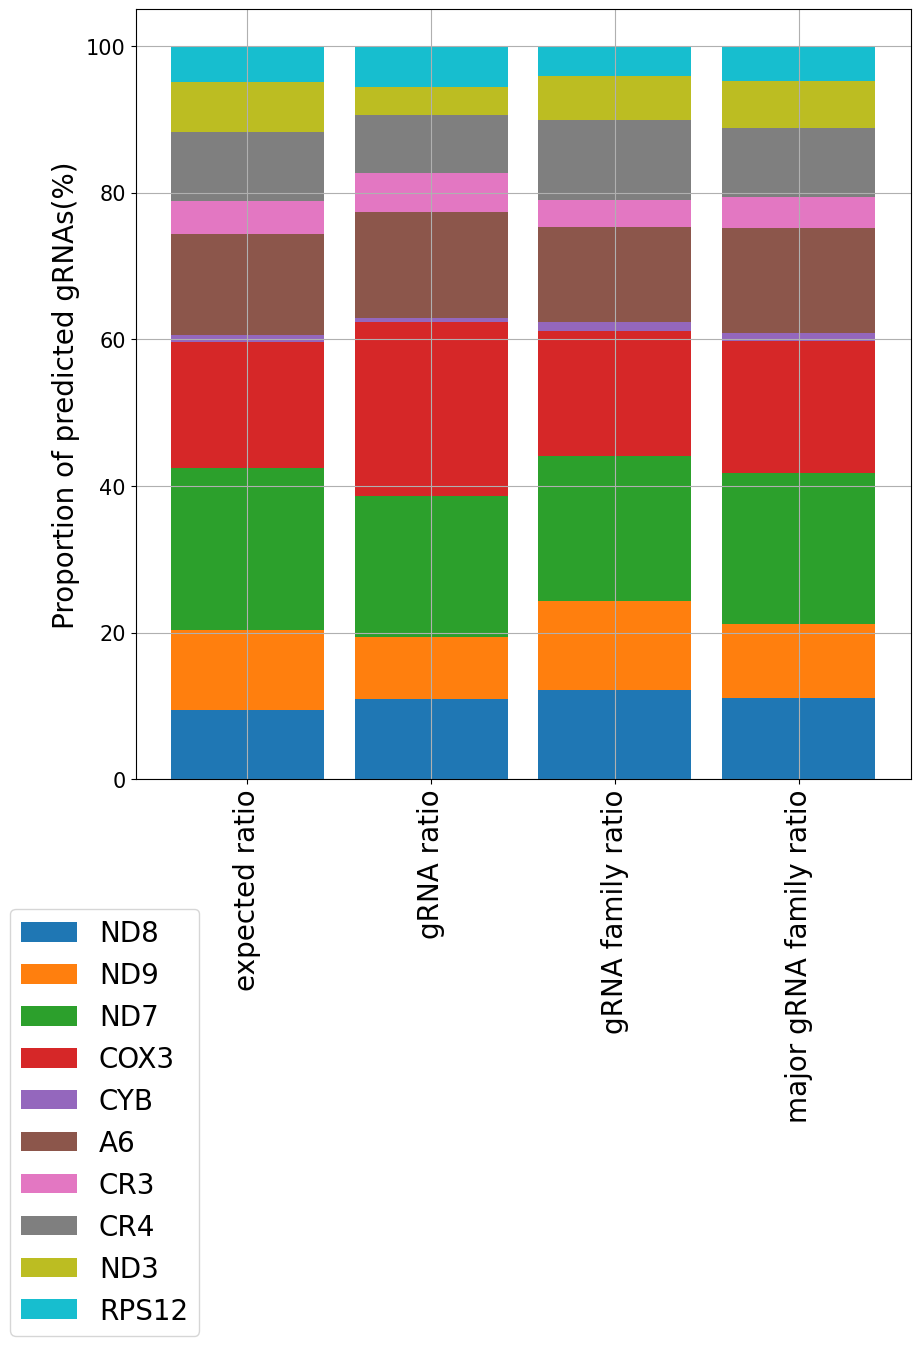

In [63]:
ratio_obs=gRNA_ratio(gRNA_dict,gfam,high_presence,gf_enriched,ratio_exp,pv=0.05)

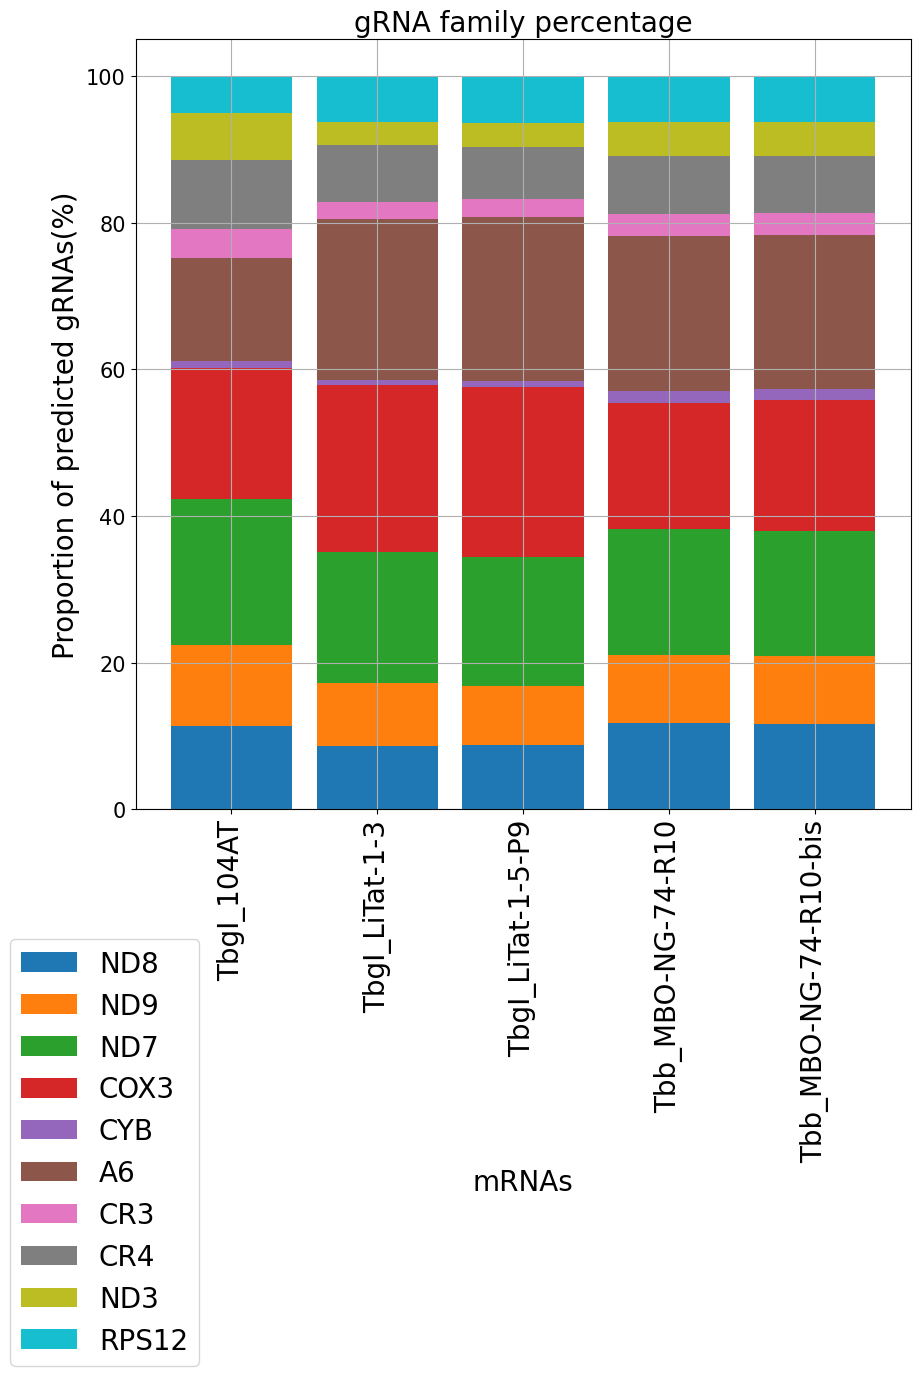

In [64]:
plot_gRNA_percentage_multi_strain(['TbgI_104AT',
                                   'TbgI_LiTat-1-3','TbgI_LiTat-1-5-P9',
                                   'Tbb_MBO-NG-74-R10', 'Tbb_MBO-NG-74-R10-bis'],
                                  strain_gfam,gRNA_dict,combined,strain_mini_sets,mini_dict,figw=4,figh=8,width=0.35,
                                 title='gRNA family percentage')

plot_gRNA_percentage_multi_strain(['TbgI_104AT','Tbb_AnTat-17-1','Tbb_P8F',
                                   'TbgI_LiTat-1-3','TbgI_LiTat-1-5-P9','TbgI_KIN-1', 'TbgI_Bosendja',
                                   'Tbb_MBO-NG-74-R10-bis',
                                   'Tbb_MBO-NG-74-R10','Tbb_Lister-427-AT1-KO','Tbb_Lister-427'],
                                  strain_gfam,gRNA_dict,combined,strain_mini_sets,mini_dict,figw=4,figh=8,width=0.35,
                                 title='gRNA family percentage')

plot_gRNA_percentage_multi_strain_cpnb(['TbgI_104AT','Tbb_AnTat-17-1','Tbb_P8F',
                                   'TbgI_LiTat-1-3','TbgI_LiTat-1-5-P9','TbgI_KIN-1', 'TbgI_Bosendja',
                                   'Tbb_MBO-NG-74-R10-bis',
                                   'Tbb_MBO-NG-74-R10','Tbb_Lister-427-AT1-KO','Tbb_Lister-427'],
                                  strain_gfam,gRNA_dict,combined,strain_mini_sets,mini_dict,figw=4,figh=8,width=0.35,
                                 title='gRNA percentage per mRNA')

In [1]:
#combined[combined['taxon']=='T.b. gambiense type I']['minicircle_classes']

gfam_visualize5(strain_gfam,gRNA_dict,combined,strain_mini_sets,mini_dict)

In [66]:
#a=sns.color_palette("viridis", as_cmap=True)
#strain_gfam['TbgI_104AT']
#strain_gfam.keys()
Tbg1mini=combined[combined['taxon']=='T.b. gambiense type I']
a=Tbg1mini.count(axis=0)
intbg1={k:v for k,v in zip(a.index,a) if k.startswith('Tb_mO_') and v!=0}
tbg1_df=Tbg1mini[list(intbg1.keys())]
presence=tbg1_df.count(axis=0)
tbg1_df.loc['presence']=presence
#means
means={mini:tbg1_df[mini].mean() for mini in tbg1_df.columns}
tbg1_df.loc['means']=means.values()
tbg1_df=tbg1_df.sort_values(by='presence',axis=1,ascending=False)


/tmp/ipykernel_265/1093108149.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tbg1_df.loc['presence']=presence
/tmp/ipykernel_265/1093108149.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tbg1_df.loc['means']=means.values()


def plot_minicircle_copy_number(tbg1_df,outdir):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(50, 5), sharey=False)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    data=tbg1_df.loc[[i for i in tbg1_df.index if i not in ['presence','means']]].fillna(0)
    data=[[v for v in data[m] if v !=0] for m in data.columns]
    ax.boxplot(data,labels=tbg1_df.columns,boxprops=boxprops,medianprops=medianprops)
    #ax.tick_params(labelsize=5)
    ax.set_xticklabels(tbg1_df.columns,rotation=90)
    plt.savefig(f"{outdir}/Tbg1_unique_minicircle_copy_boxplot.pdf")
    plt.show()
plot_minicircle_copy_number(tbg1_df,'/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb')

In [67]:

def show_mean_cpnb_gfam_by_taxon(strain_gfam_df):
    taxa=['Tb','Tbb','Tbr','TbgII','TbgI']
    fig, axs = plt.subplots(nrows=round(len(taxa)/2)+1, ncols=2, figsize=(5*2, 5*(round(len(taxa)/2)+1)), sharey=False)
    for i,t in enumerate(taxa):
        ax=axs[round(i/2),i%2]
        tmp=strain_gfam_df[strain_gfam_df['taxon']==t]
        means={gf:tmp[gf].mean() for gf in tmp.columns if gf !='taxon'}
        ax.hist(means.values(),bins=range(0,round(max(means.values())),5))
        ax.set_xlabel(f"{t} gRNA family copy")
        ax.set_ylabel(f"gRNA family counts")
        print(min(means.values()))
    plt.show()
        

def visualize_average_gf_by_position(gRNA_families,strain_gfam_df,outdir):
    #draw insertion sites: 0 for insertions  
    fig, axs = plt.subplots(nrows=len(insertions), ncols=1, figsize=(200, 50), sharey=False)
    taxa=['Tb','Tbb','Tbr','TbgII','TbgI']
    #taxa=['TbgI']
    for ax,mRNA in zip(axs,insertions):
        ax.set_xlabel(mRNA,fontsize=15)
        ax.set_ylabel("gRNA gene copy",fontsize=15)
        xlim=len(insertions[mRNA])+60
        ax.set_xlim(left=0,right=xlim)
        #ax.axis('off')
        d=0
        #label numbers for mRNA length
        for i in range(0,len(insertions[mRNA]),50):
            ax.text(i,d,f"{i}",fontsize=15)
        d+=-0.5
        #insertions
        x=[i for i,c in enumerate(insertions[mRNA]) if c==1 ] 
        y=[d]*len(x)
        ax.scatter(x,y,marker=3,color='purple',linewidth=5)
        d+=-1
        #draw deletions
        x=[i for i,c in enumerate(dels[mRNA]) if c==0 ] 
        y=[d]*len(x)
        ax.scatter(x,y,marker=3,color='red',linewidth=5)
        d+=-1
        #show gRNA family statistics
        boxprops = dict(linestyle='-', linewidth=2, color='b')
        medianprops = dict(linestyle='-', linewidth=2, color='r')
        for gf in gRNA_families[mRNA]:
            if gf in strain_gfam_df.columns:
                data=[strain_gfam_df[strain_gfam_df['taxon']==t][gf].fillna(0) for t in taxa]#if not fillna columns with na values cannot be plotted
                p=gRNA_families[mRNA][gf]['bound'][0]
                ax.boxplot(data,labels=taxa,boxprops=boxprops,medianprops=medianprops,positions=np.array(range(len(taxa)))*0.5+p)
    plt.savefig(f"{outdir}/gfam_copy_boxplot.real_positions.pdf")
    plt.show()

def visualize_average_gf_by_position2(gRNA_families,strain_gfam_df,outdir):
    #draw insertion sites: 0 for insertions  
    fig, axs = plt.subplots(nrows=len(insertions), ncols=1, figsize=(200, 50), sharey=False)
    taxa=['Tb','Tbb','Tbr','TbgII','TbgI']
    #taxa=['TbgI']
    for ax,mRNA in zip(axs,insertions):
        ax.set_xlabel(mRNA,fontsize=15)
        ax.set_ylabel("gRNA gene copy",fontsize=15)
        #show gRNA family statistics
        boxprops = dict(linestyle='-', linewidth=2, color='b')
        medianprops = dict(linestyle='-', linewidth=2, color='r')
        p=0
        for gf in gRNA_families[mRNA]:
            if gf in strain_gfam_df.columns:
                data=[strain_gfam_df[strain_gfam_df['taxon']==t][gf].fillna(0) for t in taxa]#if not fillna columns with na values cannot be plotted
                #p=gRNA_families[mRNA][gf]['bound'][0]
                ax.boxplot(data,labels=taxa,boxprops=boxprops,medianprops=medianprops,positions=np.array(range(len(taxa)))*1+p)
                p+=len(taxa)+1
    plt.savefig(f"{outdir}/gfam_copy_boxplot.even_space.pdf")
    plt.show()

visualize_average_gf_by_position(gRNA_families,strain_gfam_df,'/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb')
visualize_average_gf_by_position2(gRNA_families,strain_gfam_df,'/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb')

In [68]:
def get_mean():
    for t in set(combined['taxon']):
        mean=sum(combined[combined['taxon']==t]['minicircle_classes'])/len(combined[combined['taxon']==t])
        print(f"{t} {mean}")
get_mean()

T.b. brucei 325.35526315789474
T.b. gambiense type I 111.51351351351352
T.b. gambiense type II 283.5
T.b. rhodesiense 287.1304347826087


show_mean_cpnb_gfam_by_taxon(strain_gfam_df)

outfile='/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb/gRNA_family_copy'
tbr=gfam_visualize2_2('Tbr_Etat-1-2R',strain_gfam,gRNA_dict,combined,insertions,dels,outfile)
tbg1=gfam_visualize2_2('TbgI_104AT',strain_gfam,gRNA_dict,combined,insertions,dels,outfile)
for k in tbr:
    if k in tbg1:
        a=ttest_ind(tbr[k], tbg1[k])
        print('pvalue',round(a.pvalue,4),f"{k}")

outfile='/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb/gRNA_family_copy'
gfam_visualize2('Tbb_Lister-427',strain_gfam,gRNA_dict,combined,insertions,dels,outfile)

In [69]:
def gfam_visualize4(strains,strain_gfam,combined,figsz=(8,8)):
    fig, axs = plt.subplots(nrows=len(strains), ncols=1, figsize=figsz, sharey=False)
    for i,strain in enumerate(strains):
        tmp=strain_gfam[strain]
        cpnb=[sum(tmp[gf].values()) for gf in tmp]
        axs[i].hist(cpnb,bins=range(0,round(max(cpnb)),10))
        axs[i].set_xlabel('gRNA family gene copies')
        axs[i].set_ylabel("gRNA family count",fontsize=15)
        axs[i].set_xlim(left=-5,right=max(cpnb)+10)
        axs[i].set_title(f"{strain} size {round(combined.loc[strain,'Total MCN per network'])} diversity {combined.loc[strain,'minicircle_classes']}")
    plt.show()


gfam_visualize4(['Tbr_MHOM-ZM-82-TRPZ186','TbgI_NDMI','Tbr_Etat-1-2R','TbgI_MOERBEKE-82'],strain_gfam,combined,figsz=(8,20))

#network size around 4721
gfam_visualize4(['Tbr_MHOM-KE-81-LVH122','TbgI_LOKO','TbgI_PEYA','Tbr_MCAP-ZM-83-TRPZ267'],strain_gfam,combined,figsz=(8,20))

outfile='/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb/gRNA_family_copy'
gfam_visualize3('Tbr_MHOM-ZM-82-TRPZ186',strain_gfam,gRNA_dict,combined,insertions,dels,outfile)

all_mini=[i for i in combined.columns if 'Tb_mO' in i]
missed=[i for i in all_mini if i not in mini_dict]
print(len(missed),missed,len(renamed_mini_family))

In [70]:
def mini_diversity_es_coverage(strain_mini_sets,df_es):
    color_dict={'TbgI':'red','TbgII':'orange','Tbb':'blue','Tbr':'green','Tb':'k','Tb':'k'}
    to_plot=[['A6','A6','COX3'],[ 'CR3', 'CR4', 'CYB'],['ND3','ND7', 'ND8'],['ND8','ND9', 'RPS12']]
    fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 20), sharey=True)
    labels=list(sorted(set(df_es['taxon'])))
    for i in range(4):
        for j in range(3):
            x=[len(strain_mini_sets[s]) for s in df_es.index]
            y=df_es[to_plot[i][j]]
            colors=[color_dict[t] for t in df_es['taxon']]
            axs[i,j].scatter(x,y,c=colors)
            axs[i,j].set_xlabel('minicircle class #')
            axs[i,j].set_ylabel(f'ES coverage {to_plot[i][j]}')
            axs[i,j].hlines(80,0,700,linestyles='dashed')
            axs[i,j].hlines(90,0,700,linestyles='dashed')
            axs[i,j].vlines(105,0,100,linestyles='dashed')
    plt.show()

#mini_diversity_es_coverage(strain_mini_sets,df_es)

#analysis of minicircle families and some basic statistics

In [71]:
#find minicircle families for each strain
mini_fam_sets,mf_presence,mini_family,mf_similarity1,mf_similarity2=strain_mini_fam(strain_mini_sets,renamed_mini_family)
#remove:
mini_family2=SitaBip1_remove(mf_presence,mini_family)
#again
#find minicircle families for each strain
mini_fam_sets,mf_presence,mini_family2,mf_similarity1,mf_similarity2=strain_mini_fam(strain_mini_sets,mini_family2)
gfam={gf:record for m,v in gRNA_families.items() for gf,record in v.items()}
for gf in gfam:
    rightmost=[int(gRNA_dict[g]['mRNA_end'])-6 for g in gfam[gf]['gRNA']]
    leftmost=[int(gRNA_dict[g]['mRNA_start']) for g in gfam[gf]['gRNA']]
    gfam[gf]['editing_range']=(min(leftmost),min(rightmost))

Total minicircle family before remove those unique to SitaBip1:881
Total minicircle family after remove those unique to SitaBip1: 881


In [ ]:
strain_mini_sets

In [72]:
outfile='/home/jovyan/Minicircle_gRNA_families/Tb_phylogeny/mf_morphology_seq20240924.fasta'
morph_seq=make_fake_sequence(combined,mini_fam_sets,mf_similarity1,outfile)

In [ ]:
#
def plot_gf_presence(gf_presence):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12), sharey=True)
    df=pd.DataFrame.from_dict(gf_presence)
    df.fillna(0)
    ax[0] = sns.violinplot(data=df,color=".8",cut=0,inner="quart",bw_adjust=0)
                       # cut=min(df[columny]),bw=0.2,
                      # order=sorted(list(set(df[columnx]))))
    #ax[0]= sns.stripplot(data=df, jitter=True)
    ax[0].set_xticks(range(len(df.columns)),df.columns)
    start=0
    by_mrna={}
    for s in gf_presence:
        by_mrna[s]={}
        for gf in gf_presence[s]:
            if gf.split('-')[0] not in by_mrna[s]:
                by_mrna[s][gf.split('-')[0]]=[]
                by_mrna[s][gf.split('-')[0]].append(gf_presence[s][gf])
            else:
                by_mrna[s][gf.split('-')[0]].append(gf_presence[s][gf])
    df=pd.DataFrame.from_dict(by_mrna)
    df.drop(index='MURF2')
    def plot2():
        for mrna in df.index:
            # first boxplot pair
            bp = ax[1].boxplot(df.loc[mrna], positions = [i+start for i in range(len(df.columns))], widths = 0.6)
            start+=len(df.columns)+1
        ax[1].set_xticks(range(0, len(df.index) * (len(df.columns)+1), (len(df.columns)+1)), df.index)
    plt.show()
    return (df)

df=plot_gf_presence(gf_presence)

def strain_with_gf(gRNA_dict,gfam,strain_mini_sets,gf='A6_v1-799_801'):
    found=[]
    for g in gfam[gf]['gRNA']:
        m=gRNA_dict[g]['mO_name']
        for s in strain_mini_sets:
            if m in strain_mini_sets[s]:
                found.append(s)
    return(list(set(found)))

found1=strain_with_gf(gRNA_dict,gfam,strain_mini_sets,gf='A6_v1-799_801')
found2=strain_with_gf(gRNA_dict,gfam,strain_mini_sets,gf='A6_v2-799_805')
with_a6_v1=combined.loc[found1,['taxon','country','continent']]
with_a6_v1['A6_v1 init']=['yes' if i in found2 else 'no' for i in with_a6_v1.index]
with_a6_v1

#set(found1).intersection(set(found2))

In [ ]:
def strains_with_mf(mini_fam_sets,mfs):
    #found_in=[]
    found_in=[s for s in mini_fam_sets if True in [i in mini_fam_sets[s] for i in mfs]]
    #for s in mini_fam_sets:
    #    if True in [i in mini_fam_sets[s] for i in mfs]:
    #        #print([i in mini_fam_sets[s] for i in mfs])
    #        found_in.append(s)
    print(f"found in {len(found_in)} strains")
    print(found_in)

In [ ]:
#show cassette statistics
def cassette_counts(gRNA_dict):
    cs=[v['cassette_label'] for k,v in gRNA_dict.items() if v['cassette_label'] != 'Maxi' and v['cassette_label'] != 'Orphan']
    gRNAcounts={i:cs.count(i) for i in set(cs)}
    c_boundaries={'I':310,'II':450,'III':520,'IV':720,'V':800}
    cs=[int(v['circle_start']) for k,v in gRNA_dict.items() if v['cassette_label'] != 'Maxi' and v['cassette_label'] != 'Orphan']
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)
    ax.hist(cs,bins=range(0,1100,10),alpha=0.5)
    #draw cassette boundaries
    for b in ['I','II','III','IV']:
        ax.vlines(c_boundaries[b],0,900,linestyle='dashed')
    #annotate number of gRNAs
    for k,v, in c_boundaries.items():
        ax.text(c_boundaries[k],850,str(gRNAcounts[k]),ha='right',fontsize=15)
    #style
    ax.set_ylim(0,900)
    plt.show()
cassette_counts(gRNA_dict)

In [ ]:
#distribution of minicircle family presence in Tb strains
plt.hist([mf_presence[mf] for mf in mf_presence],bins=np.array(range(0,10,1))/10)
plt.vlines(0.5,0,500,ls='--')
plt.show()

In [ ]:
outfile='/home/jovyan/Minicircle_gRNA_families/Tb_phylogeny/mf_presence.pickle'
pickle_out(mf_presence,outfile)

In [ ]:
#use combinations from itertools
def sexual_recombination(mf_similarity1,mini_family2,mini_fam_sets,combined,out=False,figw=50,figh=100):
    colors={'TbgI':'red','TbgII':'cornflowerblue','Tbb':'green','Tbr':'orange','Tb':'black'}
    fig,ax = plt.subplots(1,1,figsize=(figw,figh))
    y=0
    def visualize(y,selected,mf_similarity1,mini_family,mini_fam_sets):
        for s in selected:
            similarity=[mf_similarity1[s][k]**2 for k in mf_similarity1[s]]
            ax.scatter(range(len(similarity)),[y]*len(similarity),color='dimgray',marker='|',alpha=similarity)
            presence=[i  for i,mf in enumerate(mini_family) if mf in mini_fam_sets[s]]
            ax.scatter(presence,[y]*len(presence),color=colors[s.split('_')[0]],marker='|')
            ax.text(-70,y,f"{s}",color=colors[s.split('_')[0]])
            y-=1
        return(y)
    
    sets={s:{mf for mf in mf_similarity1[s] if mf_similarity1[s][mf]>=0.8} #only consider minicircle families that are present or with over 80% similarity
       for s in mf_similarity1 if combined.loc[s,'taxon']!='T.b. gambiense type I'}
    for s in sets:
        #print(f"processing {s}")
        tmp={s2: sets[s].intersection(sets[s2])
             for s2 in sets if s2 !=s} #shared minifamily with other strains
        pairs=list(combinations([s2 for s2 in sets if s2 !=s],2)) #all combinations of parental strains
        for pair in pairs:
            overlap=tmp[pair[0]].intersection(tmp[pair[1]])
            if len(overlap)<len(tmp[pair[0]])*0.63 and len(overlap)<len(tmp[pair[1]])*0.63:
                print(s,len(sets[s]),pair[0],len(tmp[pair[0]]),pair[1],len(tmp[pair[1]]),len(overlap))   
                selected=[s,pair[0],pair[1]]
                y=visualize(y,selected,mf_similarity1,mini_family,mini_fam_sets)
    ax.set_xlim(-80,len(mini_family)+1)
    plt.savefig(out)
    plt.show()
    #return(s,len(tmp))

In [ ]:
#out='/home/jovyan/Minicircle_gRNA_families/Tb_phylogeny/sexual_recombination.pdf'
#sexual_recombination(mf_similarity1,mini_family,mini_fam_sets,combined,out=out,figw=50,figh=30)

the number of minicircle families for each subspecies saturates as the sample size increases, except for TbgII which has a very small sample size compared to other Tb subspecies

In [ ]:
cumulation_plot_mf(mini_fam_sets,figw=20,figh=20)

In [ ]:
#some minicircle families are not assigned because they only contain minicircles from a non_Tb strain: SitaBip1, which has been removed from analysis
#those minicircle families are removed from rename_mini_familya
#print([i for k in mf_presence for i in renamed_mini_family[k]['class'] if mf_presence[k]==0])


In [ ]:
plot_mfam_number_of_gfam(mini_family2,mf_presence,out=False,figw=20,figh=5)

In [ ]:
#sort strain by subspecies
#sort minicircle families by their percentage of presence
out='/home/jovyan/Minicircle_gRNA_families/Tb_phylogeny/mf_fingerprint.pdf'
plot_mfam_presence(mini_fam_sets,mini_family,out,figw=50,figh=100)

In [ ]:
out='/home/jovyan/Minicircle_gRNA_families/Tb_phylogeny/mf_fingerprint_similarity.pdf'
plot_mfam_similarity(mf_similarity1,mini_family,mini_fam_sets,out=out,figw=50,figh=100)


mf_binary={s:{mf:1 if mf in mini_fam_sets[s] else 0 for mf in mf_presence} for s in mini_fam_sets}
df_binary=pd.DataFrame.from_dict(mf_binary, orient='index')
dendro_out='/home/jovyan/Minicircle_gRNA_families/Tb_phylogeny/dendrogram3.pdf'
heatmapout='/home/jovyan/Minicircle_gRNA_families/Tb_phylogeny/similarity_heatmap3.pdf'
#draw_heatmap_dendrogram(df_binary,heatmapout,dendro_out)

In [ ]:
#not just 0 and 1, also shows highest percentage of similarity available for each mf
df_max_sim=pd.DataFrame.from_dict(mf_similarity1, orient='index')
dendro_out='/home/jovyan/Minicircle_gRNA_families/Tb_phylogeny/dendrogram3.pdf'
heatmapout='/home/jovyan/Minicircle_gRNA_families/Tb_phylogeny/similarity_heatmap3.pdf'
draw_heatmap_dendrogram(df_max_sim,heatmapout,dendro_out)

In [ ]:
outfile='/home/jovyan/Minicircle_gRNA_families/Tb_phylogeny/mf_morphology_seq0830.fasta'
morph_seq=make_fake_sequence(combined,mini_fam_sets,mf_similarity1,outfile)

In [ ]:
selected={'mf_similarity':mf_similarity1,'mini_family':mini_family2,'morph_seq':morph_seq}
pickle_out(selected,'/home/jovyan/Minicircle_gRNA_families/Tb_phylogeny/mini_family.pickle')